In [1]:
# Importação de Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import requests, zipfile
import os
import shutil
from io import BytesIO
from os.path import exists

In [2]:
# Criação das variáveis de ambiente
sep = ';'
dec = ','
enc = 'latin1'
ufs = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO', 'ZZ']
ufs_ne = ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']
ufs_n = ['AM', 'PA', 'AC', 'RO', 'RR', 'AP', 'TO']
ufs_co = ['MT', 'MS', 'GO']
ufs_se = ['SP', 'MG', 'RJ', 'ES']
ufs_s = ['PR', 'SC', 'RS']
turnos = [('1', '051020221321'), ('2', '311020221535')]
df_columns = ['DT_BU_RECEBIDO', 'CD_ELEICAO', 'NR_TURNO','SG_UF','CD_MUNICIPIO','NM_MUNICIPIO','NR_ZONA','NR_SECAO','NR_LOCAL_VOTACAO','QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES','CD_TIPO_URNA','DS_TIPO_URNA','NR_VOTAVEL','NM_VOTAVEL','QT_VOTOS','NR_URNA_EFETIVADA','CD_CARGA_1_URNA_EFETIVADA','CD_CARGA_2_URNA_EFETIVADA','CD_FLASHCARD_URNA_EFETIVADA','DT_CARGA_URNA_EFETIVADA','DS_AGREGADAS','DT_ABERTURA','DT_ENCERRAMENTO','QT_ELEITORES_BIOMETRIA_NH','DT_EMISSAO_BU','NR_JUNTA_APURADORA','NR_TURMA_APURADORA']
date_fmt = mdates.DateFormatter('%H:%M')
df1 = None
df2 = None

In [3]:
# Arrumação da pasta 'dados'

for uf in ufs_ne:
    for turno in turnos:
        arquivo = f'bweb_{turno[0]}t_{uf}_{turno[1]}'
        if exists(f'dados/{arquivo}/'):
            print(f'Existe dados/{arquivo}/')
            if exists(f'dados/{arquivo}/{arquivo}.csv'):
                print(f'Existe dados/{arquivo}/{arquivo}.csv')
                shutil.move(f'dados/{arquivo}/{arquivo}.csv', f'dados/{arquivo}.csv')
                shutil.rmtree(f'dados/{arquivo}/')
            

In [4]:
# Função para obter agrupamento de diferenças entre DataFrames por NM_VOTAVEL

def df_diff_group(df_main, df_urnas):
    df_soma = None

    for i in range(len(df_urnas)):
        cidade = df_urnas.iloc[i, df_urnas.columns.get_loc('CD_MUNICIPIO')]
        zona = df_urnas.iloc[i, df_urnas.columns.get_loc('NR_ZONA')]
        secao = df_urnas.iloc[i, df_urnas.columns.get_loc('NR_SECAO')]
        local = df_urnas.iloc[i, df_urnas.columns.get_loc('NR_LOCAL_VOTACAO')]

        df_temp = df_main[(df_main['CD_MUNICIPIO'] == cidade) &
                          (df_main['NR_ZONA'] == zona) &
                          (df_main['NR_SECAO'] == secao) &
                          (df_main['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

        if (df_soma is not None):
            df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
        else:        
            df_soma = df_temp
    df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

    return df_soma

In [67]:
# Função para gerar grafico de totalização temporal

def gerar_grafico_temporal(df, titulo, uf):
    total = df['QT_VOTOS'].sum()

    df_13 = df[df['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
    df_22 = df[df['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

    df_13.set_index('data_hora', inplace=True)
    df_22.set_index('data_hora', inplace=True)

    df_13.sort_index(inplace=True)
    df_22.sort_index(inplace=True)

    df_13['acumulados'] = df_13['QT_VOTOS'].cumsum()
    df_22['acumulados'] = df_22['QT_VOTOS'].cumsum()

    df_13['acumulados'] = (df_13['acumulados'] / total) * 100
    df_22['acumulados'] = (df_22['acumulados'] / total) * 100

    # Grafico da apuração de votos por horário
    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(df_22.index, df_22['acumulados'], label=f"Bolsonaro ({df_22['acumulados'].iloc[-1]:.2f}%)")
    ax.plot(df_13.index, df_13['acumulados'], label=f"Lula ({df_13['acumulados'].iloc[-1]:.2f}%)")

    date_fmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_tick_params(labelrotation=90)

    ax.set_title(f'{titulo} ({uf})')
    ax.legend()

In [68]:
# Função para gerar gráfico de porcentagem total

def gerar_grafico_porcentagem(df, titulo, uf_extenso):
    total = df['QT_VOTOS'].sum()

    df_order = df.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
    df_order['QT_VOTOS'] = (df_order['QT_VOTOS'] / total) * 100
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='NM_VOTAVEL', 
                    y='QT_VOTOS', 
                    data=df_order)

    ax.bar_label(ax.containers[0], fmt="%.2f%%")
    ax.set(title=f'{titulo} - {uf_extenso}')

    for item in ax.get_xticklabels():
        item.set_rotation(75)

In [69]:
# Função para gerar contagem de urnas suspeitas

def gerar_grafico_urnas_suspeitas(df_soma, df_urnas_22, uf_extenso):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='NM_VOTAVEL', 
                    y='QT_VOTOS', 
                    data=df_soma)

    ax.bar_label(ax.containers[0])
    ax.set(title=f'Votos nas {df_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - {uf_extenso}')

    for item in ax.get_xticklabels():
        item.set_rotation(75)

# Estudo sobre Eleições Presidenciais

## Carga de Dados

### BAHIA

In [8]:
# Carga dos dados dos BUs - Bahia
arquivo1 = f'dados/bweb_{turnos[0][0]}t_BA_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_BA_{turnos[1][1]}.csv'

df1ba = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ba = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_BA_051020221321.csv
Carregado: dados/bweb_2t_BA_311020221535.csv


In [9]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ba['data_hora'] = pd.to_datetime(df1ba['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ba['data_hora'] = pd.to_datetime(df2ba['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [10]:
# Separação dos votos para Presidente
df1ba = df1ba[df1ba['CD_ELEICAO'] == 544]
df2ba = df2ba[df2ba['CD_ELEICAO'] == 545]

### MARANHÃO

In [11]:
# Carga dos dados dos BUs - Maranhão
arquivo1 = f'dados/bweb_{turnos[0][0]}t_MA_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_MA_{turnos[1][1]}.csv'

df1ma = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ma = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_MA_051020221321.csv
Carregado: dados/bweb_2t_MA_311020221535.csv


In [12]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ma['data_hora'] = pd.to_datetime(df1ma['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ma['data_hora'] = pd.to_datetime(df2ma['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [13]:
# Separação dos votos para Presidente
df1ma = df1ma[df1ma['CD_ELEICAO'] == 544]
df2ma = df2ma[df2ma['CD_ELEICAO'] == 545]

### PIAUI

In [14]:
# Carga dos dados dos BUs - Piaui
arquivo1 = f'dados/bweb_{turnos[0][0]}t_PI_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_PI_{turnos[1][1]}.csv'

df1pi = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2pi = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_PI_051020221321.csv
Carregado: dados/bweb_2t_PI_311020221535.csv


In [15]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1pi['data_hora'] = pd.to_datetime(df1pi['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2pi['data_hora'] = pd.to_datetime(df2pi['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [16]:
# Separação dos votos para Presidente
df1pi = df1pi[df1pi['CD_ELEICAO'] == 544]
df2pi = df1pi[df1pi['CD_ELEICAO'] == 545]

### CEARÁ

In [17]:
# Carga dos dados dos BUs - Ceará
arquivo1 = f'dados/bweb_{turnos[0][0]}t_CE_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_CE_{turnos[1][1]}.csv'

df1ce = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ce = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_CE_051020221321.csv
Carregado: dados/bweb_2t_CE_311020221535.csv


In [18]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ce['data_hora'] = pd.to_datetime(df1ce['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ce['data_hora'] = pd.to_datetime(df2ce['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [19]:
# Separação dos votos para Presidente
df1ce = df1ce[df1ce['CD_ELEICAO'] == 544]
df2ce = df1ce[df1ce['CD_ELEICAO'] == 545]

### RIO GRANDE DO NORTE

In [20]:
# Carga dos dados dos BUs - Piaui
arquivo1 = f'dados/bweb_{turnos[0][0]}t_RN_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_RN_{turnos[1][1]}.csv'

df1rn = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2rn = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_RN_051020221321.csv
Carregado: dados/bweb_2t_RN_311020221535.csv


In [21]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1rn['data_hora'] = pd.to_datetime(df1rn['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2rn['data_hora'] = pd.to_datetime(df2rn['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [22]:
# Separação dos votos para Presidente
df1rn = df1rn[df1rn['CD_ELEICAO'] == 544]
df2rn = df1rn[df1rn['CD_ELEICAO'] == 545]

### PARAÍBA

In [23]:
# Carga dos dados dos BUs - Piaui
arquivo1 = f'dados/bweb_{turnos[0][0]}t_PB_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_PB_{turnos[1][1]}.csv'

df1pb = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2pb = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_PB_051020221321.csv
Carregado: dados/bweb_2t_PB_311020221535.csv


In [24]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1pb['data_hora'] = pd.to_datetime(df1pb['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2pb['data_hora'] = pd.to_datetime(df2pb['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [25]:
# Separação dos votos para Presidente
df1pb = df1pb[df1pb['CD_ELEICAO'] == 544]
df2pb = df1pb[df1pb['CD_ELEICAO'] == 545]

### PERNAMBUCO

In [26]:
# Carga dos dados dos BUs - Piaui
arquivo1 = f'dados/bweb_{turnos[0][0]}t_PE_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_PE_{turnos[1][1]}.csv'

df1pe = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2pe = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

Carregado: dados/bweb_1t_PE_051020221321.csv
Carregado: dados/bweb_2t_PE_311020221535.csv


In [27]:
# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1pe['data_hora'] = pd.to_datetime(df1pe['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2pe['data_hora'] = pd.to_datetime(df2pe['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

In [28]:
# Separação dos votos para Presidente
df1pe = df1pe[df1pe['CD_ELEICAO'] == 544]
df2pe = df1pe[df1pe['CD_ELEICAO'] == 545]

### ALAGOAS

In [29]:

# Carga dos dados dos BUs - Alagoas
arquivo1 = f'dados/bweb_{turnos[0][0]}t_AL_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_AL_{turnos[1][1]}.csv'

df1al = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2al = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1al['data_hora'] = pd.to_datetime(df1al['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2al['data_hora'] = pd.to_datetime(df2al['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1al = df1al[df1al['CD_ELEICAO'] == 544]
df2al = df2al[df2al['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_AL_051020221321.csv
Carregado: dados/bweb_2t_AL_311020221535.csv


### SERGIPE

In [30]:
# Carga dos dados dos BUs - Sergipe
arquivo1 = f'dados/bweb_{turnos[0][0]}t_SE_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_SE_{turnos[1][1]}.csv'

df1se = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2se = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1se['data_hora'] = pd.to_datetime(df1se['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2se['data_hora'] = pd.to_datetime(df2se['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1se = df1se[df1se['CD_ELEICAO'] == 544]
df2se = df2se[df2se['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_SE_051020221321.csv
Carregado: dados/bweb_2t_SE_311020221535.csv


### AMAZONAS


In [31]:
# Carga dos dados dos BUs - Amazonas
arquivo1 = f'dados/bweb_{turnos[0][0]}t_AM_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_AM_{turnos[1][1]}.csv'

df1am = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2am = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1am['data_hora'] = pd.to_datetime(df1am['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2am['data_hora'] = pd.to_datetime(df2am['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1am = df1am[df1am['CD_ELEICAO'] == 544]
df2am = df2am[df2am['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_AM_051020221321.csv
Carregado: dados/bweb_2t_AM_311020221535.csv


### PARÁ


In [32]:
# Carga dos dados dos BUs - Pará
arquivo1 = f'dados/bweb_{turnos[0][0]}t_PA_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_PA_{turnos[1][1]}.csv'

df1pa = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2pa = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1pa['data_hora'] = pd.to_datetime(df1pa['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2pa['data_hora'] = pd.to_datetime(df2pa['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1pa = df1pa[df1pa['CD_ELEICAO'] == 544]
df2pa = df2pa[df2pa['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_PA_051020221321.csv
Carregado: dados/bweb_2t_PA_311020221535.csv


### ACRE


In [33]:
# Carga dos dados dos BUs - Acre
arquivo1 = f'dados/bweb_{turnos[0][0]}t_AC_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_AC_{turnos[1][1]}.csv'

df1ac = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ac = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ac['data_hora'] = pd.to_datetime(df1ac['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ac['data_hora'] = pd.to_datetime(df2ac['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1ac = df1ac[df1ac['CD_ELEICAO'] == 544]
df2ac = df2ac[df2ac['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_AC_051020221321.csv
Carregado: dados/bweb_2t_AC_311020221535.csv


### RONDÔNIA


In [34]:
# Carga dos dados dos BUs - Rondônia
arquivo1 = f'dados/bweb_{turnos[0][0]}t_RO_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_RO_{turnos[1][1]}.csv'

df1ro = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ro = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ro['data_hora'] = pd.to_datetime(df1ro['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ro['data_hora'] = pd.to_datetime(df2ro['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1ro = df1ro[df1ro['CD_ELEICAO'] == 544]
df2ro = df2ro[df2ro['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_RO_051020221321.csv
Carregado: dados/bweb_2t_RO_311020221535.csv


### RORAIMA


In [35]:
# Carga dos dados dos BUs - Roraima
arquivo1 = f'dados/bweb_{turnos[0][0]}t_RR_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_RR_{turnos[1][1]}.csv'

df1rr = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2rr = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1rr['data_hora'] = pd.to_datetime(df1rr['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2rr['data_hora'] = pd.to_datetime(df2rr['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1rr = df1rr[df1rr['CD_ELEICAO'] == 544]
df2rr = df2rr[df2rr['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_RR_051020221321.csv
Carregado: dados/bweb_2t_RR_311020221535.csv


### AMAPÁ


In [60]:
# Carga dos dados dos BUs - Amapá
arquivo1 = f'dados/bweb_{turnos[0][0]}t_AP_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_AP_{turnos[1][1]}.csv'

df1ap = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2ap = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1ap['data_hora'] = pd.to_datetime(df1ap['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2ap['data_hora'] = pd.to_datetime(df2ap['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1ap = df1ap[df1ap['CD_ELEICAO'] == 544]
df2ap = df2ap[df2ap['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_AP_051020221321.csv
Carregado: dados/bweb_2t_AP_311020221535.csv


### TOCANTINS


In [75]:
# Carga dos dados dos BUs - Tocantins
arquivo1 = f'dados/bweb_{turnos[0][0]}t_TO_{turnos[0][1]}.csv'
arquivo2 = f'dados/bweb_{turnos[1][0]}t_TO_{turnos[1][1]}.csv'

df1to = pd.read_csv(arquivo1, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo1}')
df2to = pd.read_csv(arquivo2, usecols=df_columns, encoding=enc, sep=sep)
print(f'Carregado: {arquivo2}')

# Criação do campo 'data_hora' para conter os dados de recebimento do BU
df1to['data_hora'] = pd.to_datetime(df1to['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')
df2to['data_hora'] = pd.to_datetime(df2to['DT_BU_RECEBIDO'], format='%d/%m/%Y %H:%M:%S')

# Separação dos votos para Presidente
df1to = df1to[df1to['CD_ELEICAO'] == 544]
df2to = df2to[df2to['CD_ELEICAO'] == 545]

Carregado: dados/bweb_1t_TO_051020221321.csv
Carregado: dados/bweb_2t_TO_311020221535.csv


## 1. PRIMEIRO TURNO

### 1.1. Região NORDESTE

#### 1.1.1. Estados

##### 1.1.1.1. BAHIA

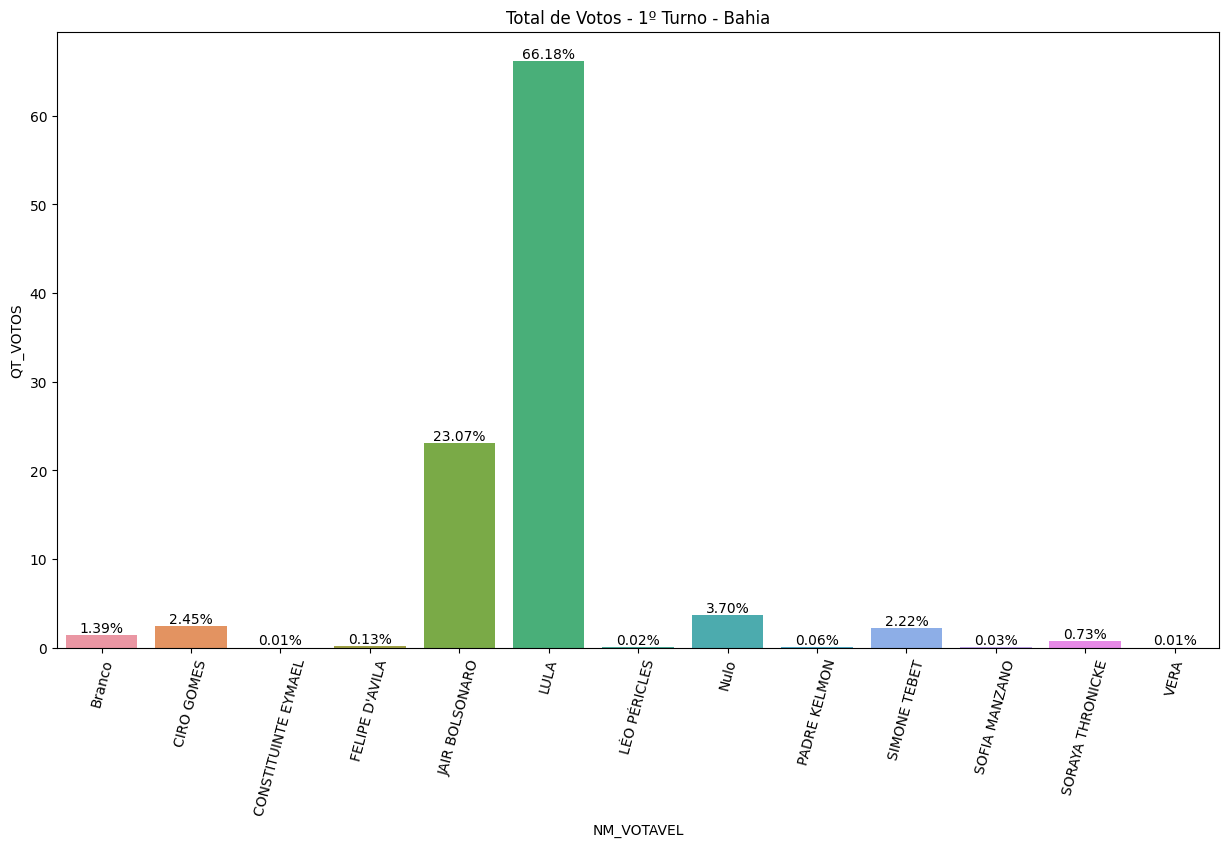

In [36]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1ba, 'Total de Votos - 1º Turno', 'Bahia')

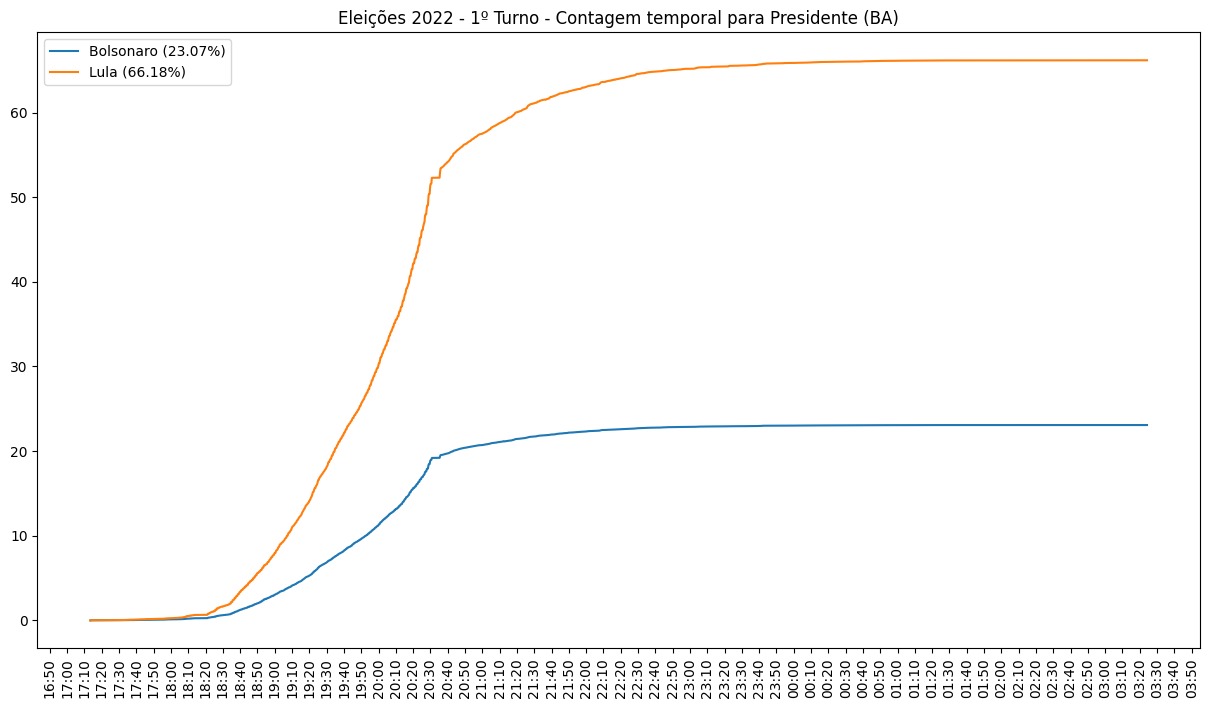

In [37]:
# Total de votos acumulados

gerar_grafico_temporal(df1ba, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'BA')

Quantidade de urnas com 1 voto - Primeiro Turno

In [38]:
df1ba_urnas = df1ba[df1ba['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ba_urnas[df1ba_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ba_urnas[df1ba_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 45


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [39]:

df1ba_urnas_22 = df1ba_urnas[df1ba_urnas['NR_VOTAVEL'] == 22]
df1ba_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
283320                 SALVADOR        5       800              1805
1140031                SALVADOR       19       800              1490
1172982         MANOEL VITORINO       22       160              1139
1690456               ITABERABA       42       288              1570
1705199            CASTRO ALVES       43       132              1376
1746978        SENHOR DO BONFIM       45       310              1872
1748071        SENHOR DO BONFIM       45       322              1937
1861118             MONTE SANTO       50       310              1945
2035534              LAGOA REAL       63       111              1210
2036042                 CAETITÉ       63       120              1791
2074922                 BOQUIRA       65       228              1090
2076161                 BOQUIRA       65       247              1228
2076541                 BOQUIRA       65       255              1309
2081534                 BOQUIRA       65       344              1554
2081581                 BOQUIRA       65       345              1562
2111125                 REMANSO       67       148              1295
2111849                 REMANSO       67       159              1384
2130829             XIQUE-XIQUE       68       126              1406
2133842             XIQUE-XIQUE       68       203              1783
2261909              JAGUAQUARA       76       105              1236
2265677              JAGUAQUARA       76       148              1333
2265721              JAGUAQUARA       76       149              1350
2282008                   BARRA       77       205              1821
2383420            PAULO AFONSO       84       386              1880
2427101                  SEABRA       88       181              1546
2501306  OLIVEIRA DOS BREJINHOS       94       113              1317
2502280  OLIVEIRA DOS BREJINHOS       94       130              1449
2543771    SANTA RITA DE CÁSSIA       97        80              1163
2613054       EUCLIDES DA CUNHA      102       285              1856
2709265                  BANZAÊ      110       154              1244
2723398                CATURAMA      111       209              1112
2724407                CATURAMA      111       230              1201
2915624                   ARACI      123       137              1406
3337371                SERRINHA      150       271              2020
3647480  SÃO FRANCISCO DO CONDE      162       148              1376
3856329               PARATINGA      173       167              1384
3868307                CANARANA      174       111              1228
3870001                CANARANA      174       135              1287
3875515    PALMAS DE MONTE ALTO      175        66              1236
3880261         BARRA DO MENDES      176        29              1074
3880576         BARRA DO MENDES      176        35              1120
3885989         BARRA DO MENDES      176       149              1414
4218865            PILÃO ARCADO      195         7              1058
4220863            PILÃO ARCADO      195        37              1287
4236770   CAPELA DO ALTO ALEGRE      196       226              1198

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

In [40]:

df_soma = df_diff_group(df1ba, df1ba_urnas_22)

gerar_grafico_votos_suspeitos(df_soma, df1ba_urnas_22, 'Bahia')

NameError: name 'gerar_grafico_votos_suspeitos' is not defined

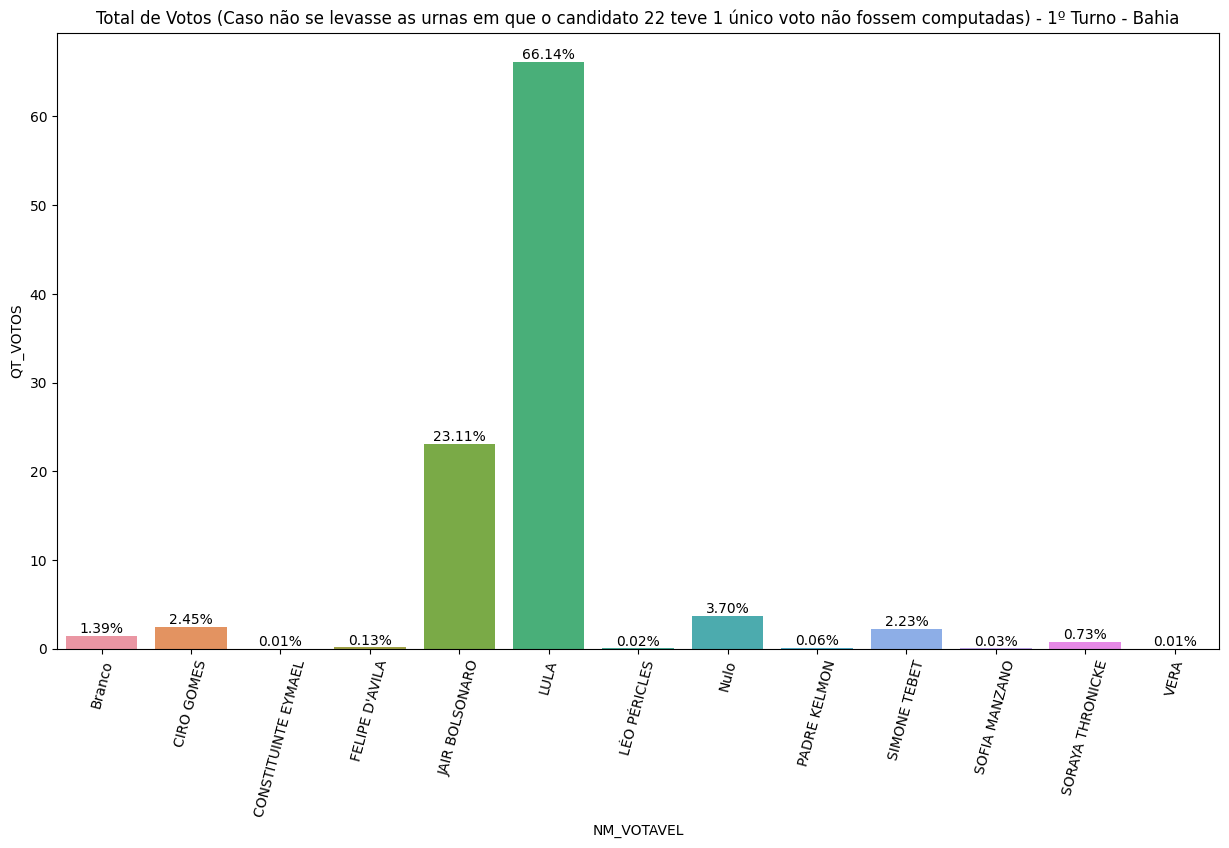

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

df1ba_sub = df1ba[~((df1ba['CD_MUNICIPIO'].isin(df1ba_urnas_22['CD_MUNICIPIO'])) & 
                    (df1ba['NR_ZONA'].isin(df1ba_urnas_22['NR_ZONA'])) & 
                    (df1ba['NR_SECAO'].isin(df1ba_urnas_22['NR_SECAO'])) & 
                    (df1ba['NR_LOCAL_VOTACAO'].isin(df1ba_urnas_22['NR_LOCAL_VOTACAO'])))]

gerar_grafico_porcentagem(df1ba_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Bahia')

In [ ]:
#*********************************
df1ba.shape, df1ba_sub.shape

((246105, 30), (244888, 30))

In [ ]:
df_sub = None
df_urnas = df1ba[df1ba['QT_VOTOS'] == 1]

cidade = df_urnas.loc[df1ba_urnas_22.index]['CD_MUNICIPIO']
zona = df_urnas.loc[df1ba_urnas_22.index]['NR_ZONA']
secao = df_urnas.loc[df1ba_urnas_22.index]['NR_SECAO']
local = df_urnas.loc[df1ba_urnas_22.index]['NR_LOCAL_VOTACAO']

df_temp = df1ba[~(df1ba['CD_MUNICIPIO'].isin(cidade) &
                  df1ba['NR_ZONA'].isin(zona) &
                  df1ba['NR_SECAO'].isin(secao) &
                  df1ba['NR_LOCAL_VOTACAO'].isin(local))]

if (df_soma is not None):
    df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
else:        
    df_soma = df_temp

In [ ]:
df1ba.shape, df1ba_sub.shape, df_soma.shape

((246105, 30), (244888, 30), (119355595, 30))

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

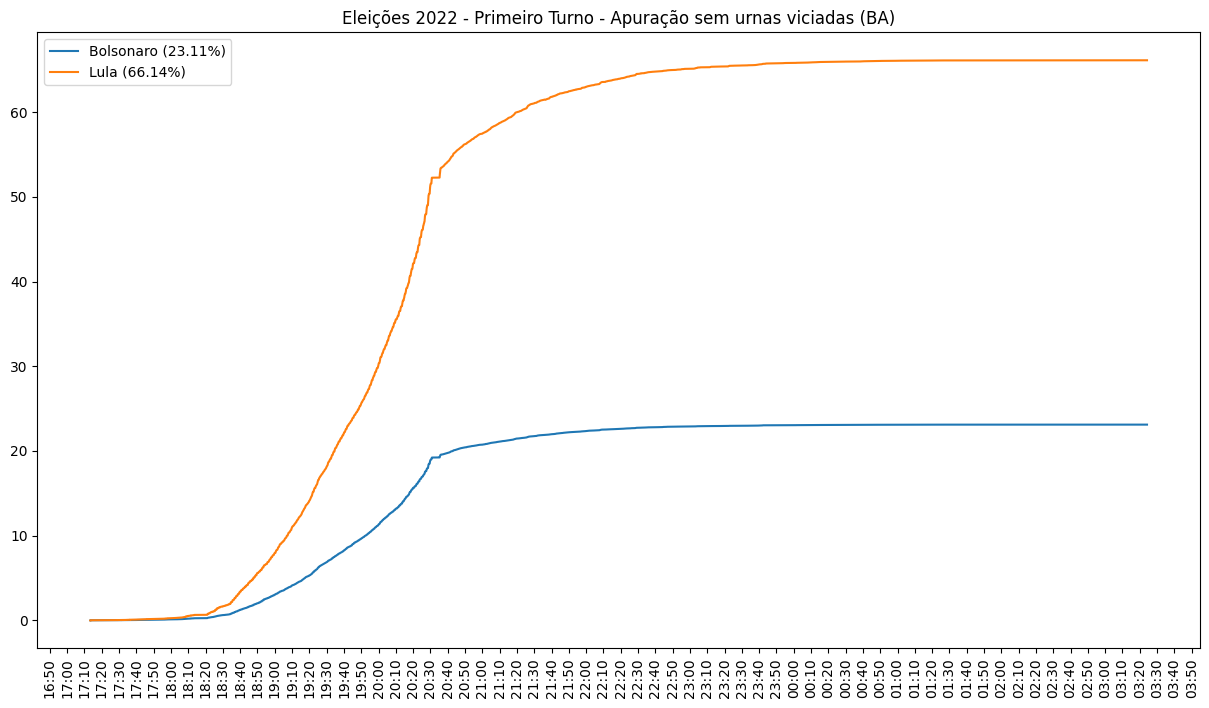

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

gerar_grafico_total(df1ba_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'BA')

##### 1.1.1.2. PIAUI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


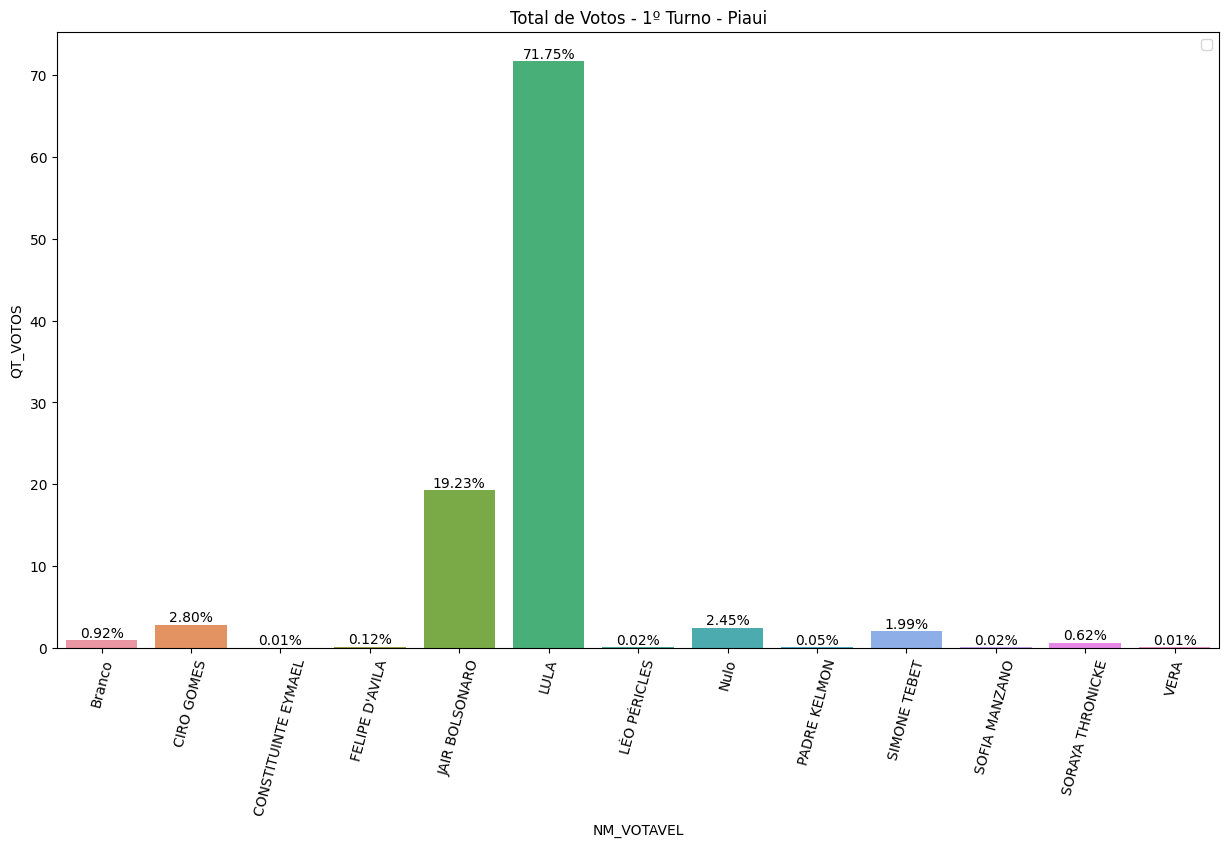

In [ ]:
# Graficos - Total no 1º turno
total1pi = df1pi['QT_VOTOS'].sum()

df1pi_order = df1pi.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pi_order['QT_VOTOS'] = (df1pi_order['QT_VOTOS'] / total1pi) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pi_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Piaui')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

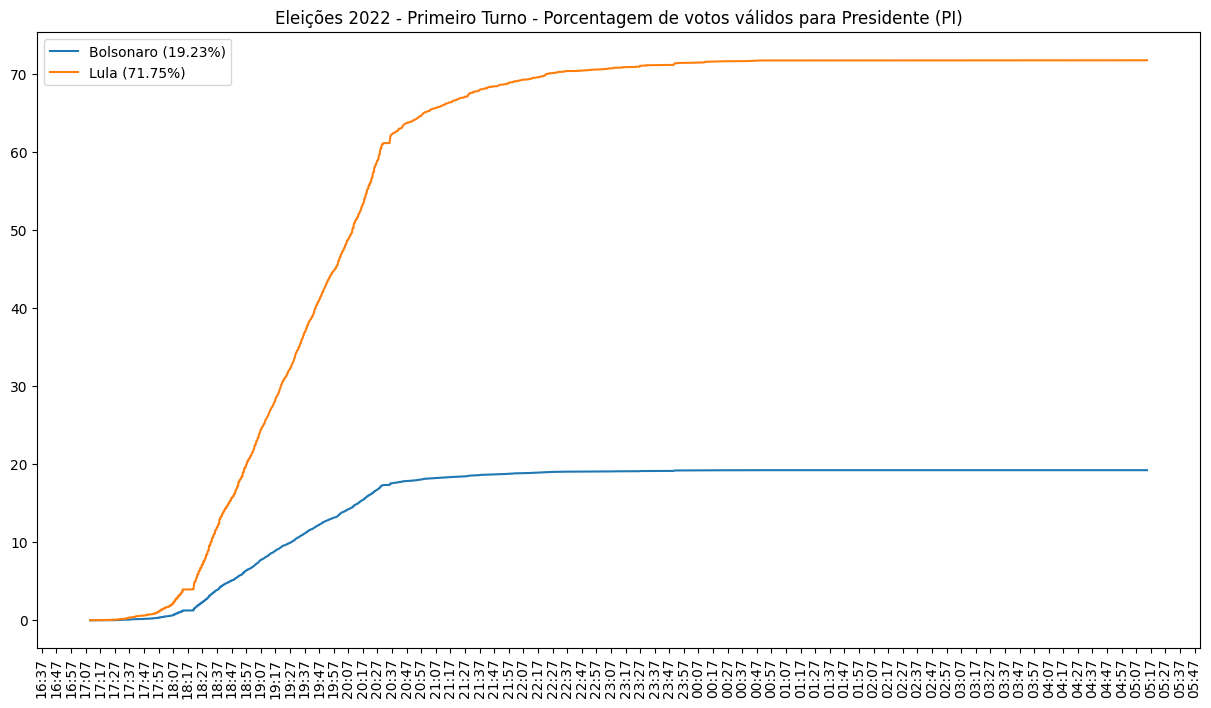

In [ ]:
# Total de votos acumulados

df1pi_13 = df1pi[df1pi['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pi_22 = df1pi[df1pi['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pi_13.set_index('data_hora', inplace=True)
df1pi_22.set_index('data_hora', inplace=True)

df1pi_13.sort_index(inplace=True)
df1pi_22.sort_index(inplace=True)

df1pi_13['acumulados'] = df1pi_13['QT_VOTOS'].cumsum()
df1pi_22['acumulados'] = df1pi_22['QT_VOTOS'].cumsum()

df1pi_13['acumulados'] = (df1pi_13['acumulados'] / total1pi) * 100
df1pi_22['acumulados'] = (df1pi_22['acumulados'] / total1pi) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pi_22.index, df1pi_22['acumulados'], label=f"Bolsonaro ({df1pi_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pi_13.index, df1pi_13['acumulados'], label=f"Lula ({df1pi_13['acumulados'].iloc[-1]:.2f}%)")

date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (PI)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1pi_urnas = df1pi[df1pi['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1pi_urnas[df1pi_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1pi_urnas[df1pi_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 26


In [ ]:

df1pi_urnas = df1pi[df1pi['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1pi_urnas[df1pi_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1pi_urnas[df1pi_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 26


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1pi_urnas_22 = df1pi_urnas[df1pi_urnas['NR_VOTAVEL'] == 22]
df1pi_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
187892                  AMARANTE        8        31              1252
188301                  AMARANTE        8        40              1341
189256                  AMARANTE        8       112              1414
193907                PALMEIRAIS        8       200              1260
262732         CORONEL JOSÉ DIAS       13       242              1163
267678                    URUÇUÍ       14        44              1163
306841          VALENÇA DO PIAUÍ       18        94              1112
307366     NOVO ORIENTE DO PIAUÍ       18       104              1082
315315                    JAICÓS       19       119              1368
355751               RIACHO FRIO       26        35              1058
418251         BURITI DOS MONTES       34       136              1180
418630         BURITI DOS MONTES       34       142              1198
432740           CANTO DO BURITI       36       121              1210
451632      SÃO MIGUEL DO TAPUIO       39        77              1368
479238         RIBEIRO GONÇALVES       44        25              1074
503999            ELESBÃO VELOSO       48        95              1180
504290            ELESBÃO VELOSO       48       101              1228
506724             VÁRZEA GRANDE       48       147              1090
506759             VÁRZEA GRANDE       48       148              1104
527040           COCAL DOS ALVES       53        87              1147
557092           NAZARÉ DO PIAUÍ       61       359              1147
659407  PASSAGEM FRANCA DO PIAUÍ       74       105              1031
661991                  GUARIBAS       79        37              1058
677330               PIMENTEIRAS       89        90              1198
682579         CAMPINAS DO PIAUÍ       90       117              1155
726794                  TERESINA       97       150              1350

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

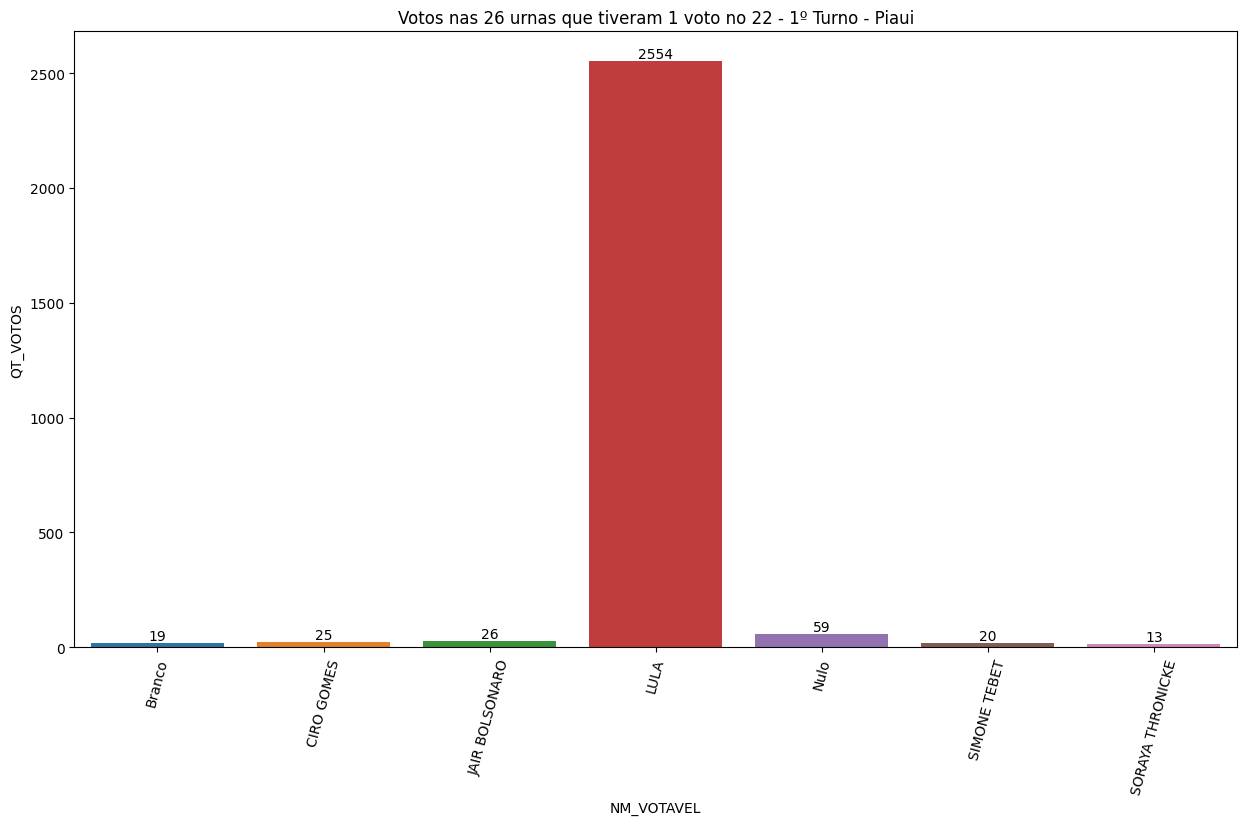

In [ ]:

df_soma = None

for i in range(len(df1pi_urnas_22)):
    cidade = df1pi_urnas_22.iloc[i, df1pi_urnas_22.columns.get_loc('CD_MUNICIPIO')]
    zona = df1pi_urnas_22.iloc[i, df1pi_urnas_22.columns.get_loc('NR_ZONA')]
    secao = df1pi_urnas_22.iloc[i, df1pi_urnas_22.columns.get_loc('NR_SECAO')]
    local = df1pi_urnas_22.iloc[i, df1pi_urnas_22.columns.get_loc('NR_LOCAL_VOTACAO')]

    df_temp = df1pi[(df1pi['CD_MUNICIPIO'] == cidade) &
                    (df1pi['NR_ZONA'] == zona) &
                    (df1pi['NR_SECAO'] == secao) &
                    (df1pi['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

    if (df_soma is not None):
        df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
    else:        
        df_soma = df_temp

df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df_soma)

ax.bar_label(ax.containers[0])
ax.set(title=f'Votos nas {df1pi_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - Piaui')

for item in ax.get_xticklabels():
    item.set_rotation(75)

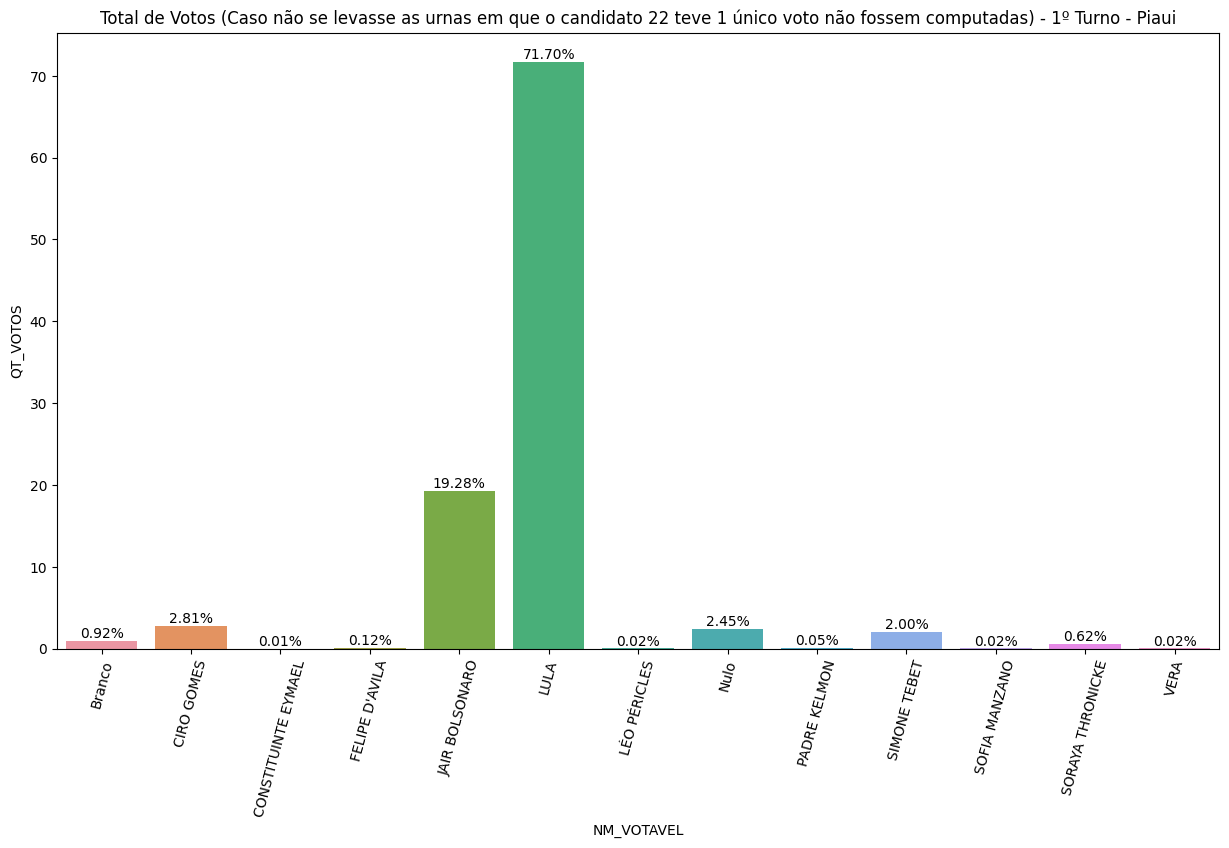

In [ ]:
# Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

df1pi_sub = df1pi[~((df1pi['CD_MUNICIPIO'].isin(df1pi_urnas_22['CD_MUNICIPIO'])) & 
                    (df1pi['NR_ZONA'].isin(df1pi_urnas_22['NR_ZONA'])) & 
                    (df1pi['NR_SECAO'].isin(df1pi_urnas_22['NR_SECAO'])) & 
                    (df1pi['NR_LOCAL_VOTACAO'].isin(df1pi_urnas_22['NR_LOCAL_VOTACAO'])))]

total1pi_sub = df1pi_sub['QT_VOTOS'].sum()

df1pi_sub_order = df1pi_sub.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pi_sub_order['QT_VOTOS'] = (df1pi_sub_order['QT_VOTOS'] / total1pi_sub) * 100

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pi_sub_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno - Piaui')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

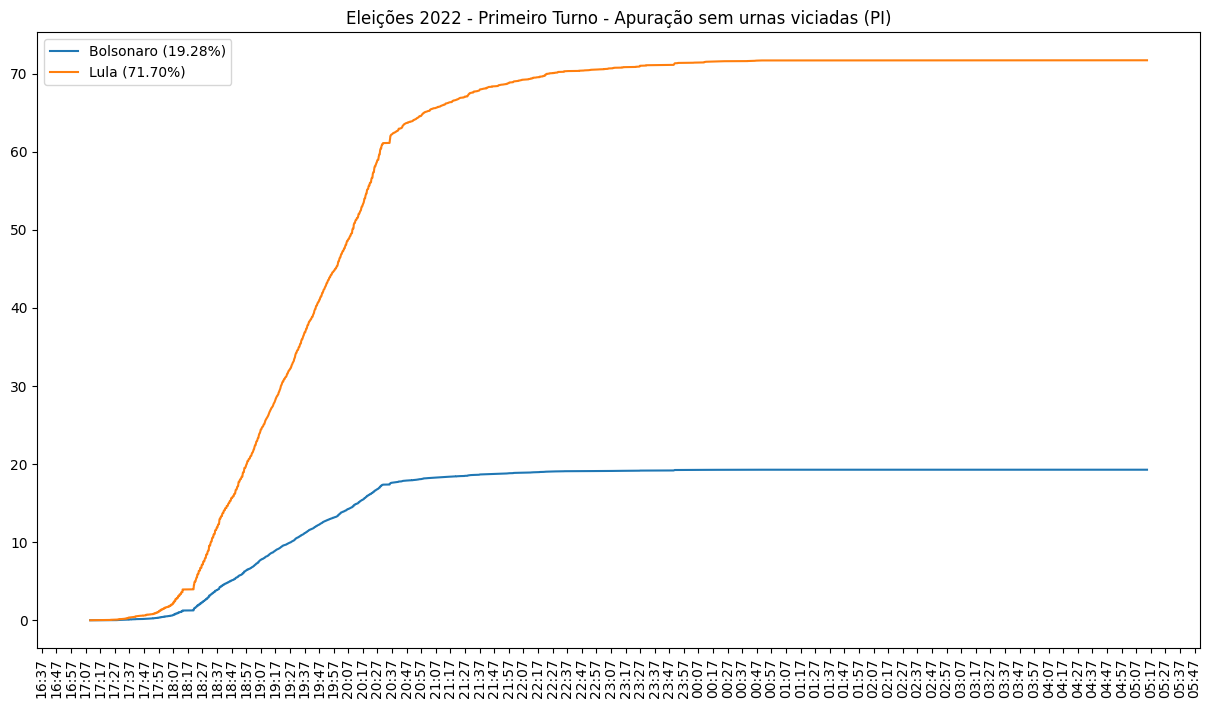

In [ ]:
total1pi_sub = df1pi_sub['QT_VOTOS'].sum()

df1pi_sub_13 = df1pi_sub[df1pi_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pi_sub_22 = df1pi_sub[df1pi_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pi_sub_13.set_index('data_hora', inplace=True)
df1pi_sub_22.set_index('data_hora', inplace=True)

df1pi_sub_13.sort_index(inplace=True)
df1pi_sub_22.sort_index(inplace=True)

df1pi_sub_13['acumulados'] = df1pi_sub_13['QT_VOTOS'].cumsum()
df1pi_sub_22['acumulados'] = df1pi_sub_22['QT_VOTOS'].cumsum()

df1pi_sub_13['acumulados'] = (df1pi_sub_13['acumulados'] / total1pi_sub) * 100
df1pi_sub_22['acumulados'] = (df1pi_sub_22['acumulados'] / total1pi_sub) * 100
total1pi_sub = df1pi_sub['QT_VOTOS'].sum()

df1pi_sub_13 = df1pi_sub[df1pi_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pi_sub_22 = df1pi_sub[df1pi_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pi_sub_13.set_index('data_hora', inplace=True)
df1pi_sub_22.set_index('data_hora', inplace=True)

df1pi_sub_13.sort_index(inplace=True)
df1pi_sub_22.sort_index(inplace=True)

df1pi_sub_13['acumulados'] = df1pi_sub_13['QT_VOTOS'].cumsum()
df1pi_sub_22['acumulados'] = df1pi_sub_22['QT_VOTOS'].cumsum()

df1pi_sub_13['acumulados'] = (df1pi_sub_13['acumulados'] / total1pi_sub) * 100
df1pi_sub_22['acumulados'] = (df1pi_sub_22['acumulados'] / total1pi_sub) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pi_sub_22.index, df1pi_sub_22['acumulados'], label=f"Bolsonaro ({df1pi_sub_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pi_sub_13.index, df1pi_sub_13['acumulados'], label=f"Lula ({df1pi_sub_13['acumulados'].iloc[-1]:.2f}%)")

# date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas (PI)')
ax.legend()

##### 1.1.1.3. MARANHÃO

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


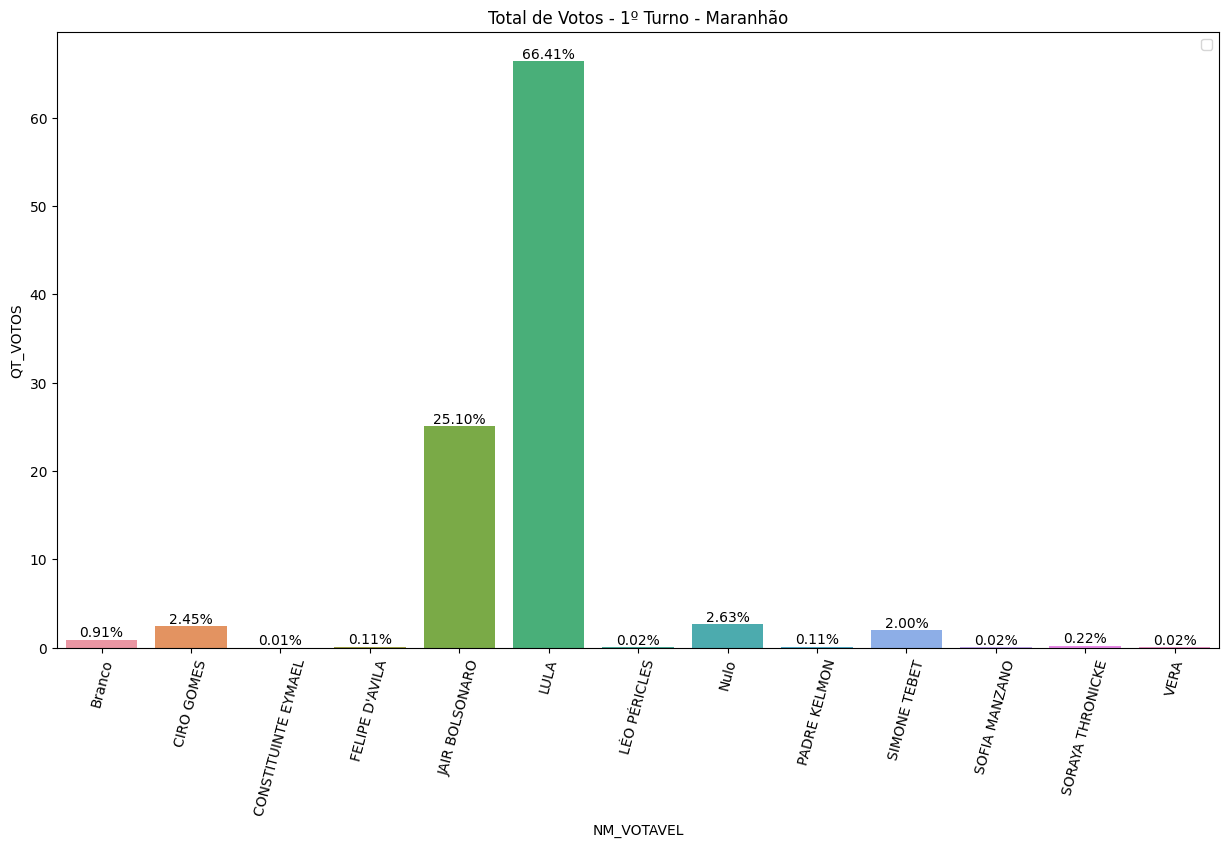

In [ ]:
# Graficos - Total no 1º turno
total1ma = df1ma['QT_VOTOS'].sum()

df1ma_order = df1ma.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1ma_order['QT_VOTOS'] = (df1ma_order['QT_VOTOS'] / total1ma) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1ma_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Maranhão')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

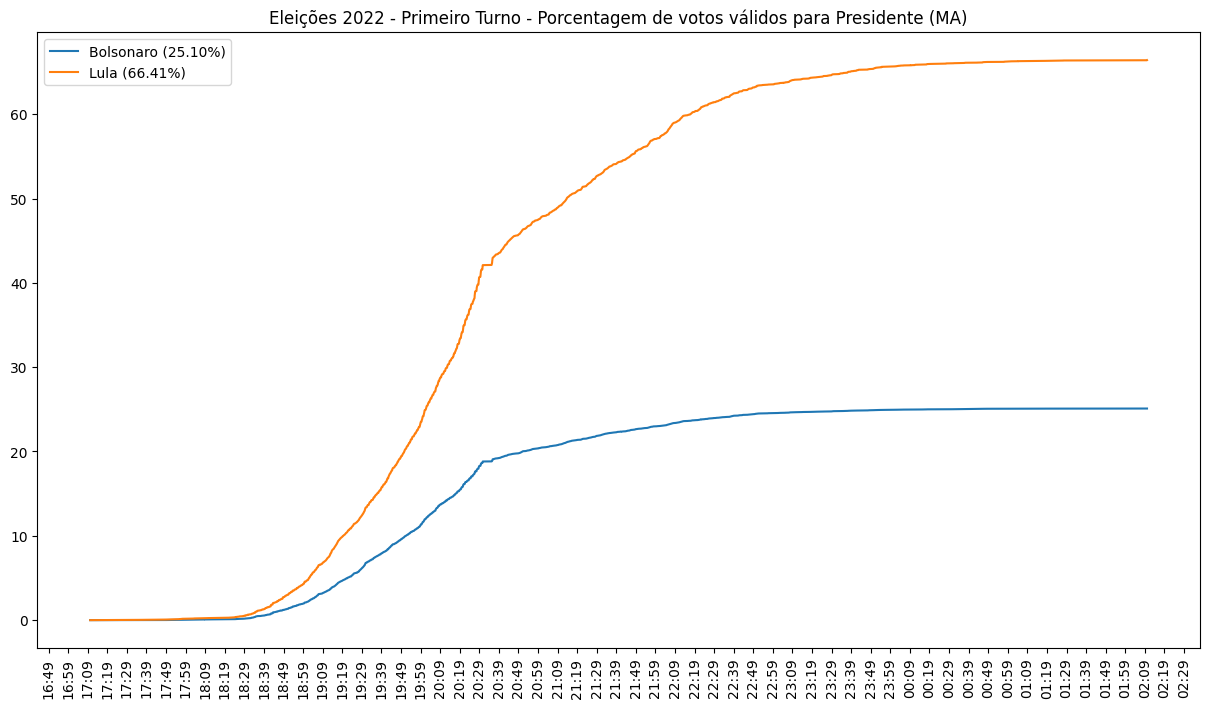

In [ ]:
# Total de votos acumulados

df1ma_13 = df1ma[df1ma['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1ma_22 = df1ma[df1ma['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1ma_13.set_index('data_hora', inplace=True)
df1ma_22.set_index('data_hora', inplace=True)

df1ma_13.sort_index(inplace=True)
df1ma_22.sort_index(inplace=True)

df1ma_13['acumulados'] = df1ma_13['QT_VOTOS'].cumsum()
df1ma_22['acumulados'] = df1ma_22['QT_VOTOS'].cumsum()

df1ma_13['acumulados'] = (df1ma_13['acumulados'] / total1ma) * 100
df1ma_22['acumulados'] = (df1ma_22['acumulados'] / total1ma) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1ma_22.index, df1ma_22['acumulados'], label=f"Bolsonaro ({df1ma_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1ma_13.index, df1ma_13['acumulados'], label=f"Lula ({df1ma_13['acumulados'].iloc[-1]:.2f}%)")

date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (MA)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1ma_urnas = df1ma[df1ma['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ma_urnas[df1ma_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ma_urnas[df1ma_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 49


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1ma_urnas_22 = df1ma_urnas[df1ma_urnas['NR_VOTAVEL'] == 22]
df1ma_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
284282                    TIMBIRAS        7       362              1180
300743                     COROATÁ        8       146              1317
385062                    SÃO LUÍS       10       844              2054
401863                    ARAIOSES       12       129              1660
434520                    CURURUPU       14        78              1384
451174          ITAIPAVA DO GRAJAÚ       15       314              1279
546326                       TIMON       19       570              1945
563822                      CAJARI       20       213              1309
570371   SÃO FRANCISCO DO MARANHÃO       21        64              1236
588089              BARRA DO CORDA       23        19              1082
592447              BARRA DO CORDA       23       166              1864
634523                    CAROLINA       26        38              1244
644716                       ARARI       27        80              1236
668157                     COLINAS       29        90              1350
676724                   GUIMARÃES       30        74              1228
679306                    MIRINZAL       30       119              1210
693492                       ICATU       31       184              1520
707574     SANTO AMARO DO MARANHÃO       32       138              1244
708091          HUMBERTO DE CAMPOS       32       147              1490
767952                   PARNARAMA       36        69              1171
770634                   PARNARAMA       36       128              1368
810415                     TURIAÇU       39       127              1309
831541                      TUTÓIA       40       239              1953
832509               PAULINO NEVES       40       263              1392
858570                  CHAPADINHA       42       196              1970
1000043          PRESIDENTE VARGAS       50       183              1252
1026018         SÃO JOÃO DOS PATOS       53        46              1201
1044595           PRESIDENTE DUTRA       54       193              1457
1051701                 CARUTAPERA       55        69              1376
1069273               BARREIRINHAS       56       172              1899
1072727               BARREIRINHAS       56       221              2100
1074387               BARREIRINHAS       56       239              2178
1133827            POÇÃO DE PEDRAS       61       152              1481
1146281           SÃO JOÃO BATISTA       63        78              1236
1222204                   PERITORÓ       68        97              1171
1291634  SÃO BENEDITO DO RIO PRETO       73        67              1279
1460238               SANTA HELENA       83       101              1309
1463121               SANTA HELENA       83       144              1414
1463235               SANTA HELENA       83       146              1430
1463927               SANTA HELENA       83       157              1503
1464682               SANTA HELENA       83       172              1554
1465310                 TURILÂNDIA       83       183              1333
1662322            FERNANDO FALCÃO       97       184              1082
1663669            FERNANDO FALCÃO       97       207              1155
1745519          PRESIDENTE SARNEY      106       224              1120
1752112        SERRANO DO MARANHÃO      107        87              1120
1756195        SERRANO DO MARANHÃO      107       169              1228
1783328                     MORROS      110       218              1180
1783725                     MORROS      110       224              1244

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

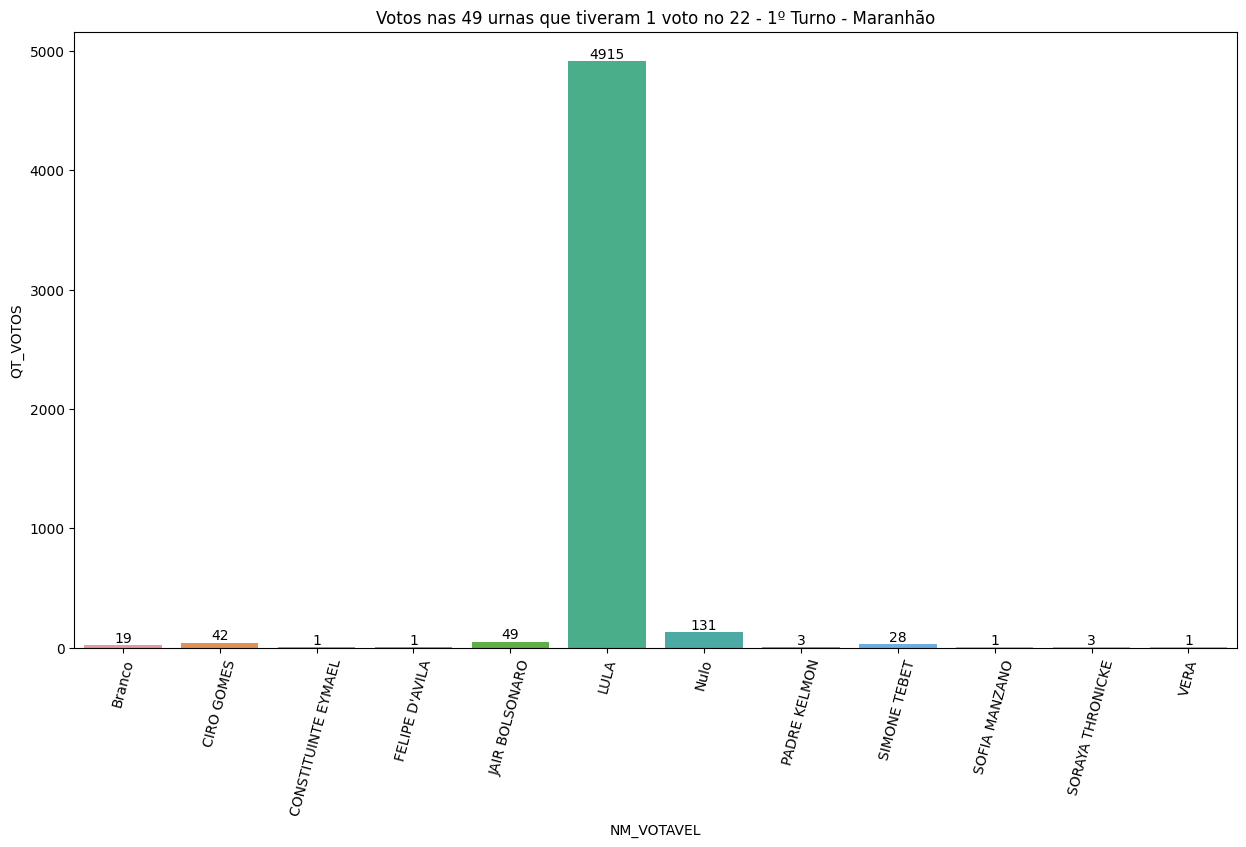

In [ ]:

df_soma = None

for i in range(len(df1ma_urnas_22)):
    cidade = df1ma_urnas_22.iloc[i, df1ma_urnas_22.columns.get_loc('CD_MUNICIPIO')]
    zona = df1ma_urnas_22.iloc[i, df1ma_urnas_22.columns.get_loc('NR_ZONA')]
    secao = df1ma_urnas_22.iloc[i, df1ma_urnas_22.columns.get_loc('NR_SECAO')]
    local = df1ma_urnas_22.iloc[i, df1ma_urnas_22.columns.get_loc('NR_LOCAL_VOTACAO')]

    df_temp = df1ma[(df1ma['CD_MUNICIPIO'] == cidade) &
                    (df1ma['NR_ZONA'] == zona) &
                    (df1ma['NR_SECAO'] == secao) &
                    (df1ma['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

    if (df_soma is not None):
        df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
    else:        
        df_soma = df_temp

df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df_soma)

ax.bar_label(ax.containers[0])
ax.set(title=f'Votos nas {df1ma_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - Maranhão')

for item in ax.get_xticklabels():
    item.set_rotation(75)

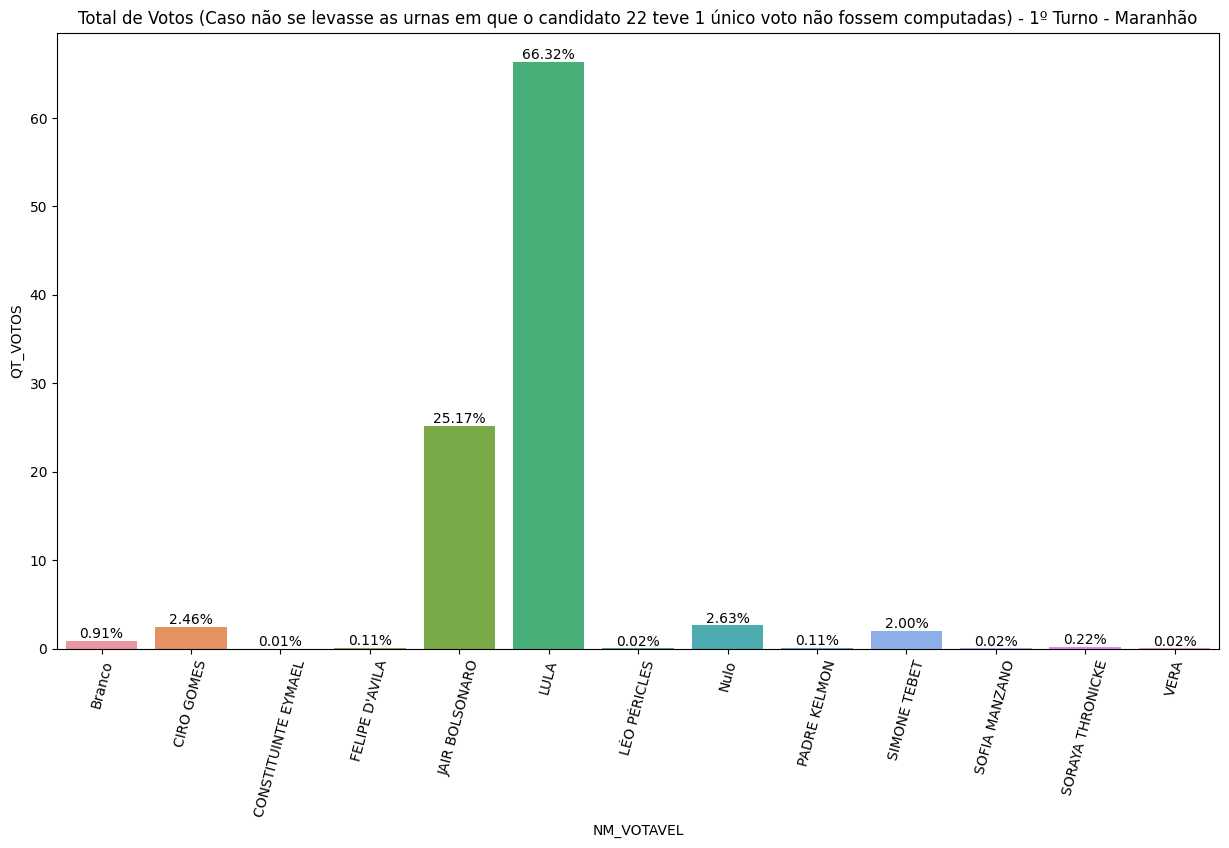

In [ ]:
# Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

df1ma_sub = df1ma[~((df1ma['CD_MUNICIPIO'].isin(df1ma_urnas_22['CD_MUNICIPIO'])) & 
                    (df1ma['NR_ZONA'].isin(df1ma_urnas_22['NR_ZONA'])) & 
                    (df1ma['NR_SECAO'].isin(df1ma_urnas_22['NR_SECAO'])) & 
                    (df1ma['NR_LOCAL_VOTACAO'].isin(df1ma_urnas_22['NR_LOCAL_VOTACAO'])))]


total1ma_sub = df1ma_sub['QT_VOTOS'].sum()

df1ma_sub_order = df1ma_sub.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1ma_sub_order['QT_VOTOS'] = (df1ma_sub_order['QT_VOTOS'] / total1ma_sub) * 100

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1ma_sub_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno - Maranhão')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

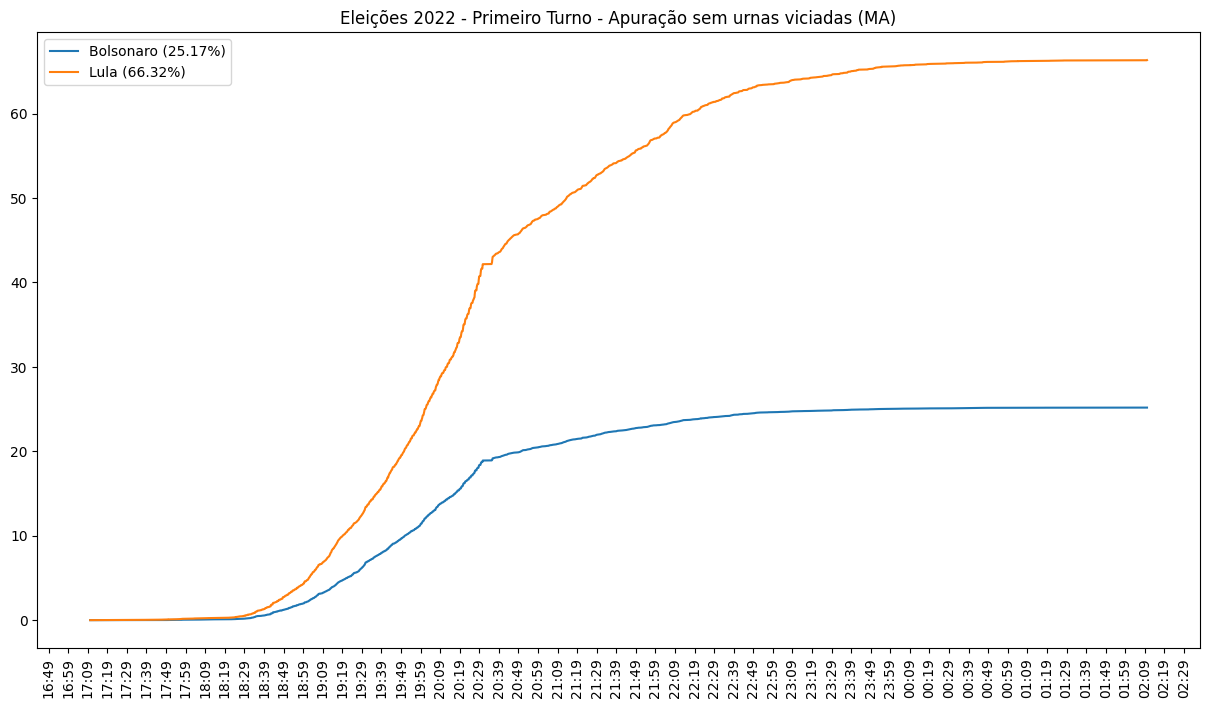

In [ ]:

total1ma_sub = df1ma_sub['QT_VOTOS'].sum()

df1ma_sub_13 = df1ma_sub[df1ma_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1ma_sub_22 = df1ma_sub[df1ma_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1ma_sub_13.set_index('data_hora', inplace=True)
df1ma_sub_22.set_index('data_hora', inplace=True)

df1ma_sub_13.sort_index(inplace=True)
df1ma_sub_22.sort_index(inplace=True)

df1ma_sub_13['acumulados'] = df1ma_sub_13['QT_VOTOS'].cumsum()
df1ma_sub_22['acumulados'] = df1ma_sub_22['QT_VOTOS'].cumsum()

df1ma_sub_13['acumulados'] = (df1ma_sub_13['acumulados'] / total1ma_sub) * 100
df1ma_sub_22['acumulados'] = (df1ma_sub_22['acumulados'] / total1ma_sub) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1ma_sub_22.index, df1ma_sub_22['acumulados'], label=f"Bolsonaro ({df1ma_sub_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1ma_sub_13.index, df1ma_sub_13['acumulados'], label=f"Lula ({df1ma_sub_13['acumulados'].iloc[-1]:.2f}%)")

# date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas (MA)')
ax.legend()

##### 1.1.1.4. CEARÁ

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


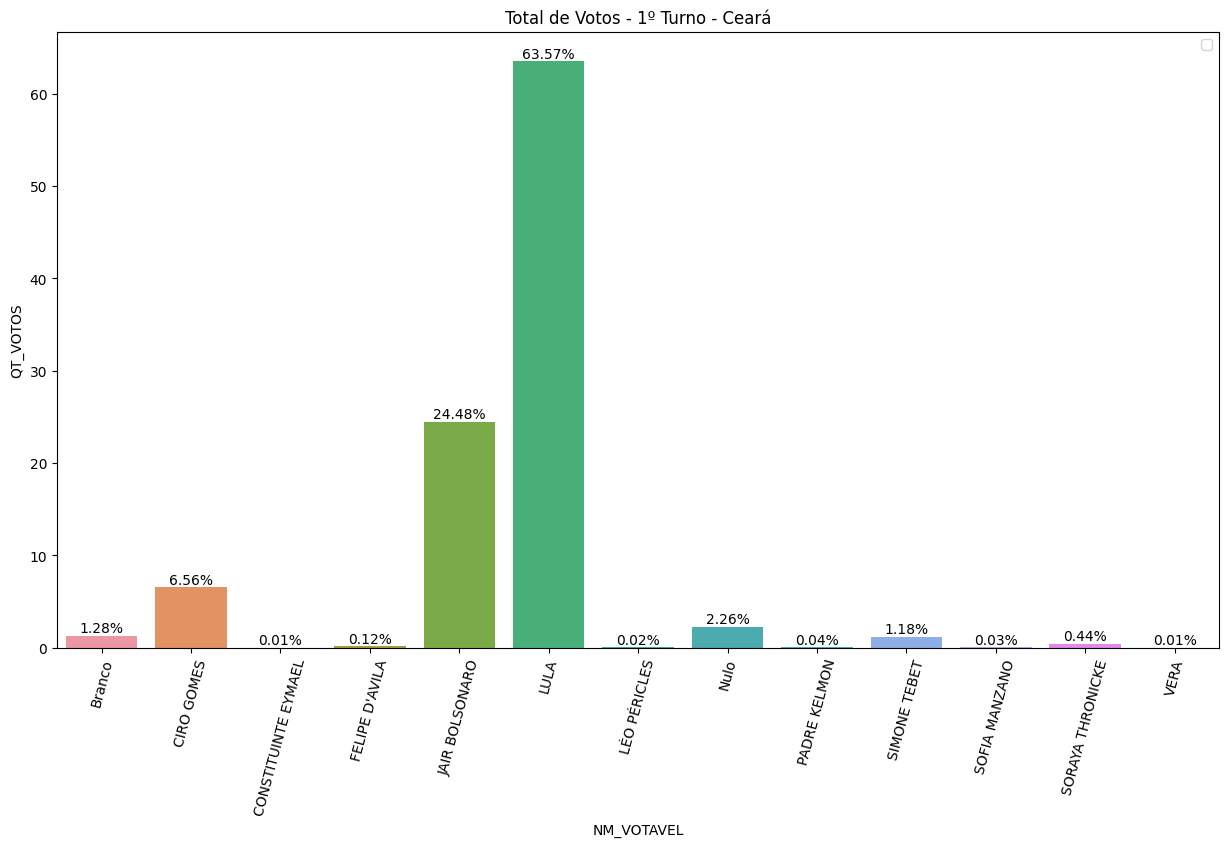

In [ ]:
# Graficos - Total no 1º turno
total1ce = df1ce['QT_VOTOS'].sum()

df1ce_order = df1ce.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1ce_order['QT_VOTOS'] = (df1ce_order['QT_VOTOS'] / total1ce) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1ce_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Ceará')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

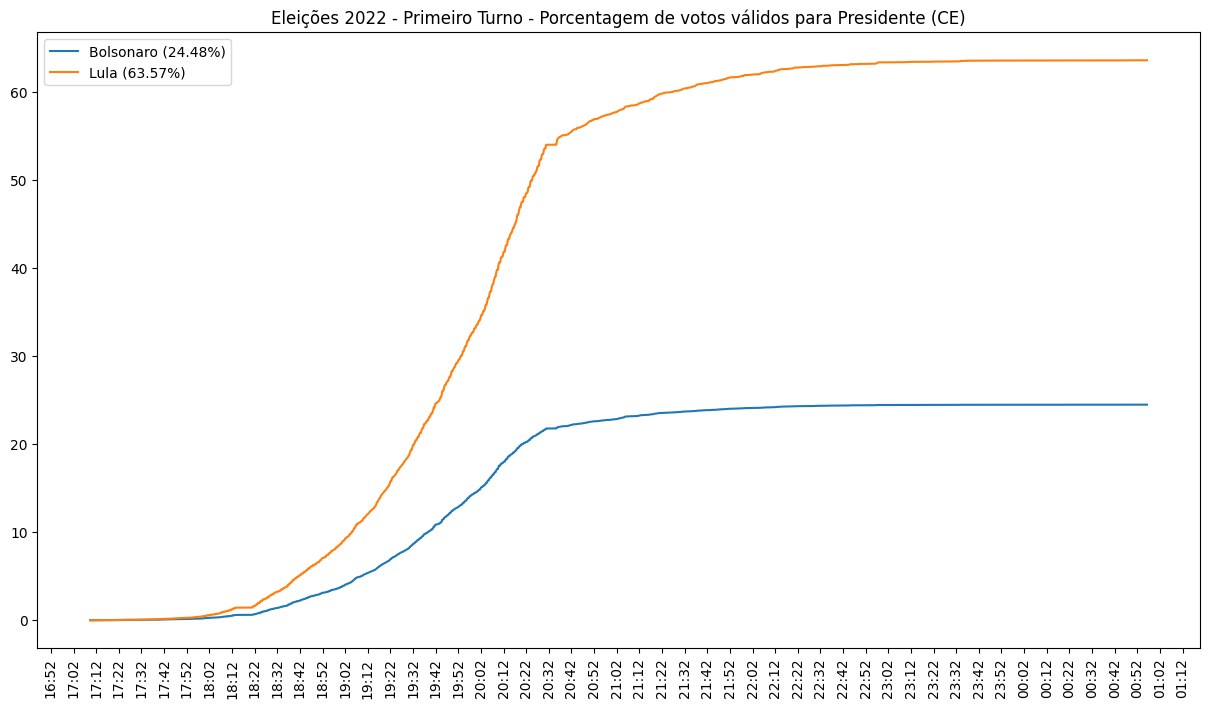

In [ ]:
# Total de votos acumulados

df1ce_13 = df1ce[df1ce['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1ce_22 = df1ce[df1ce['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1ce_13.set_index('data_hora', inplace=True)
df1ce_22.set_index('data_hora', inplace=True)

df1ce_13.sort_index(inplace=True)
df1ce_22.sort_index(inplace=True)

df1ce_13['acumulados'] = df1ce_13['QT_VOTOS'].cumsum()
df1ce_22['acumulados'] = df1ce_22['QT_VOTOS'].cumsum()

df1ce_13['acumulados'] = (df1ce_13['acumulados'] / total1ce) * 100
df1ce_22['acumulados'] = (df1ce_22['acumulados'] / total1ce) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1ce_22.index, df1ce_22['acumulados'], label=f"Bolsonaro ({df1ce_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1ce_13.index, df1ce_13['acumulados'], label=f"Lula ({df1ce_13['acumulados'].iloc[-1]:.2f}%)")

date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (CE)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1ce_urnas = df1ce[df1ce['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ce_urnas[df1ce_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ce_urnas[df1ce_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 21


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1ce_urnas_22 = df1ce_urnas[df1ce_urnas['NR_VOTAVEL'] == 22]
df1ce_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
362842        QUIXERAMOBIM       11        64              1538
374945        QUIXERAMOBIM       11       259              2887
520841                TAUÁ       19       236              2097
643530         MARTINÓPOLE       25       233              1120
687497               CRATO       27       360              1872
896988             SALITRE       38       132              1201
905571       INDEPENDÊNCIA       39       215              1953
918373             PORANGA       40       208              1368
1022200        NOVA RUSSAS       48       201              1970
1160606       PEDRA BRANCA       59       114              1821
1162476       PEDRA BRANCA       59       143              1929
1218126         BOA VIAGEM       63       215              2097
1219623           MADALENA       63       237              1350
1283609            POTENGI       68        54              1139
1352367             CROATÁ       74       156              1791
1375505            MAURITI       76       140              2038
1424038             PACUJÁ       79       249              1112
1756910             BAIXIO       92        96              1147
1806609          FORTALEZA       93       309              1392
1965191       NOVO ORIENTE       99       140              1333
2519119  JUAZEIRO DO NORTE      119       267              1228

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

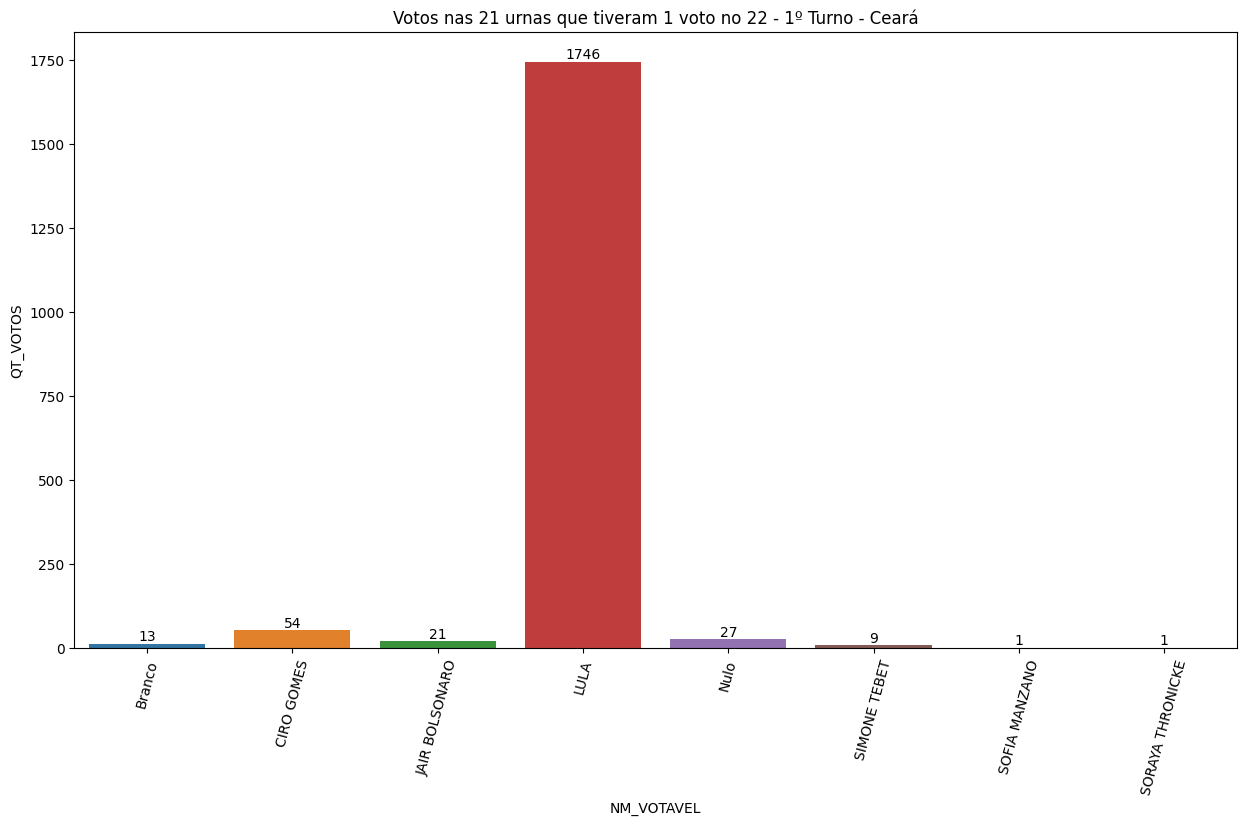

In [ ]:

df_soma = None

for i in range(len(df1ce_urnas_22)):
    cidade = df1ce_urnas_22.iloc[i, df1ce_urnas_22.columns.get_loc('CD_MUNICIPIO')]
    zona = df1ce_urnas_22.iloc[i, df1ce_urnas_22.columns.get_loc('NR_ZONA')]
    secao = df1ce_urnas_22.iloc[i, df1ce_urnas_22.columns.get_loc('NR_SECAO')]
    local = df1ce_urnas_22.iloc[i, df1ce_urnas_22.columns.get_loc('NR_LOCAL_VOTACAO')]

    df_temp = df1ce[(df1ce['CD_MUNICIPIO'] == cidade) &
                    (df1ce['NR_ZONA'] == zona) &
                    (df1ce['NR_SECAO'] == secao) &
                    (df1ce['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

    if (df_soma is not None):
        df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
    else:        
        df_soma = df_temp

df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df_soma)

ax.bar_label(ax.containers[0])
ax.set(title=f'Votos nas {df1ce_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - Ceará')

for item in ax.get_xticklabels():
    item.set_rotation(75)

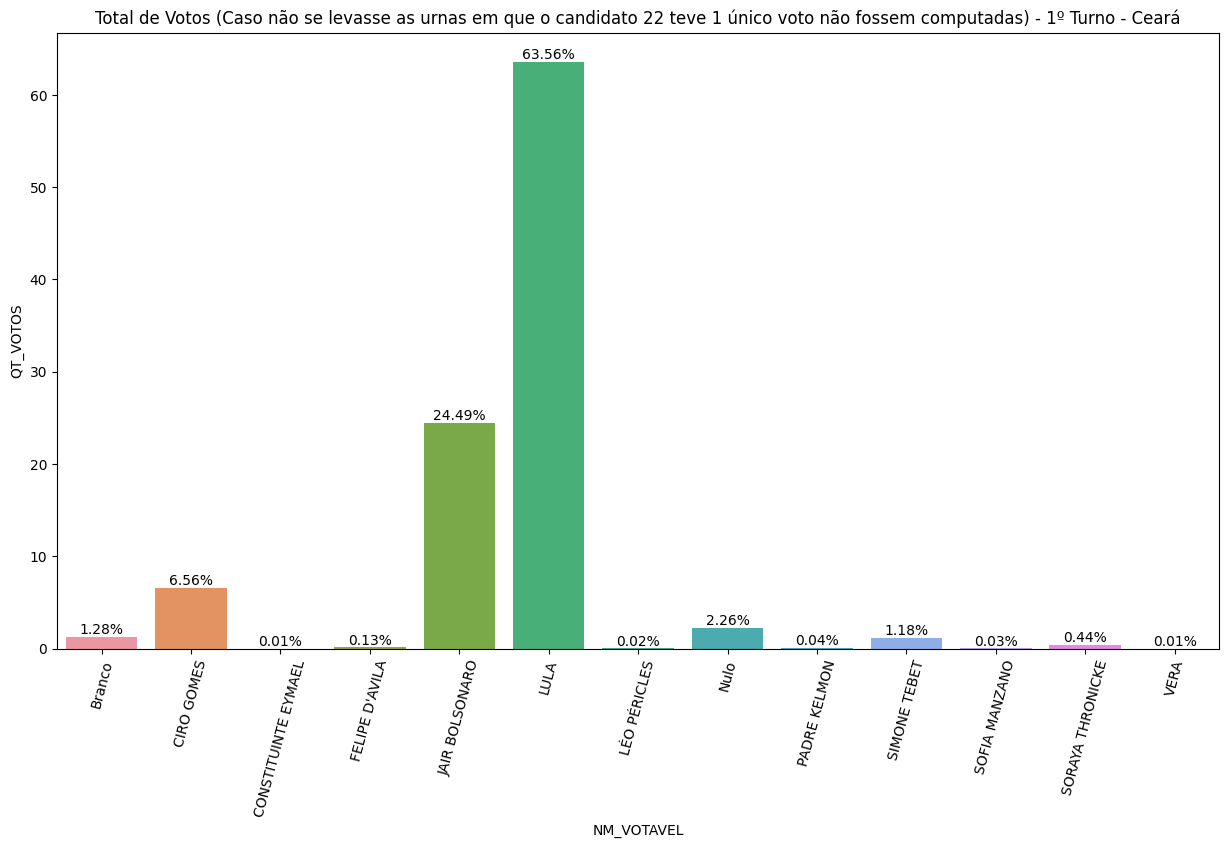

In [ ]:
# Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

df1ce_sub = df1ce[~((df1ce['CD_MUNICIPIO'].isin(df1ce_urnas_22['CD_MUNICIPIO'])) & 
                    (df1ce['NR_ZONA'].isin(df1ce_urnas_22['NR_ZONA'])) & 
                    (df1ce['NR_SECAO'].isin(df1ce_urnas_22['NR_SECAO'])) & 
                    (df1ce['NR_LOCAL_VOTACAO'].isin(df1ce_urnas_22['NR_LOCAL_VOTACAO'])))]


total1ce_sub = df1ce_sub['QT_VOTOS'].sum()

df1ce_sub_order = df1ce_sub.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1ce_sub_order['QT_VOTOS'] = (df1ce_sub_order['QT_VOTOS'] / total1ce_sub) * 100

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1ce_sub_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno - Ceará')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

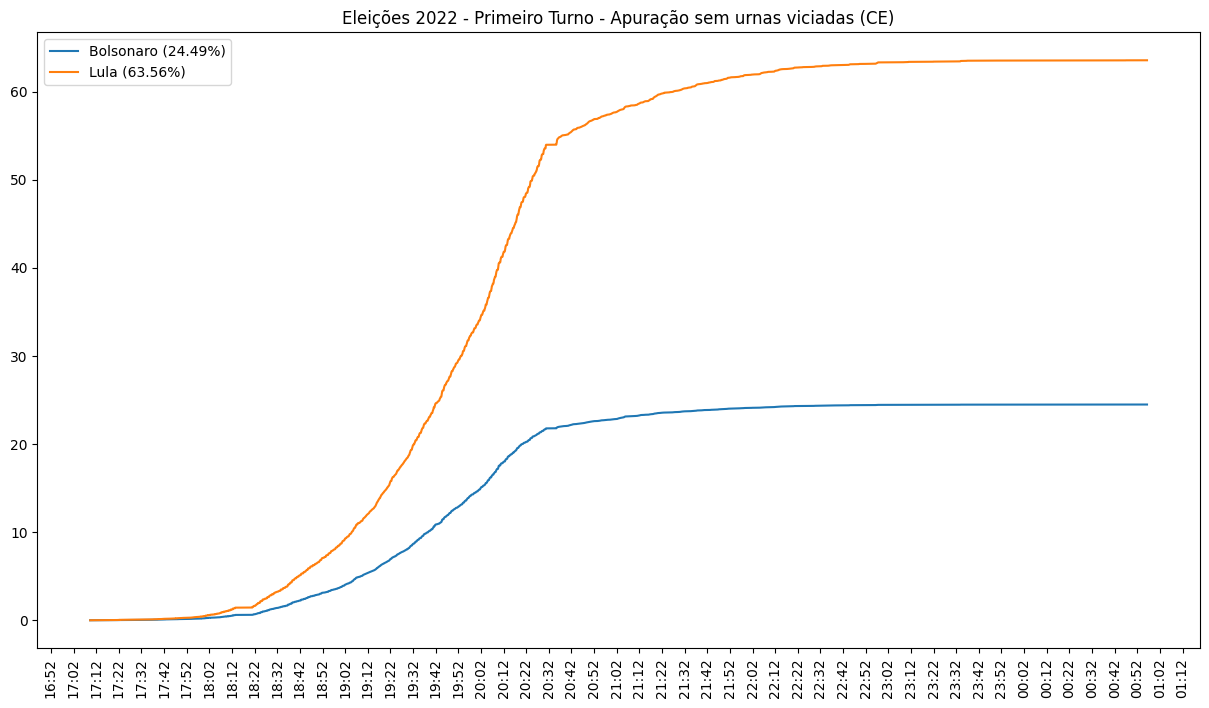

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

total1ce_sub = df1ce_sub['QT_VOTOS'].sum()

df1ce_sub_13 = df1ce_sub[df1ce_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1ce_sub_22 = df1ce_sub[df1ce_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1ce_sub_13.set_index('data_hora', inplace=True)
df1ce_sub_22.set_index('data_hora', inplace=True)

df1ce_sub_13.sort_index(inplace=True)
df1ce_sub_22.sort_index(inplace=True)

df1ce_sub_13['acumulados'] = df1ce_sub_13['QT_VOTOS'].cumsum()
df1ce_sub_22['acumulados'] = df1ce_sub_22['QT_VOTOS'].cumsum()

df1ce_sub_13['acumulados'] = (df1ce_sub_13['acumulados'] / total1ce_sub) * 100
df1ce_sub_22['acumulados'] = (df1ce_sub_22['acumulados'] / total1ce_sub) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1ce_sub_22.index, df1ce_sub_22['acumulados'], label=f"Bolsonaro ({df1ce_sub_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1ce_sub_13.index, df1ce_sub_13['acumulados'], label=f"Lula ({df1ce_sub_13['acumulados'].iloc[-1]:.2f}%)")

# date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas (CE)')
ax.legend()

##### 1.1.1.5. RIO GRANDE DO NORTE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


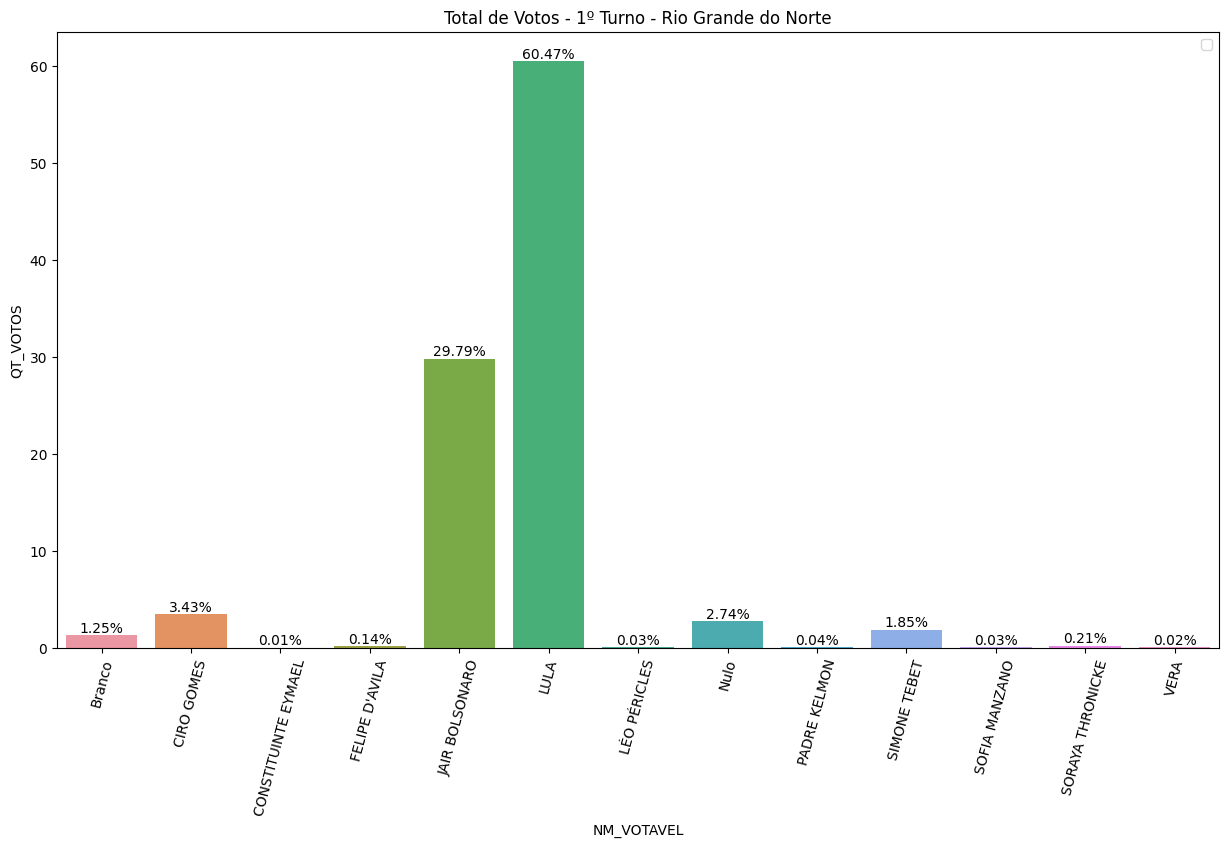

In [ ]:
# Graficos - Total no 1º turno
total1rn = df1rn['QT_VOTOS'].sum()

df1rn_order = df1rn.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1rn_order['QT_VOTOS'] = (df1rn_order['QT_VOTOS'] / total1rn) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1rn_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Rio Grande do Norte')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

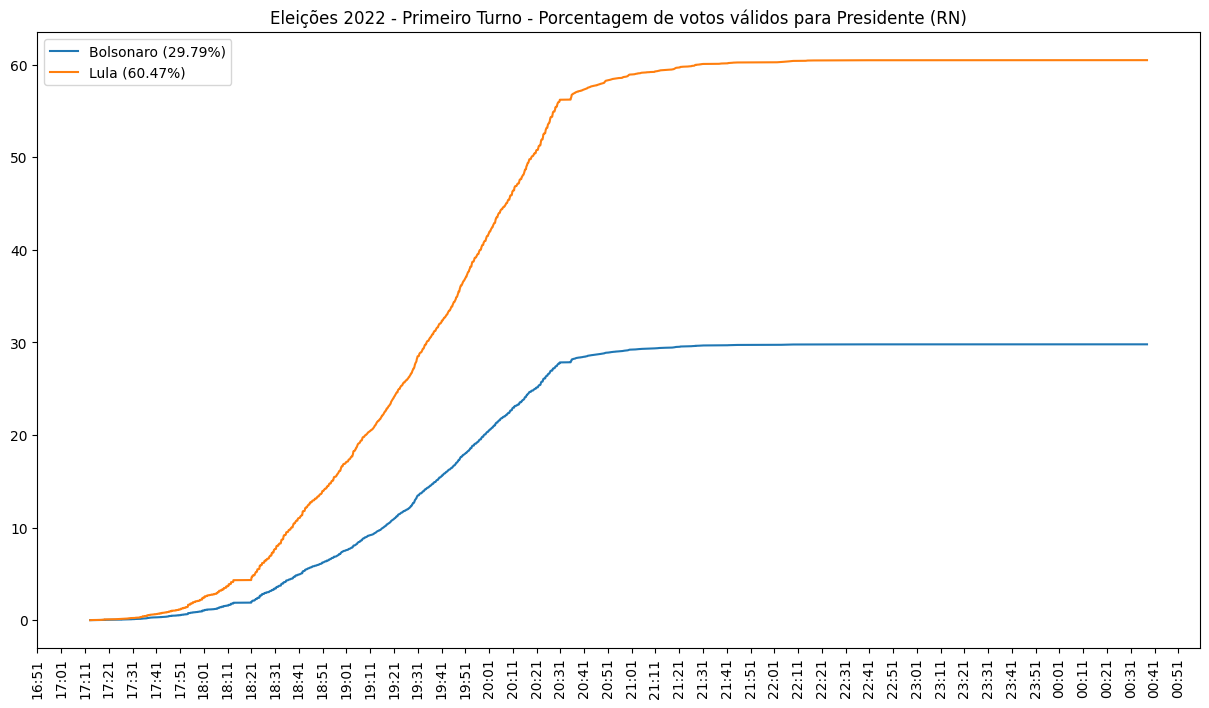

In [ ]:
# Total de votos acumulados

df1rn_13 = df1rn[df1rn['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1rn_22 = df1rn[df1rn['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1rn_13.set_index('data_hora', inplace=True)
df1rn_22.set_index('data_hora', inplace=True)

df1rn_13.sort_index(inplace=True)
df1rn_22.sort_index(inplace=True)

df1rn_13['acumulados'] = df1rn_13['QT_VOTOS'].cumsum()
df1rn_22['acumulados'] = df1rn_22['QT_VOTOS'].cumsum()

df1rn_13['acumulados'] = (df1rn_13['acumulados'] / total1rn) * 100
df1rn_22['acumulados'] = (df1rn_22['acumulados'] / total1rn) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1rn_22.index, df1rn_22['acumulados'], label=f"Bolsonaro ({df1rn_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1rn_13.index, df1rn_13['acumulados'], label=f"Lula ({df1rn_13['acumulados'].iloc[-1]:.2f}%)")

date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (RN)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1rn_urnas = df1rn[df1rn['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1rn_urnas[df1rn_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1rn_urnas[df1rn_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 0


##### 1.1.1.6. PARAÍBA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


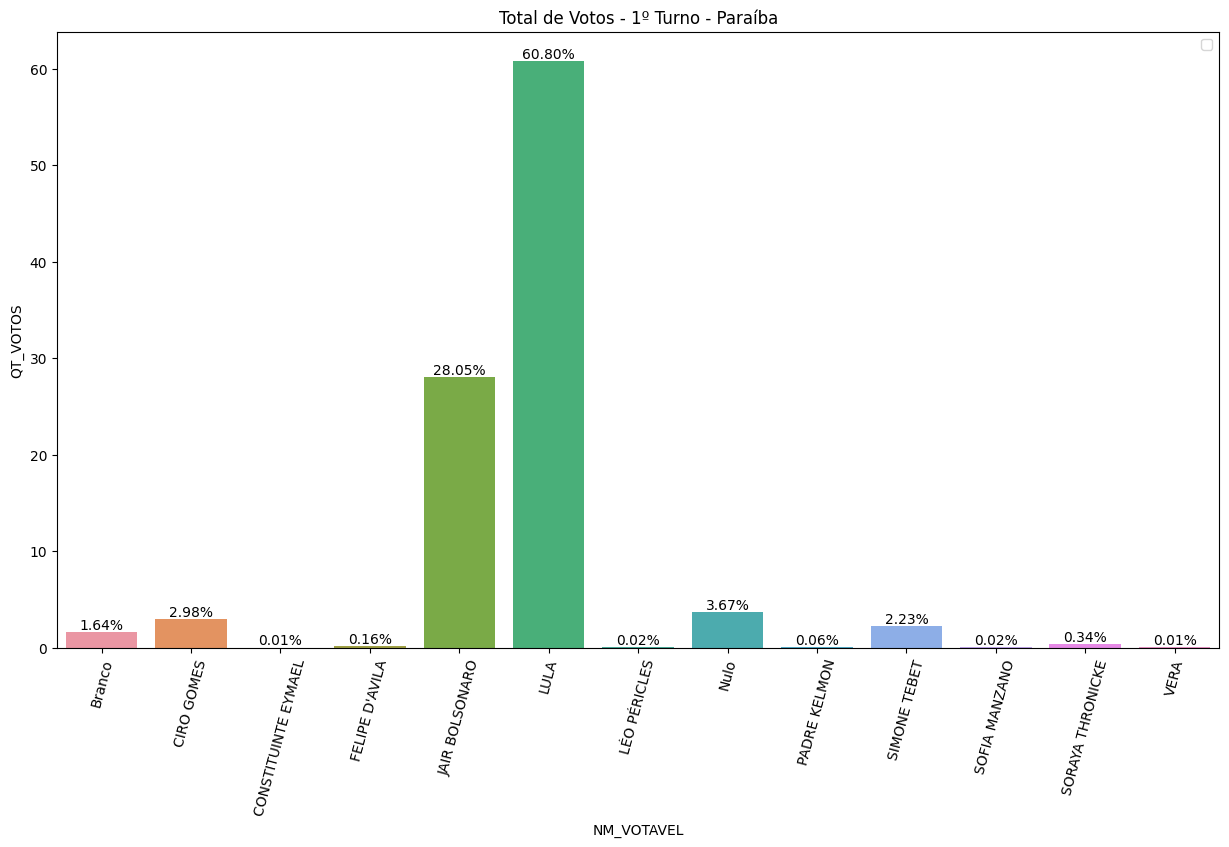

In [ ]:
# Graficos - Total no 1º turno
total1pb = df1pb['QT_VOTOS'].sum()

df1pb_order = df1pb.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pb_order['QT_VOTOS'] = (df1pb_order['QT_VOTOS'] / total1pb) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pb_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Paraíba')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

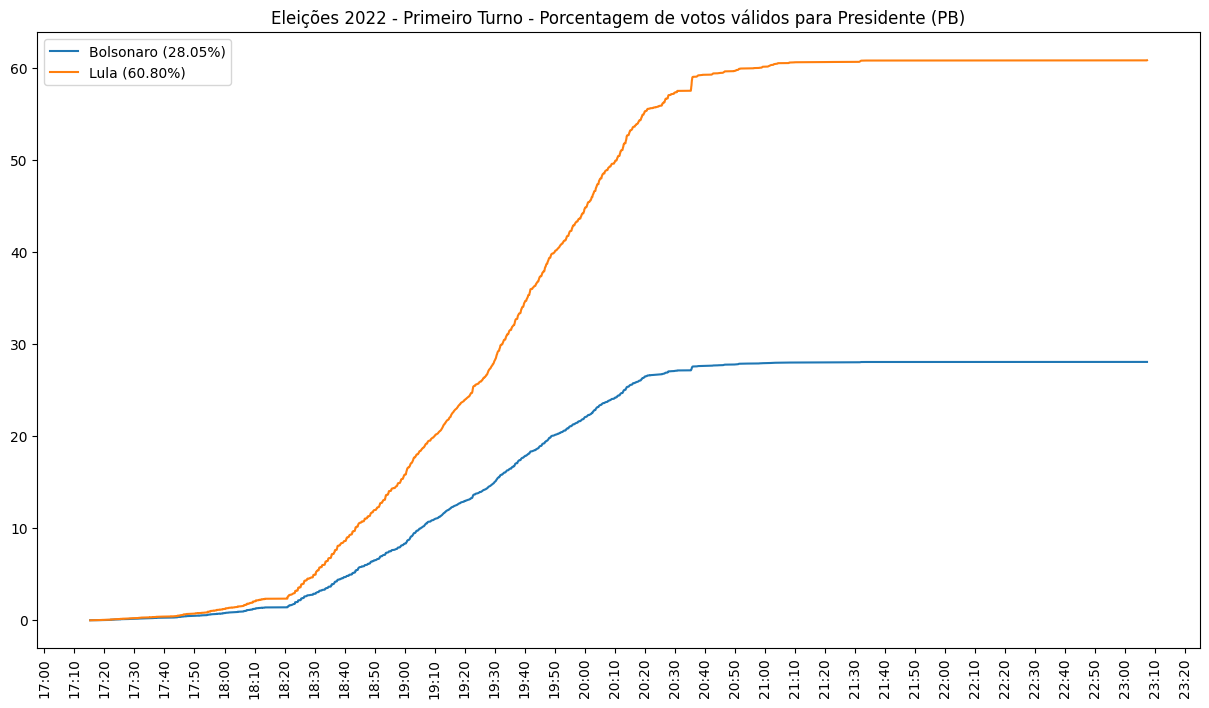

In [ ]:
# Total de votos acumulados

df1pb_13 = df1pb[df1pb['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pb_22 = df1pb[df1pb['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pb_13.set_index('data_hora', inplace=True)
df1pb_22.set_index('data_hora', inplace=True)

df1pb_13.sort_index(inplace=True)
df1pb_22.sort_index(inplace=True)

df1pb_13['acumulados'] = df1pb_13['QT_VOTOS'].cumsum()
df1pb_22['acumulados'] = df1pb_22['QT_VOTOS'].cumsum()

df1pb_13['acumulados'] = (df1pb_13['acumulados'] / total1pb) * 100
df1pb_22['acumulados'] = (df1pb_22['acumulados'] / total1pb) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pb_22.index, df1pb_22['acumulados'], label=f"Bolsonaro ({df1pb_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pb_13.index, df1pb_13['acumulados'], label=f"Lula ({df1pb_13['acumulados'].iloc[-1]:.2f}%)")

date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (PB)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1pb_urnas = df1pb[df1pb['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1pb_urnas[df1pb_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1pb_urnas[df1pb_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 3


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1pb_urnas_22 = df1pb_urnas[df1pb_urnas['NR_VOTAVEL'] == 22]
df1pb_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
491588          TAVARES       34       237              1120
959137   CAMPINA GRANDE       72       384              1597
1041213     JOÃO PESSOA       76       389              1864

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

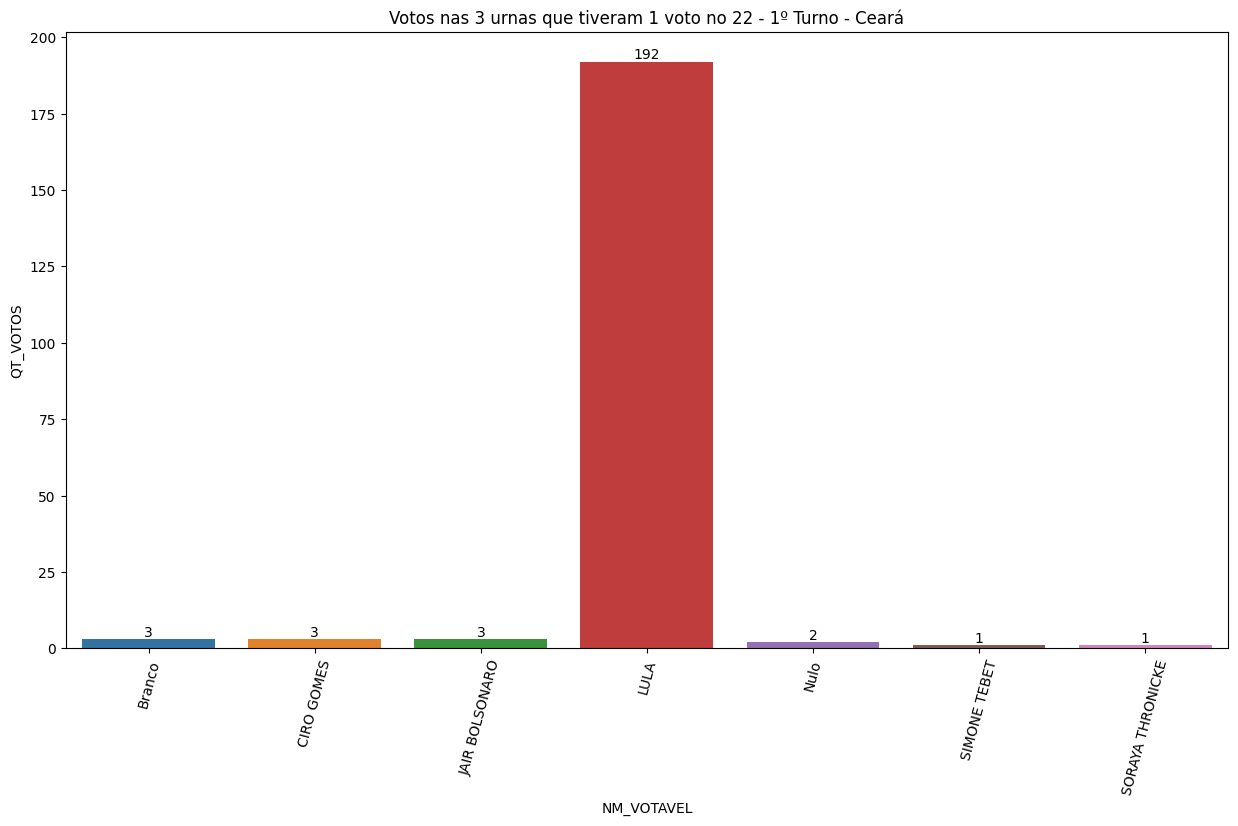

In [ ]:

df_soma = None

for i in range(len(df1pb_urnas_22)):
    cidade = df1pb_urnas_22.iloc[i, df1pb_urnas_22.columns.get_loc('CD_MUNICIPIO')]
    zona = df1pb_urnas_22.iloc[i, df1pb_urnas_22.columns.get_loc('NR_ZONA')]
    secao = df1pb_urnas_22.iloc[i, df1pb_urnas_22.columns.get_loc('NR_SECAO')]
    local = df1pb_urnas_22.iloc[i, df1pb_urnas_22.columns.get_loc('NR_LOCAL_VOTACAO')]

    df_temp = df1pb[(df1pb['CD_MUNICIPIO'] == cidade) &
                    (df1pb['NR_ZONA'] == zona) &
                    (df1pb['NR_SECAO'] == secao) &
                    (df1pb['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

    if (df_soma is not None):
        df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
    else:        
        df_soma = df_temp

df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df_soma)

ax.bar_label(ax.containers[0])
ax.set(title=f'Votos nas {df1pb_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - Ceará')

for item in ax.get_xticklabels():
    item.set_rotation(75)

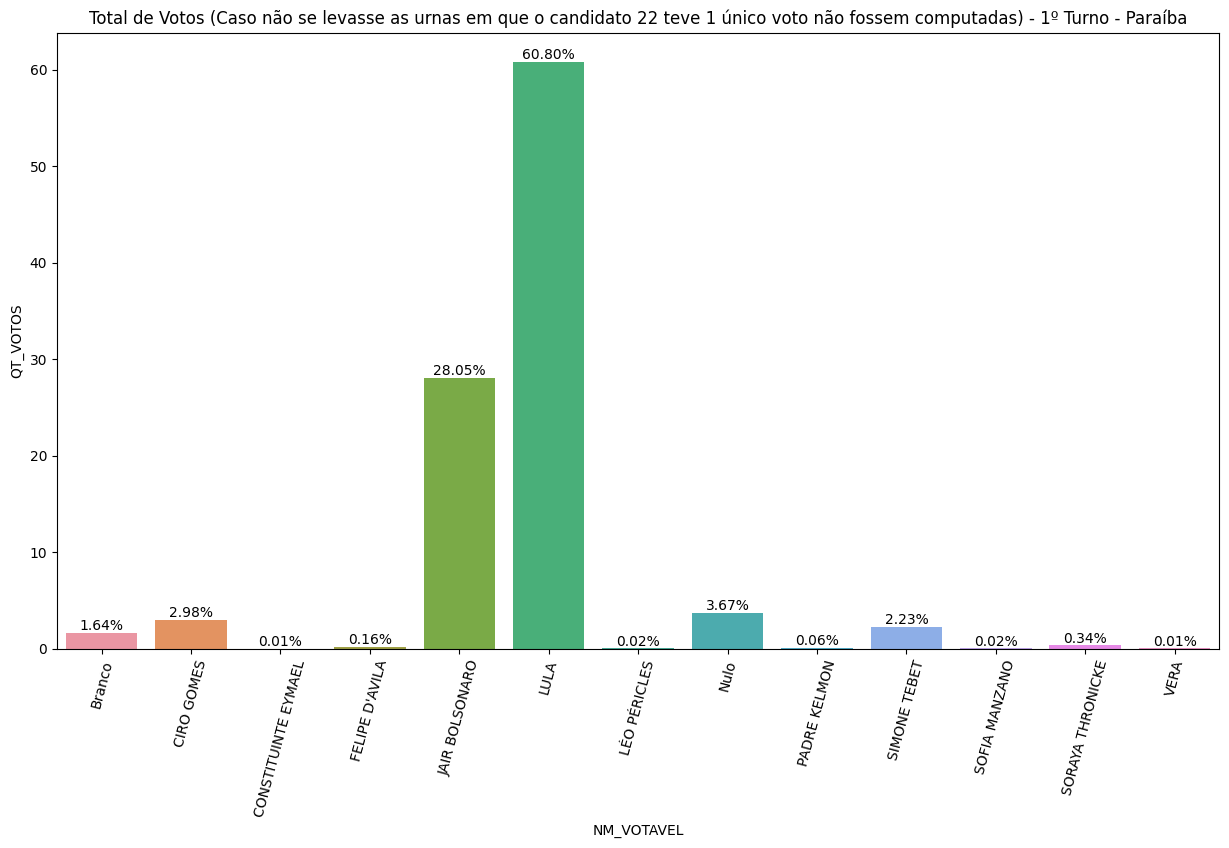

In [ ]:
# Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

df1pb_sub = df1pb[~((df1pb['CD_MUNICIPIO'].isin(df1ce_urnas_22['CD_MUNICIPIO'])) & 
                    (df1pb['NR_ZONA'].isin(df1ce_urnas_22['NR_ZONA'])) & 
                    (df1pb['NR_SECAO'].isin(df1ce_urnas_22['NR_SECAO'])) & 
                    (df1pb['NR_LOCAL_VOTACAO'].isin(df1ce_urnas_22['NR_LOCAL_VOTACAO'])))]


total1pb_sub = df1pb_sub['QT_VOTOS'].sum()

df1pb_sub_order = df1pb_sub.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pb_sub_order['QT_VOTOS'] = (df1pb_sub_order['QT_VOTOS'] / total1pb_sub) * 100

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pb_sub_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno - Paraíba')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

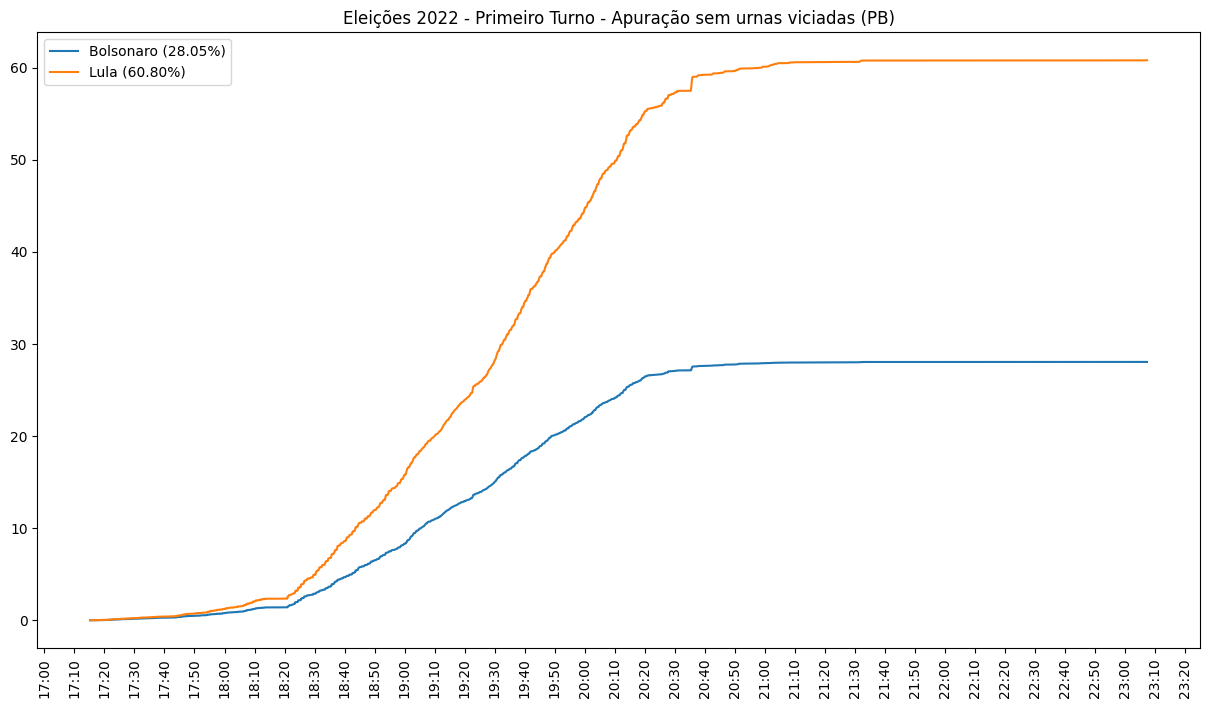

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

total1pb_sub = df1pb_sub['QT_VOTOS'].sum()

df1pb_sub_13 = df1pb_sub[df1pb_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pb_sub_22 = df1pb_sub[df1pb_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pb_sub_13.set_index('data_hora', inplace=True)
df1pb_sub_22.set_index('data_hora', inplace=True)

df1pb_sub_13.sort_index(inplace=True)
df1pb_sub_22.sort_index(inplace=True)

df1pb_sub_13['acumulados'] = df1pb_sub_13['QT_VOTOS'].cumsum()
df1pb_sub_22['acumulados'] = df1pb_sub_22['QT_VOTOS'].cumsum()

df1pb_sub_13['acumulados'] = (df1pb_sub_13['acumulados'] / total1pb_sub) * 100
df1pb_sub_22['acumulados'] = (df1pb_sub_22['acumulados'] / total1pb_sub) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pb_sub_22.index, df1pb_sub_22['acumulados'], label=f"Bolsonaro ({df1pb_sub_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pb_sub_13.index, df1pb_sub_13['acumulados'], label=f"Lula ({df1pb_sub_13['acumulados'].iloc[-1]:.2f}%)")

# date_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas (PB)')
ax.legend()

##### 1.1.1.7. PERNAMBUCO

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


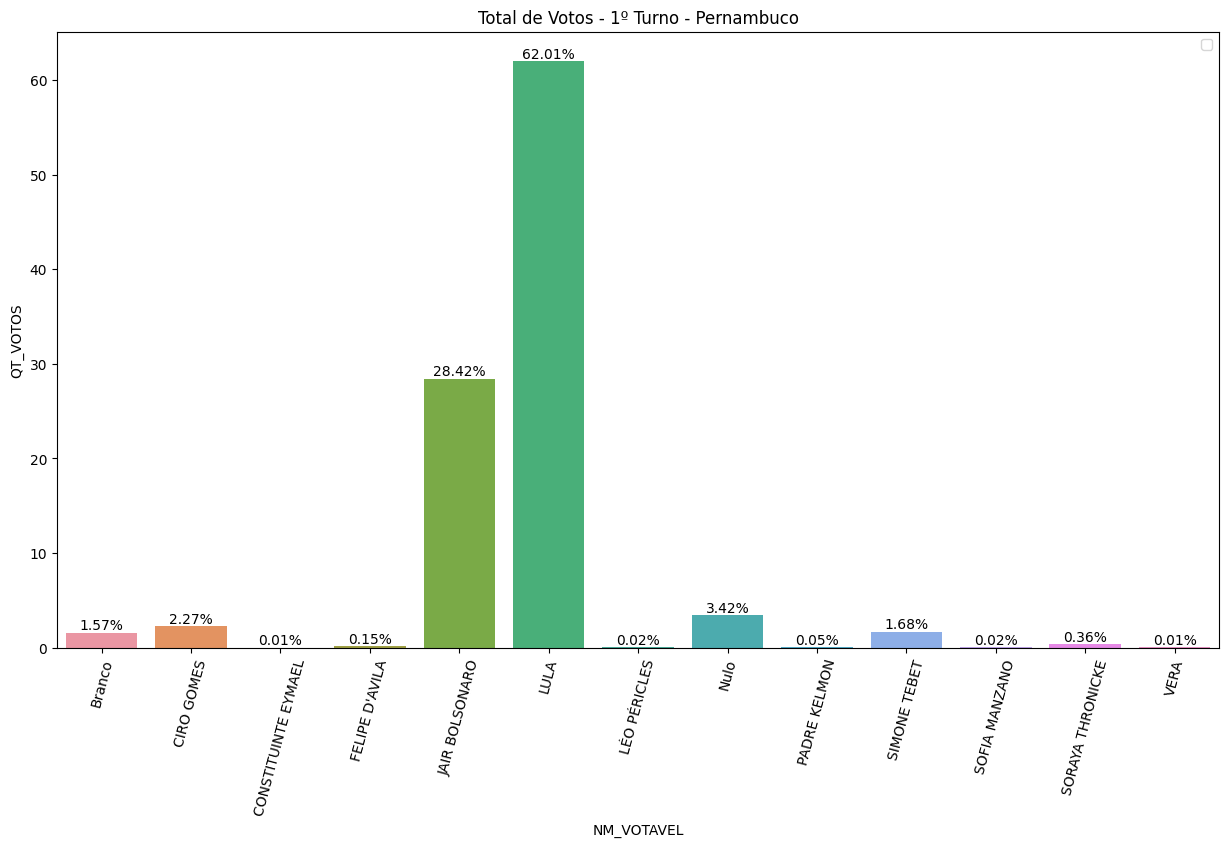

In [ ]:
# Graficos - Total no 1º turno
total1pe = df1pe['QT_VOTOS'].sum()

df1pe_order = df1pe.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pe_order['QT_VOTOS'] = (df1pe_order['QT_VOTOS'] / total1pe) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pe_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Pernambuco')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

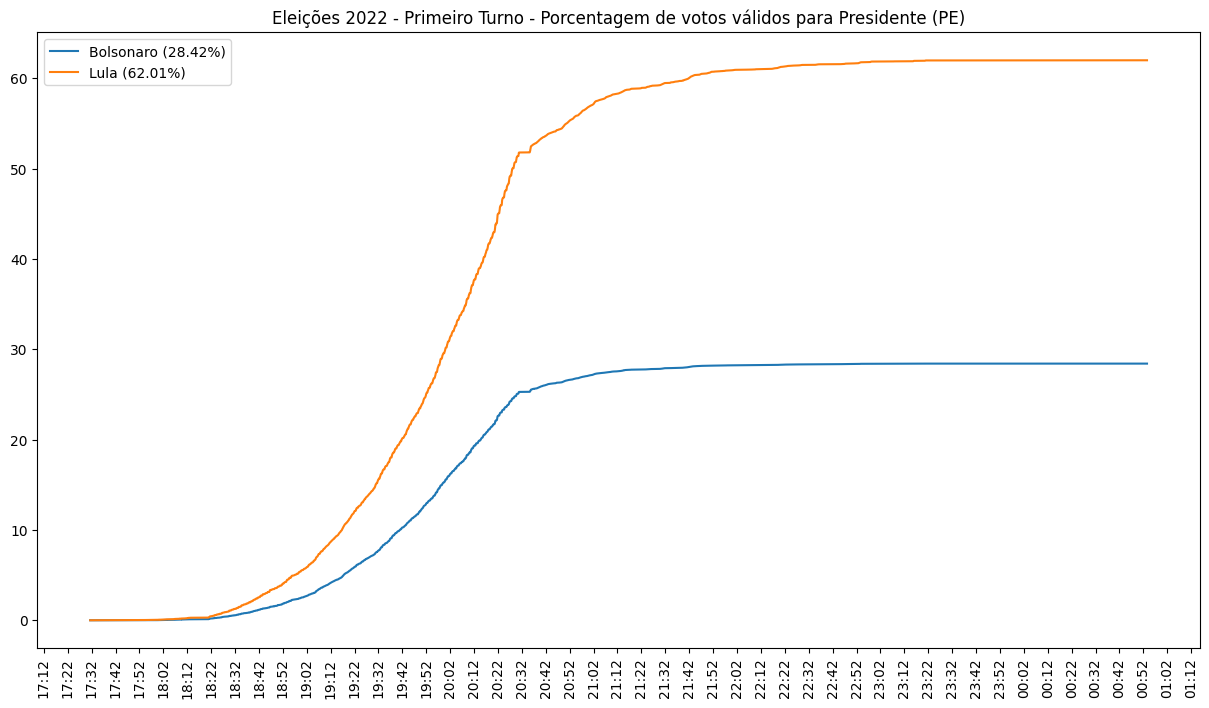

In [ ]:
# Total de votos acumulados
df1pe_13 = df1pe[df1pe['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pe_22 = df1pe[df1pe['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pe_13.set_index('data_hora', inplace=True)
df1pe_22.set_index('data_hora', inplace=True)

df1pe_13.sort_index(inplace=True)
df1pe_22.sort_index(inplace=True)

df1pe_13['acumulados'] = df1pe_13['QT_VOTOS'].cumsum()
df1pe_22['acumulados'] = df1pe_22['QT_VOTOS'].cumsum()

df1pe_13['acumulados'] = (df1pe_13['acumulados'] / total1pe) * 100
df1pe_22['acumulados'] = (df1pe_22['acumulados'] / total1pe) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pe_22.index, df1pe_22['acumulados'], label=f"Bolsonaro ({df1pe_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pe_13.index, df1pe_13['acumulados'], label=f"Lula ({df1pe_13['acumulados'].iloc[-1]:.2f}%)")

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (PE)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1pe_urnas = df1pe[df1pe['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1pe_urnas[df1pe_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1pe_urnas[df1pe_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 3


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1pe_urnas_22 = df1pe_urnas[df1pe_urnas['NR_VOTAVEL'] == 22]
df1pe_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]

NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
1403913    GARANHUNS       56       524              1902
1624940   TERRA NOVA       78        49              1384
1625009   TERRA NOVA       78        50              1376

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

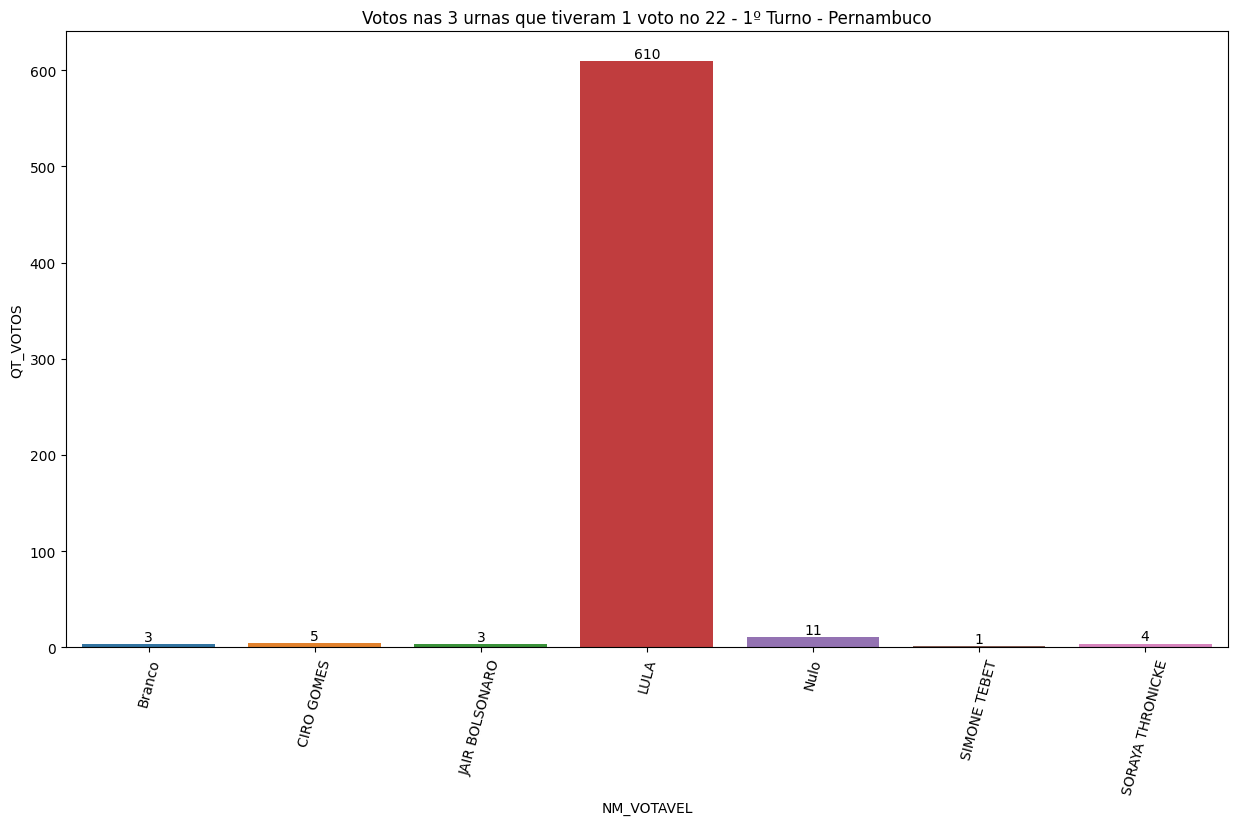

In [ ]:
df_soma = None

for i in range(len(df1pe_urnas_22)):
    cidade = df1pe_urnas_22.iloc[i, df1pe_urnas_22.columns.get_loc('CD_MUNICIPIO')]
    zona = df1pe_urnas_22.iloc[i, df1pe_urnas_22.columns.get_loc('NR_ZONA')]
    secao = df1pe_urnas_22.iloc[i, df1pe_urnas_22.columns.get_loc('NR_SECAO')]
    local = df1pe_urnas_22.iloc[i, df1pe_urnas_22.columns.get_loc('NR_LOCAL_VOTACAO')]

    df_temp = df1pe[(df1pe['CD_MUNICIPIO'] == cidade) &
                    (df1pe['NR_ZONA'] == zona) &
                    (df1pe['NR_SECAO'] == secao) &
                    (df1pe['NR_LOCAL_VOTACAO'] == local)][['NM_VOTAVEL', 'QT_VOTOS']]

    if (df_soma is not None):
        df_soma = pd.concat([df_soma, df_temp], ignore_index=True)
    else:        
        df_soma = df_temp

df_soma = df_soma.groupby('NM_VOTAVEL', as_index=False).sum('QT_VOTOS')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df_soma)

ax.bar_label(ax.containers[0])
ax.set(title=f'Votos nas {df1pe_urnas_22["NR_VOTAVEL"].count()} urnas que tiveram 1 voto no 22 - 1º Turno - Pernambuco')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

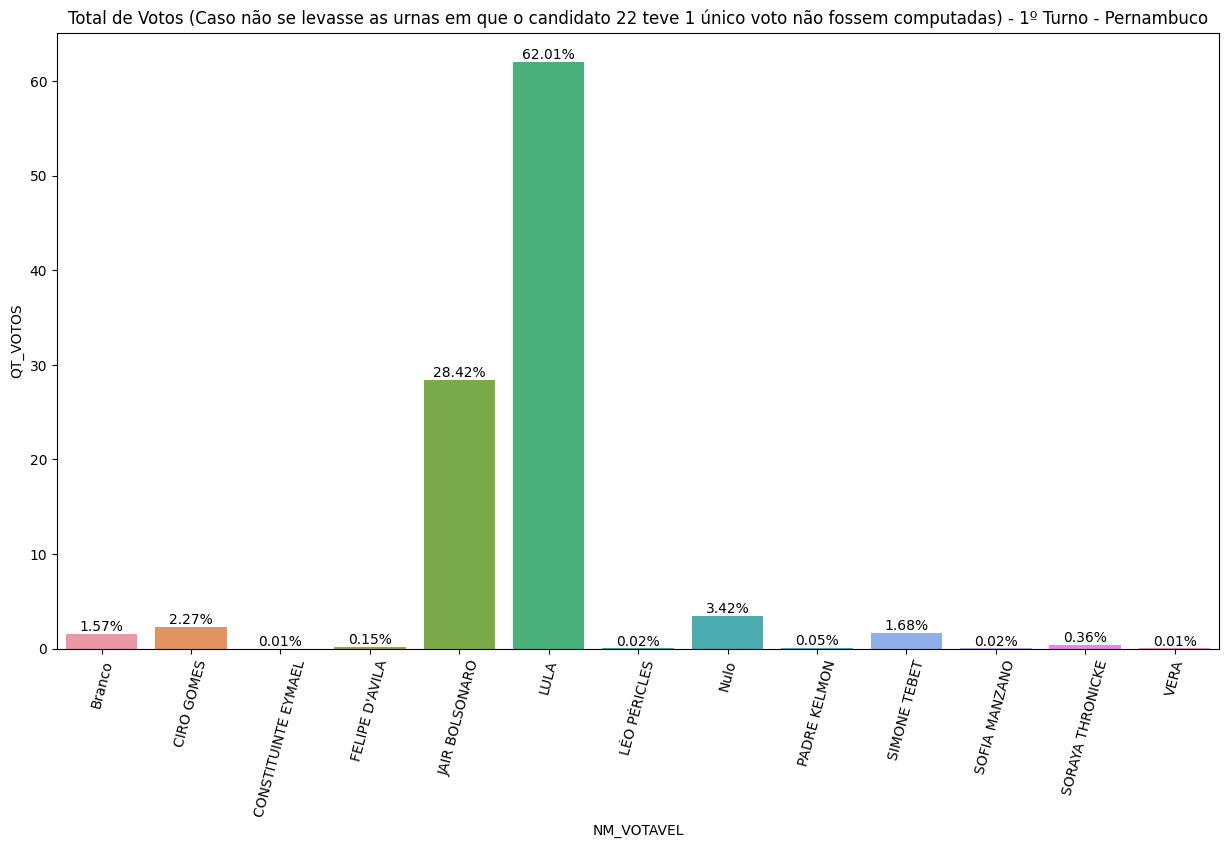

In [ ]:
df1pe_sub = df1pe[~((df1pe['CD_MUNICIPIO'].isin(df1ce_urnas_22['CD_MUNICIPIO'])) & 
                    (df1pe['NR_ZONA'].isin(df1ce_urnas_22['NR_ZONA'])) & 
                    (df1pe['NR_SECAO'].isin(df1ce_urnas_22['NR_SECAO'])) & 
                    (df1pe['NR_LOCAL_VOTACAO'].isin(df1ce_urnas_22['NR_LOCAL_VOTACAO'])))]


total1pe_sub = df1pe_sub['QT_VOTOS'].sum()

df1pe_sub_order = df1pe_sub.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1pe_sub_order['QT_VOTOS'] = (df1pe_sub_order['QT_VOTOS'] / total1pe_sub) * 100

plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1pe_sub_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno - Pernambuco')

for item in ax.get_xticklabels():
    item.set_rotation(75)

Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

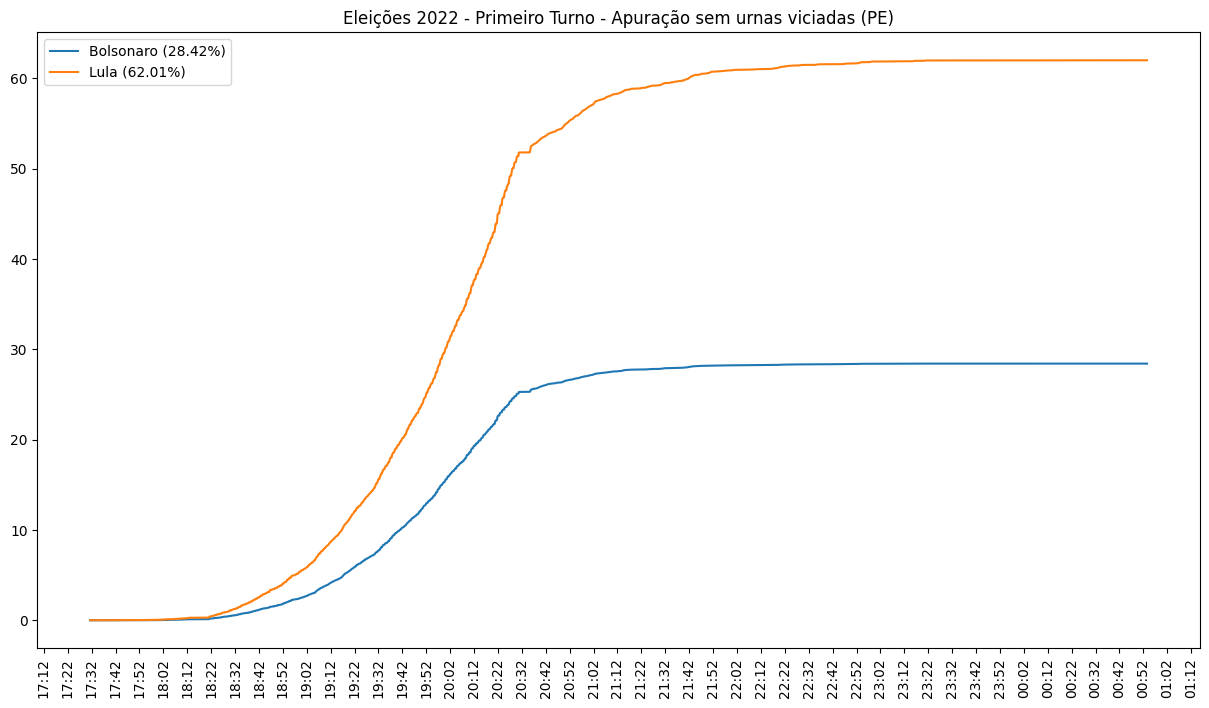

In [ ]:
total1pe_sub = df1pe_sub['QT_VOTOS'].sum()

df1pe_sub_13 = df1pe_sub[df1pe_sub['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1pe_sub_22 = df1pe_sub[df1pe_sub['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1pe_sub_13.set_index('data_hora', inplace=True)
df1pe_sub_22.set_index('data_hora', inplace=True)

df1pe_sub_13.sort_index(inplace=True)
df1pe_sub_22.sort_index(inplace=True)

df1pe_sub_13['acumulados'] = df1pe_sub_13['QT_VOTOS'].cumsum()
df1pe_sub_22['acumulados'] = df1pe_sub_22['QT_VOTOS'].cumsum()

df1pe_sub_13['acumulados'] = (df1pe_sub_13['acumulados'] / total1pe_sub) * 100
df1pe_sub_22['acumulados'] = (df1pe_sub_22['acumulados'] / total1pe_sub) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1pe_sub_22.index, df1pe_sub_22['acumulados'], label=f"Bolsonaro ({df1pe_sub_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1pe_sub_13.index, df1pe_sub_13['acumulados'], label=f"Lula ({df1pe_sub_13['acumulados'].iloc[-1]:.2f}%)")

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas (PE)')
ax.legend()

##### 1.1.1.8 ALAGOAS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


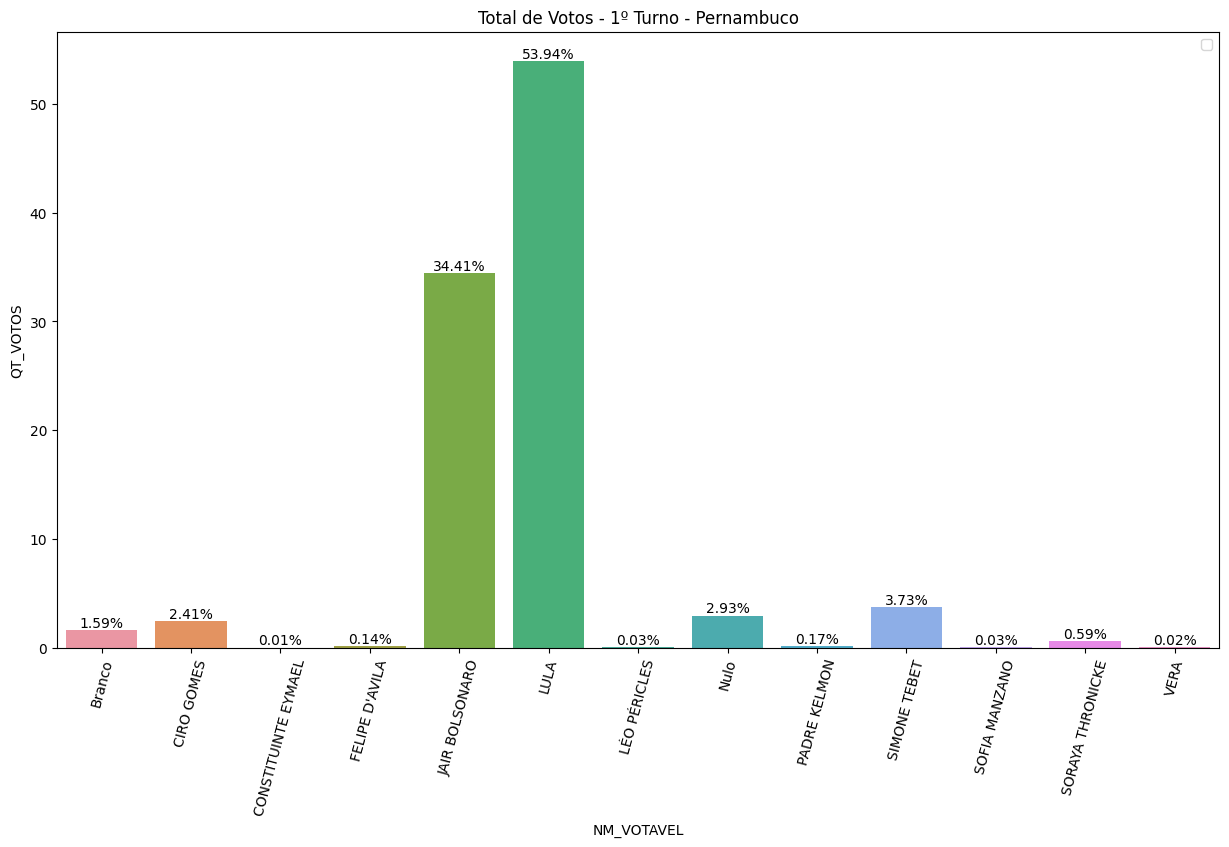

In [ ]:
# Graficos - Total no 1º turno
total1al = df1al['QT_VOTOS'].sum()

df1al_order = df1al.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1al_order['QT_VOTOS'] = (df1al_order['QT_VOTOS'] / total1al) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1al_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Pernambuco')

for item in ax.get_xticklabels():
    item.set_rotation(75)

ax.legend()

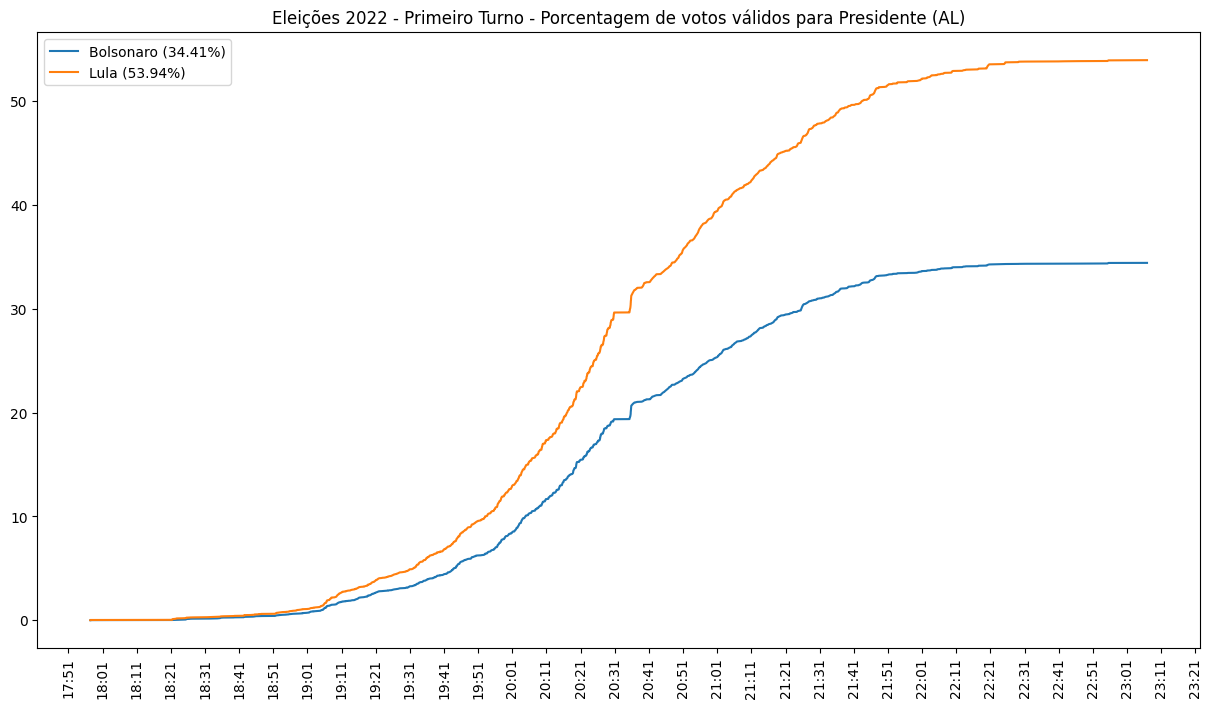

In [ ]:
# Total de votos acumulados
df1al_13 = df1al[df1al['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1al_22 = df1al[df1al['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1al_13.set_index('data_hora', inplace=True)
df1al_22.set_index('data_hora', inplace=True)

df1al_13.sort_index(inplace=True)
df1al_22.sort_index(inplace=True)

df1al_13['acumulados'] = df1al_13['QT_VOTOS'].cumsum()
df1al_22['acumulados'] = df1al_22['QT_VOTOS'].cumsum()

df1al_13['acumulados'] = (df1al_13['acumulados'] / total1al) * 100
df1al_22['acumulados'] = (df1al_22['acumulados'] / total1al) * 100

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1al_22.index, df1al_22['acumulados'], label=f"Bolsonaro ({df1al_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1al_13.index, df1al_13['acumulados'], label=f"Lula ({df1al_13['acumulados'].iloc[-1]:.2f}%)")

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (AL)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:

df1al_urnas = df1al[df1al['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1al_urnas[df1al_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1al_urnas[df1al_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 0


##### 1.1.1.9 SERGIPE

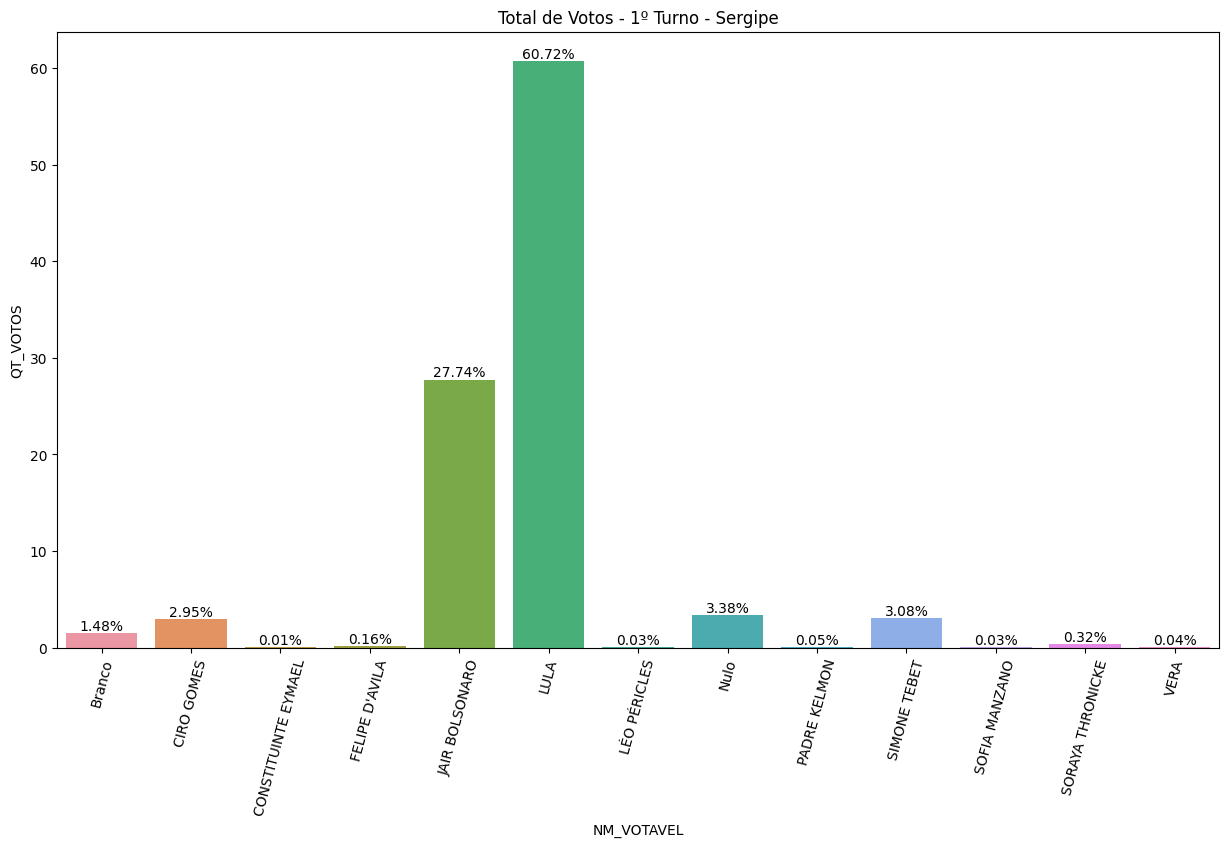

In [ ]:
# Graficos - Total no 1º turno
total1se = df1se['QT_VOTOS'].sum()

df1se_order = df1se.groupby('NM_VOTAVEL', as_index=False)['QT_VOTOS'].sum()
df1se_order['QT_VOTOS'] = (df1se_order['QT_VOTOS'] / total1se) * 100
plt.figure(figsize=(15,8))
ax = sns.barplot(x='NM_VOTAVEL', 
                 y='QT_VOTOS', 
                 data=df1se_order)

ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set(title=f'Total de Votos - 1º Turno - Sergipe')

for item in ax.get_xticklabels():
    item.set_rotation(75)

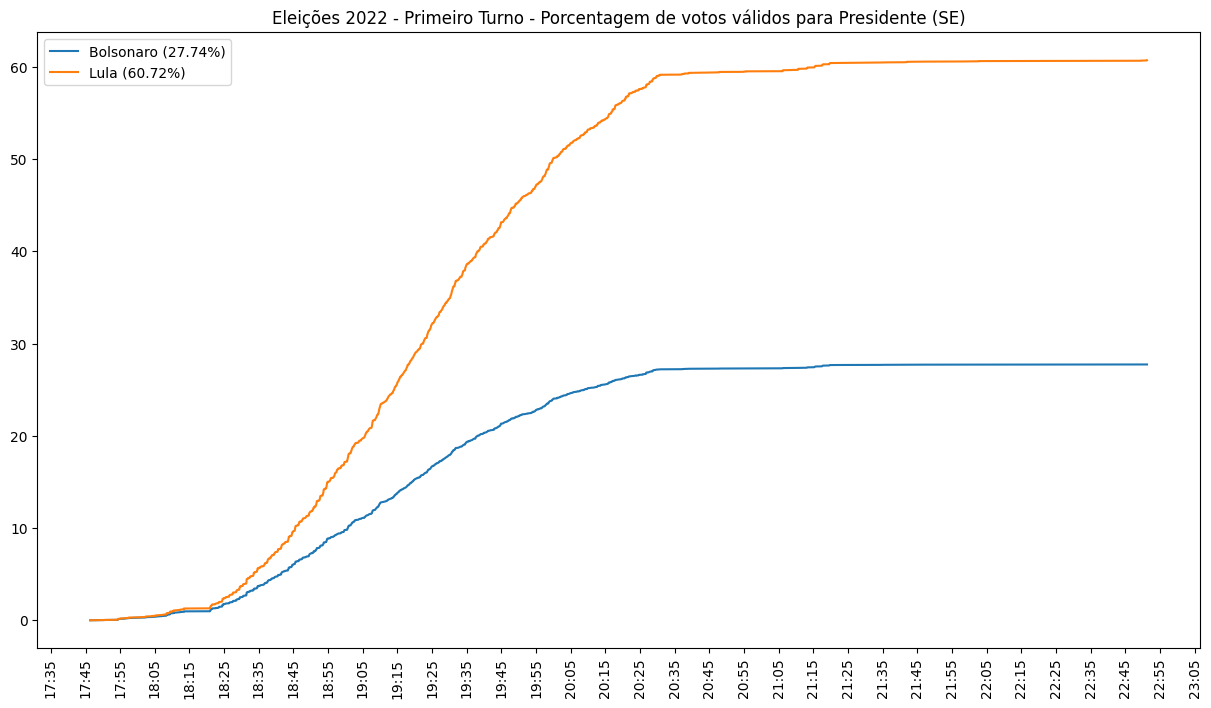

In [ ]:
# Total de votos acumulados
df1se_13 = df1se[df1se['NR_VOTAVEL'] == 13][['data_hora', 'QT_VOTOS']]
df1se_22 = df1se[df1se['NR_VOTAVEL'] == 22][['data_hora', 'QT_VOTOS']]

df1se_13.set_index('data_hora', inplace=True)
df1se_22.set_index('data_hora', inplace=True)

df1se_13.sort_index(inplace=True)
df1se_22.sort_index(inplace=True)

df1se_13['acumulados'] = df1se_13['QT_VOTOS'].cumsum()
df1se_22['acumulados'] = df1se_22['QT_VOTOS'].cumsum()

df1se_13['acumulados'] = (df1se_13['acumulados'] / total1se) * 100
df1se_22['acumulados'] = (df1se_22['acumulados'] / total1se) * 100


fig, ax = plt.subplots(figsize=(15,8))

ax.plot(df1se_22.index, df1se_22['acumulados'], label=f"Bolsonaro ({df1se_22['acumulados'].iloc[-1]:.2f}%)")
ax.plot(df1se_13.index, df1se_13['acumulados'], label=f"Lula ({df1se_13['acumulados'].iloc[-1]:.2f}%)")

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_tick_params(labelrotation=90)

ax.set_title('Eleições 2022 - Primeiro Turno - Porcentagem de votos válidos para Presidente (SE)')
ax.legend()

Quantidade de urnas com 1 voto - Primeiro Turno

In [ ]:
df1se_urnas = df1se[df1se['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1se_urnas[df1se_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1se_urnas[df1se_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 0


#### 1.1.2. Resultado da Região

In [ ]:
df1ne = pd.concat([df1ba, df1pi, df1ce, df1pb, df1pe, df1ma, df1rn, df1al, df1se], ignore_index=True) 

Quantidade de urnas com 1 voto - Primeiro Turno

Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 147


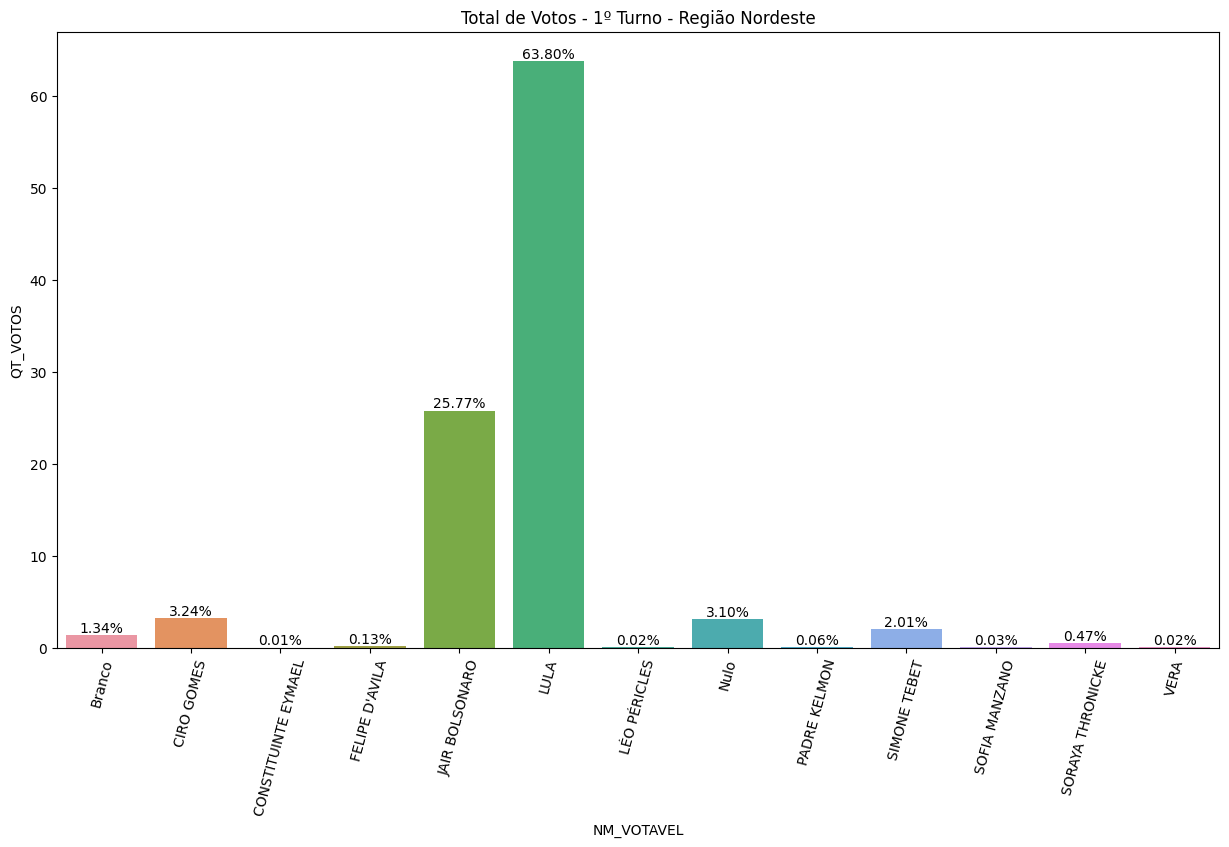

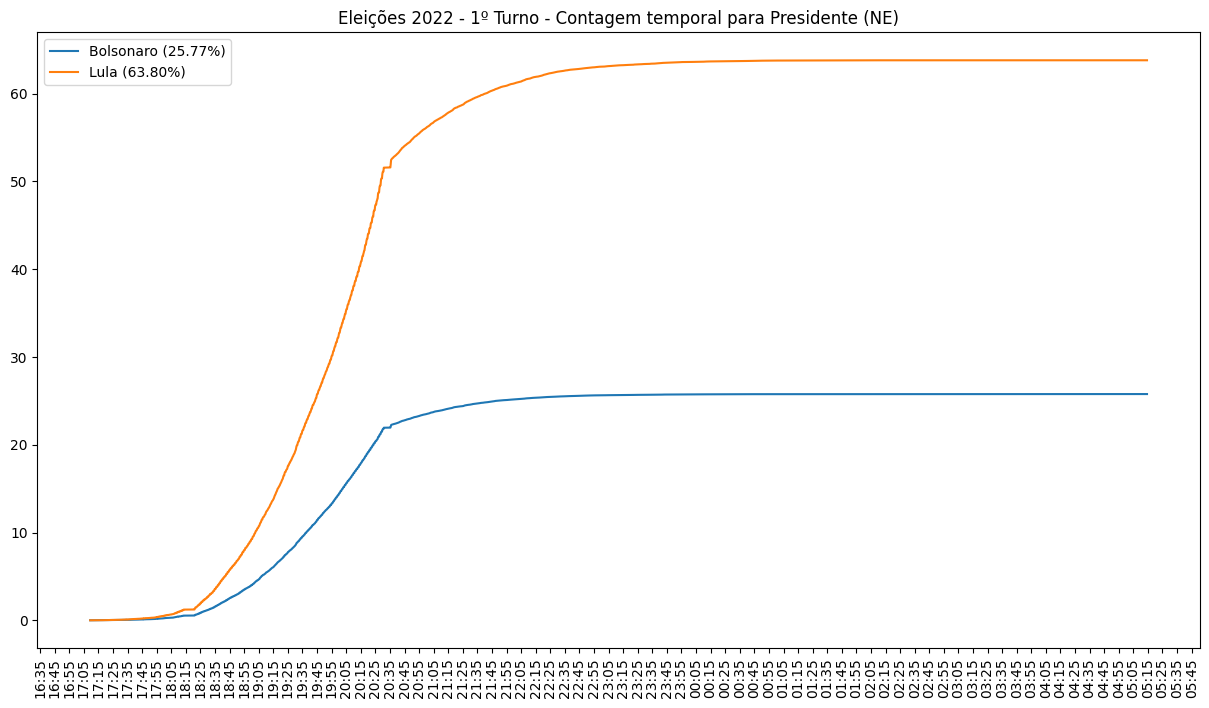

In [ ]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1ne, 'Total de Votos - 1º Turno', 'Região Nordeste')

# Total de votos acumulados
gerar_grafico_temporal(df1ne, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'NE')

df1ne_urnas = df1ne[df1ne['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ne_urnas[df1ne_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ne_urnas[df1ne_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?

In [ ]:

df1ne_urnas_22 = df1ne_urnas[df1ne_urnas['NR_VOTAVEL'] == 22]
df1ne_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]


NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
10058              SALVADOR        5       800              1805
39495              SALVADOR       19       800              1490
41624       MANOEL VITORINO       22       160              1139
71124             ITABERABA       42       288              1570
72106          CASTRO ALVES       43       132              1376
...                     ...      ...       ...               ...
779526    PRESIDENTE SARNEY      106       224              1120
780020  SERRANO DO MARANHÃO      107        87              1120
780321  SERRANO DO MARANHÃO      107       169              1228
782082               MORROS      110       218              1180
782109               MORROS      110       224              1244

[147 rows x 4 columns]

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?

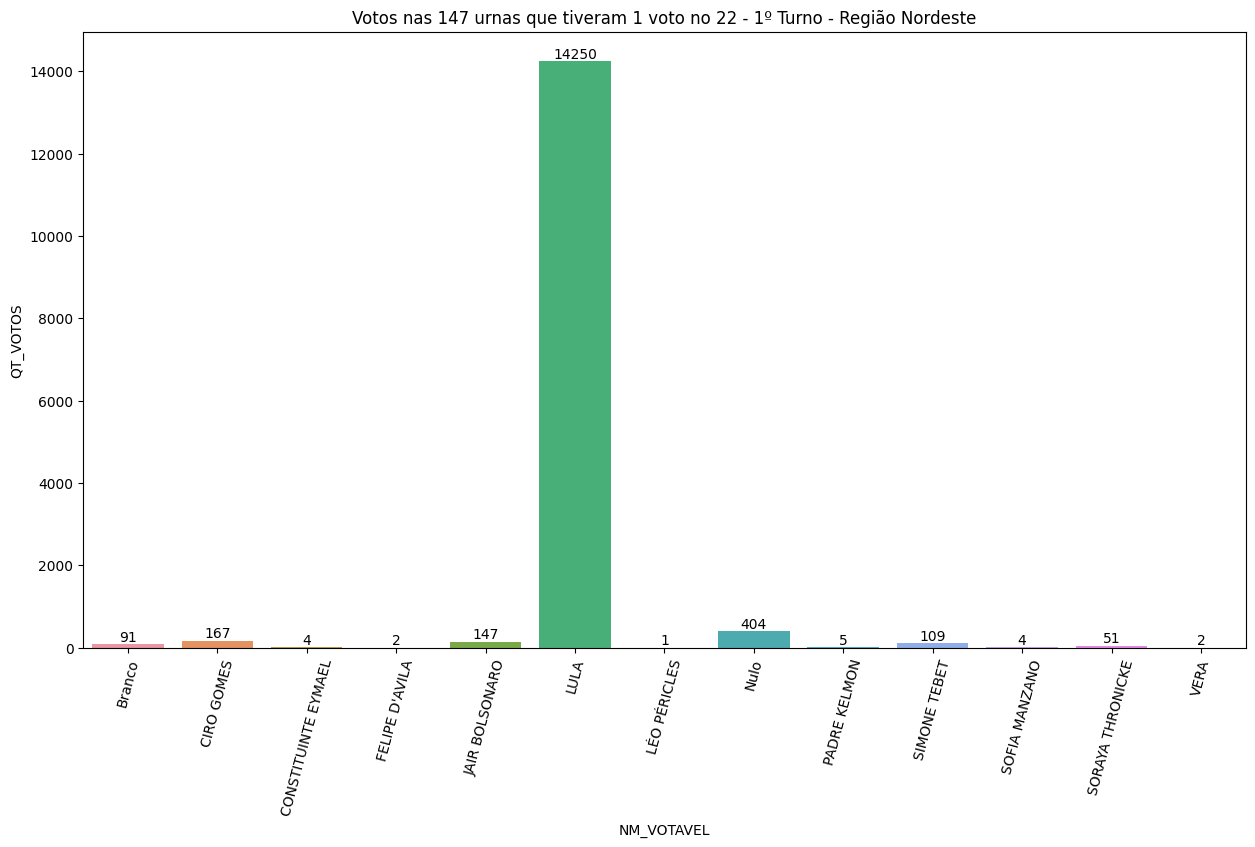

In [ ]:

df_soma = df_diff_group(df1ne, df1ne_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1ne_urnas_22, 'Região Nordeste')


Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

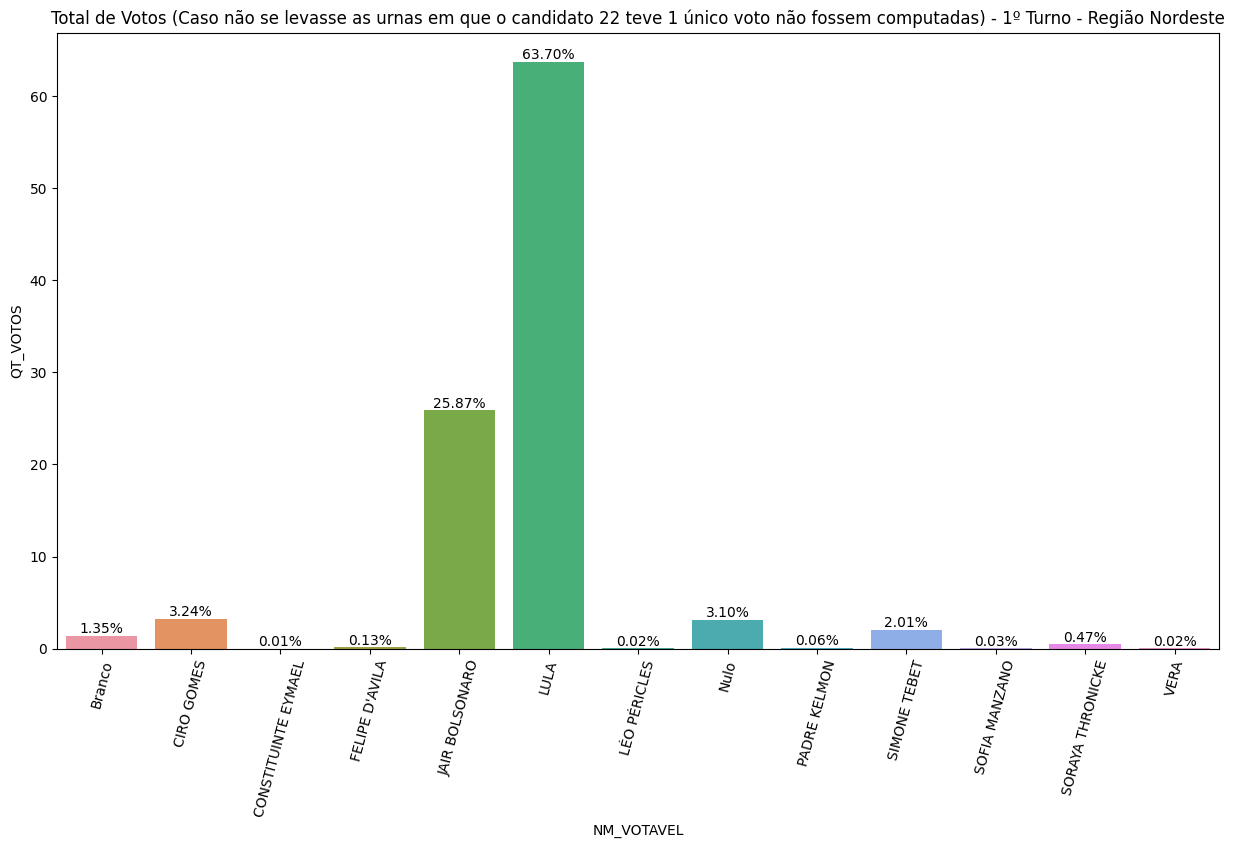

In [ ]:

# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1ne_sub = df1ne[~((df1ne['CD_MUNICIPIO'].isin(df1ne_urnas_22['CD_MUNICIPIO'])) &
             (df1ne['NR_ZONA'].isin(df1ne_urnas_22['NR_ZONA'])) &
             (df1ne['NR_SECAO'].isin(df1ne_urnas_22['NR_SECAO'])) &
             (df1ne['NR_LOCAL_VOTACAO'].isin(df1ne_urnas_22['NR_LOCAL_VOTACAO'])))]
             
gerar_grafico_porcentagem(df1ne_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Região Nordeste')


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?

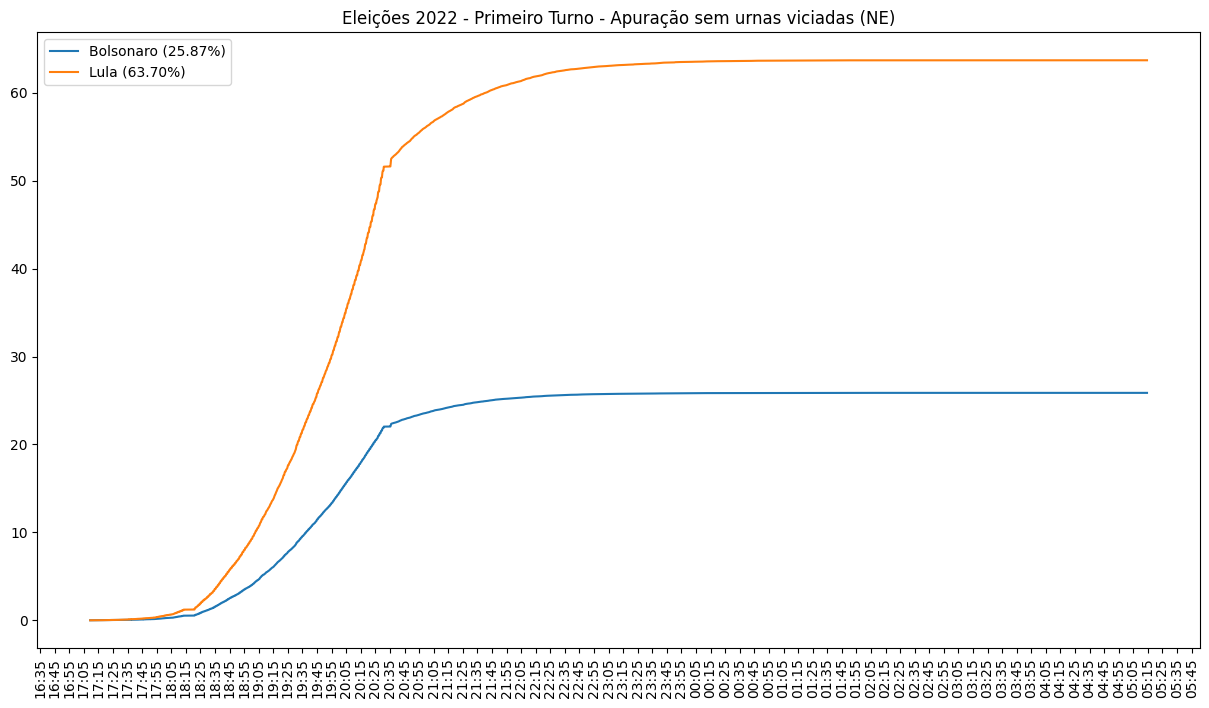

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas

gerar_grafico_temporal(df1ne_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'NE')

### 1.2. Região NORTE

#### 1.2.1. Estados

##### 1.2.1.1. AMAZONAS


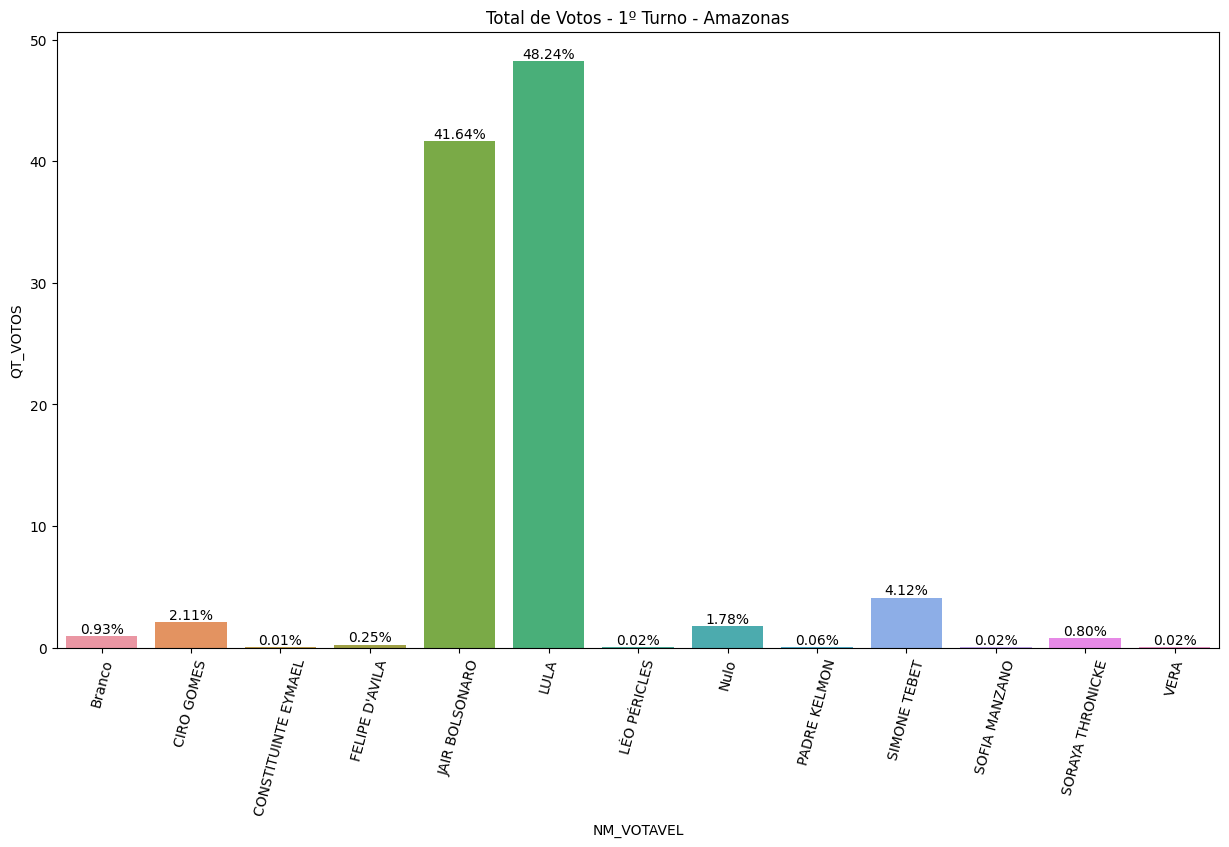

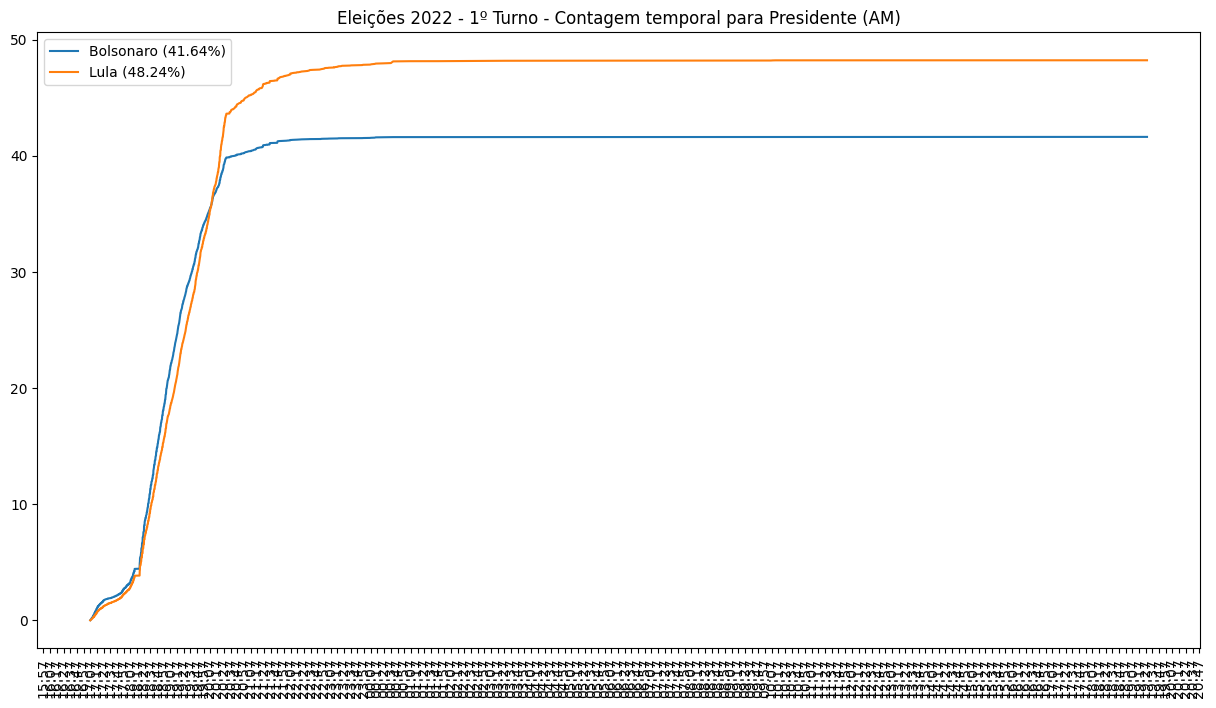

In [ ]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1am, 'Total de Votos - 1º Turno', 'Amazonas')# Total de votos acumulados
gerar_grafico_temporal(df1am, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'AM')


Quantidade de urnas com 1 voto - Primeiro Turno


In [ ]:
df1am_urnas = df1am[df1am['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1am_urnas[df1am_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1am_urnas[df1am_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 26


Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?


In [ ]:
df1am_urnas_22 = df1am_urnas[df1am_urnas['NR_VOTAVEL'] == 22]
df1am_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]


NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
271353                    HUMAITÁ       17        57              1252
278953   SÃO GABRIEL DA CACHOEIRA       19         1              1090
280033   SÃO GABRIEL DA CACHOEIRA       19        12              1120
280560   SÃO GABRIEL DA CACHOEIRA       19        21              1198
280615   SÃO GABRIEL DA CACHOEIRA       19        22              1198
280665   SÃO GABRIEL DA CACHOEIRA       19        23              1090
282547   SÃO GABRIEL DA CACHOEIRA       19        66              1538
283963   SÃO GABRIEL DA CACHOEIRA       19        84              1538
284432   SÃO GABRIEL DA CACHOEIRA       19        91              1155
291566          BENJAMIN CONSTANT       20        96              1309
299877      SÃO PAULO DE OLIVENÇA       22        46              1104
300295      SÃO PAULO DE OLIVENÇA       22        58              1139
300940      SÃO PAULO DE OLIVENÇA       22        71              1171
302527      SÃO PAULO DE OLIVENÇA       22        94              1139
303010      SÃO PAULO DE OLIVENÇA       22       100              1163
303060      SÃO PAULO DE OLIVENÇA       22       101              1090
320791                     SILVES       24        51              1058
326897                BARREIRINHA       26        63              1414
338720  SANTA ISABEL DO RIO NEGRO       30        26              1139
473386                  TABATINGA       36        96              1260
589946           ATALAIA DO NORTE       42        26              1120
605724       SANTO ANTÔNIO DO IÇÁ       47        10              1040
606882       SANTO ANTÔNIO DO IÇÁ       47        26              1040
610614       SANTO ANTÔNIO DO IÇÁ       47        71              1040
610866       SANTO ANTÔNIO DO IÇÁ       47        74              1139
829931                     MANAUS       62      1006              2097

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?


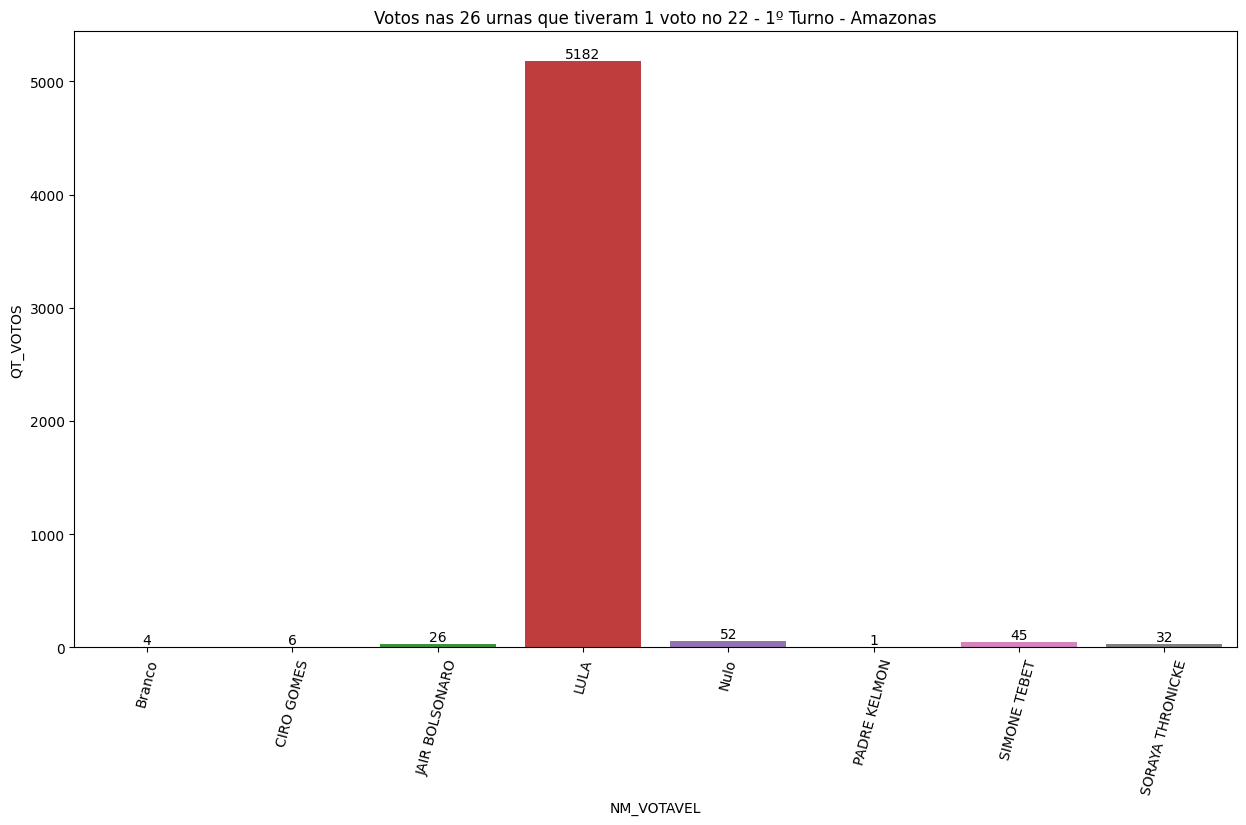

In [ ]:
df_soma = df_diff_group(df1am, df1am_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1am_urnas_22, 'Amazonas')

Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


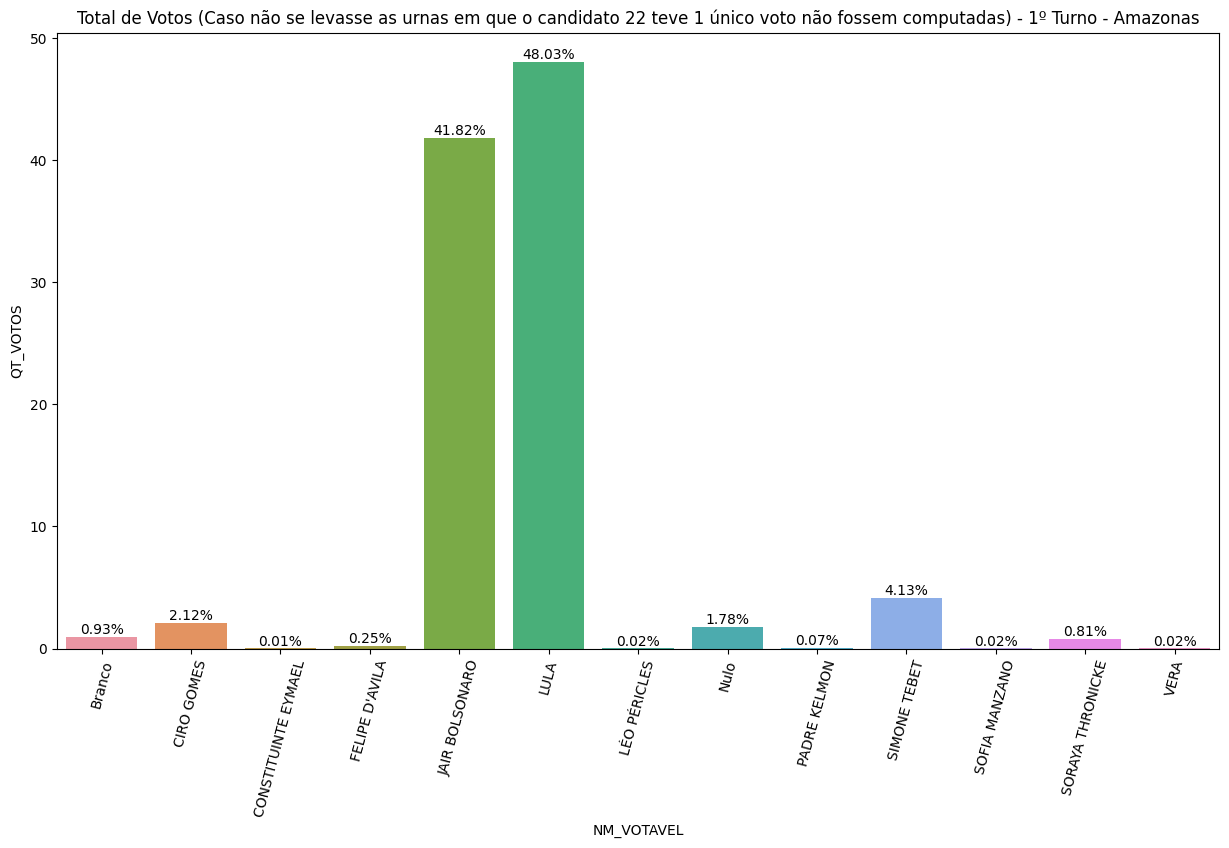

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1am_sub = df1am[~((df1am['CD_MUNICIPIO'].isin(df1am_urnas_22['CD_MUNICIPIO'])) & 
            (df1am['NR_ZONA'].isin(df1am_urnas_22['NR_ZONA'])) & 
            (df1am['NR_SECAO'].isin(df1am_urnas_22['NR_SECAO'])) & 
            (df1am['NR_LOCAL_VOTACAO'].isin(df1am_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1am_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Amazonas')


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?


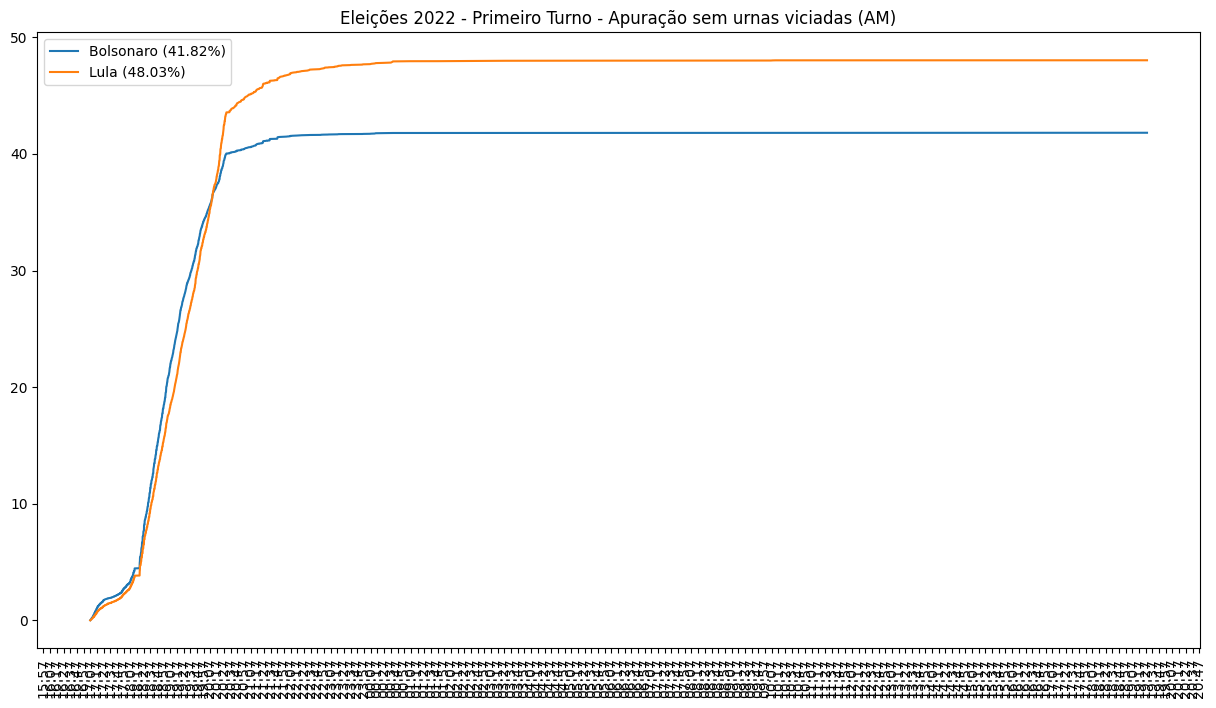

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1am_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'AM')

##### 1.2.1.2. PARÁ


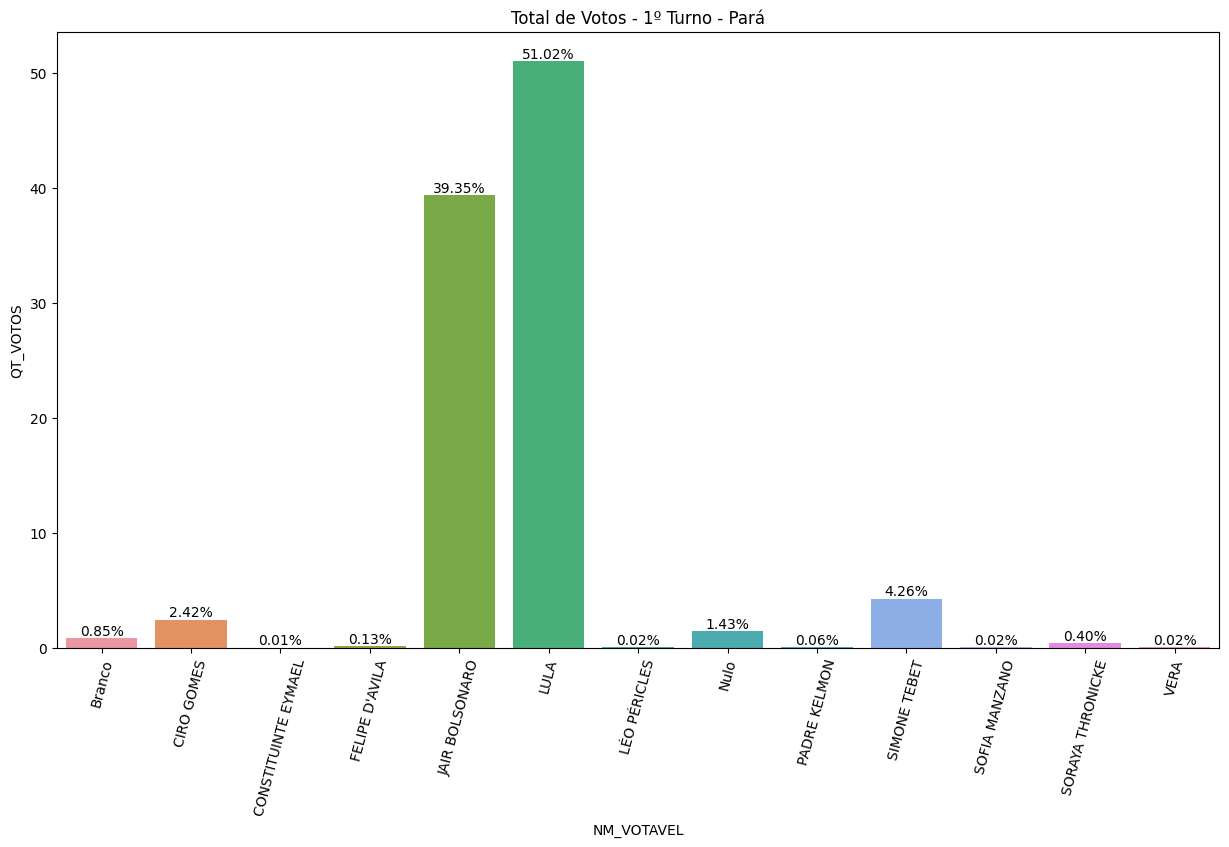

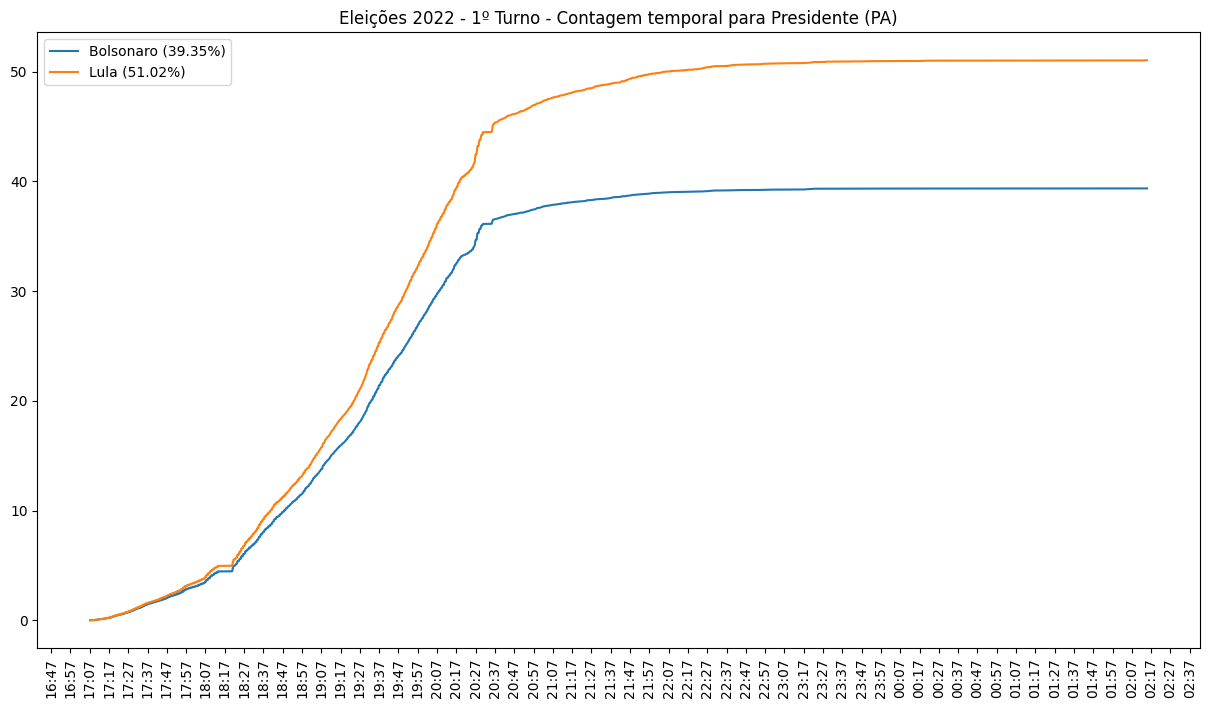

In [ ]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1pa, 'Total de Votos - 1º Turno', 'Pará')# Total de votos acumulados
gerar_grafico_temporal(df1pa, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'PA')


Quantidade de urnas com 1 voto - Primeiro Turno


In [ ]:
df1pa_urnas = df1pa[df1pa['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1pa_urnas[df1pa_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1pa_urnas[df1pa_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")


Urnas com 1 voto no candidato 13: 1
Urnas com 1 voto no candidato 22: 24



Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?


In [ ]:
df1pa_urnas_22 = df1pa_urnas[df1pa_urnas['NR_VOTAVEL'] == 22]
df1pa_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]


NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
340628                      VISEU       14       126              1775
340715                      VISEU       14       128              1724
340860                      VISEU       14       130              1791
346758                      VISEU       14       223              2070
346794                      VISEU       14       224              2089
494754                     ÓBIDOS       22       174              1864
759967                   MARACANÃ       31         7              1066
761320                   MARACANÃ       31        23              1201
826013                      BAIÃO       35        38              1287
836552                   MOCAJUBA       35       138              1201
884369                       MOJU       37       114              1368
900738                  ORIXIMINÁ       38       127              1457
901145                  ORIXIMINÁ       38       141              1384
907501                  ORIXIMINÁ       38       259              2070
982368                PARAGOMINAS       42       204              1473
1100885            OEIRAS DO PARÁ       45        79              1368
1144560     SÃO DOMINGOS DO CAPIM       50       160              2143
1207218        SÃO FÉLIX DO XINGU       53       218              1350
1244615  BREJO GRANDE DO ARAGUAIA       57       187              1139
2216020                  BELTERRA      104        50              1368
2232149                  SANTARÉM      104       227              1805
2248866                    JURUTI      105        78              1406
2250023                    JURUTI      105        93              1490
2276732               PARAUAPEBAS      106       244              1210

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?


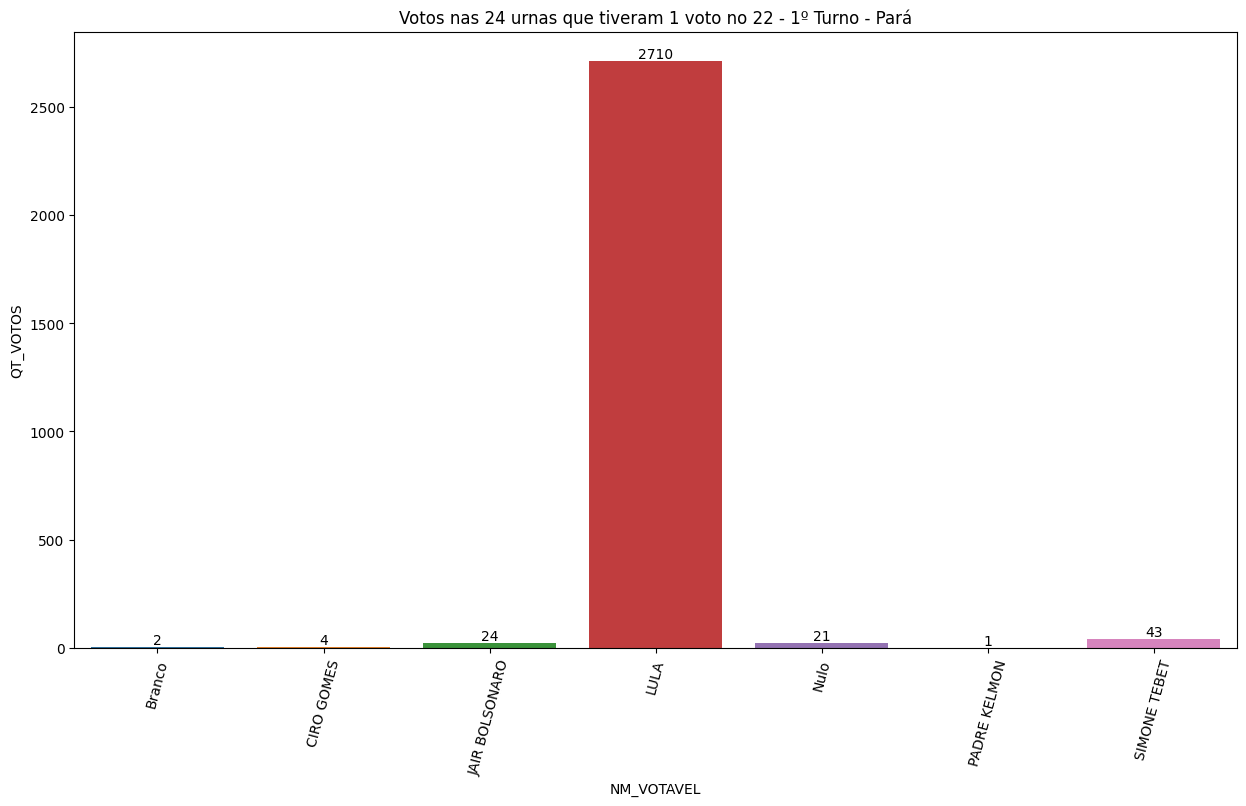

In [ ]:
df_soma = df_diff_group(df1pa, df1pa_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1pa_urnas_22, 'Pará')


Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


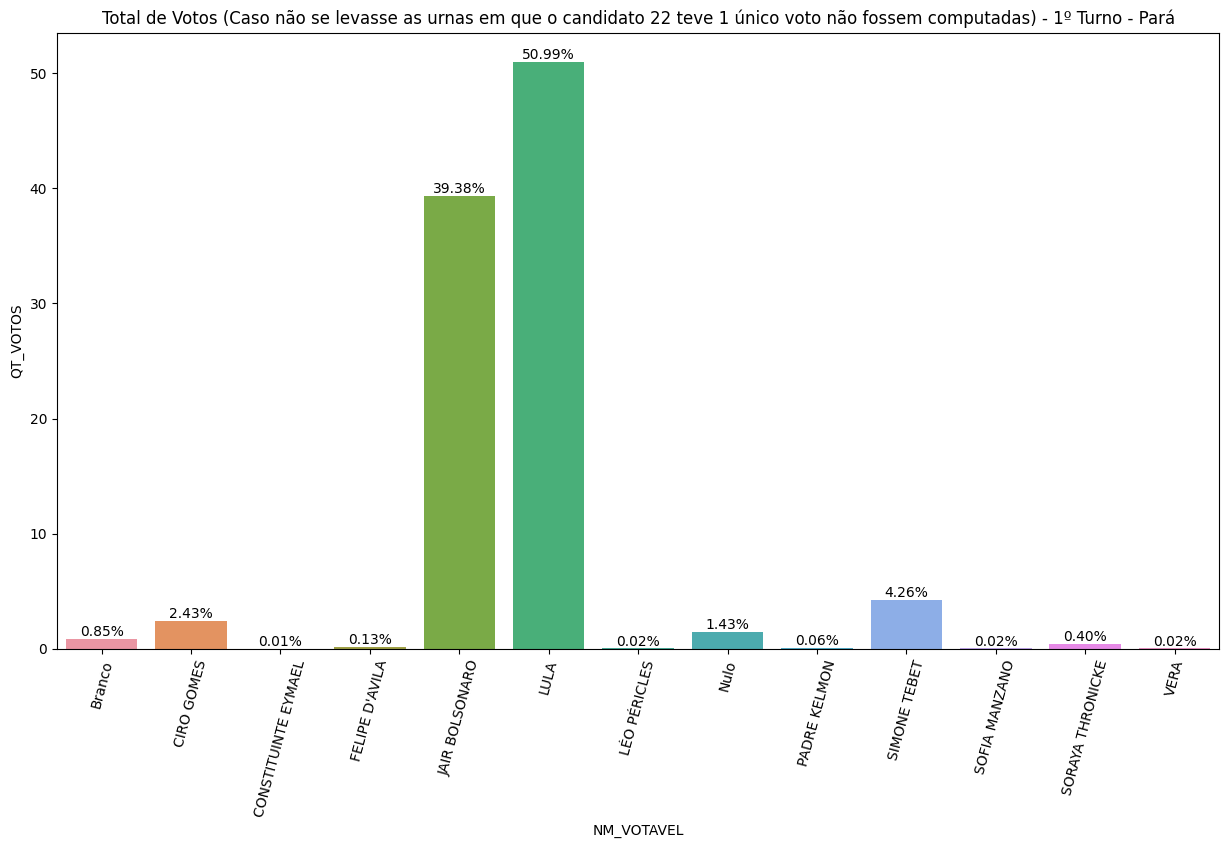

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1pa_sub = df1pa[~((df1pa['CD_MUNICIPIO'].isin(df1pa_urnas_22['CD_MUNICIPIO'])) & 
            (df1pa['NR_ZONA'].isin(df1pa_urnas_22['NR_ZONA'])) & 
            (df1pa['NR_SECAO'].isin(df1pa_urnas_22['NR_SECAO'])) & 
            (df1pa['NR_LOCAL_VOTACAO'].isin(df1pa_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1pa_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Pará')


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?


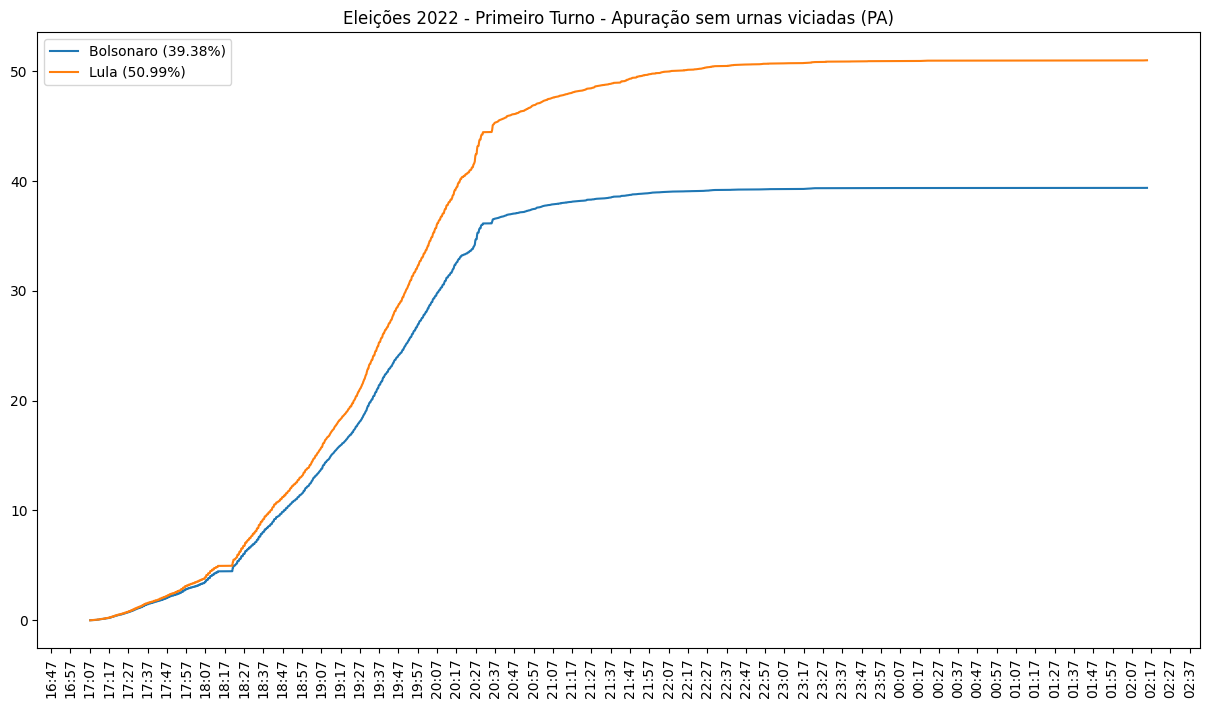

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1pa_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'PA')

##### 1.2.1.3. ACRE


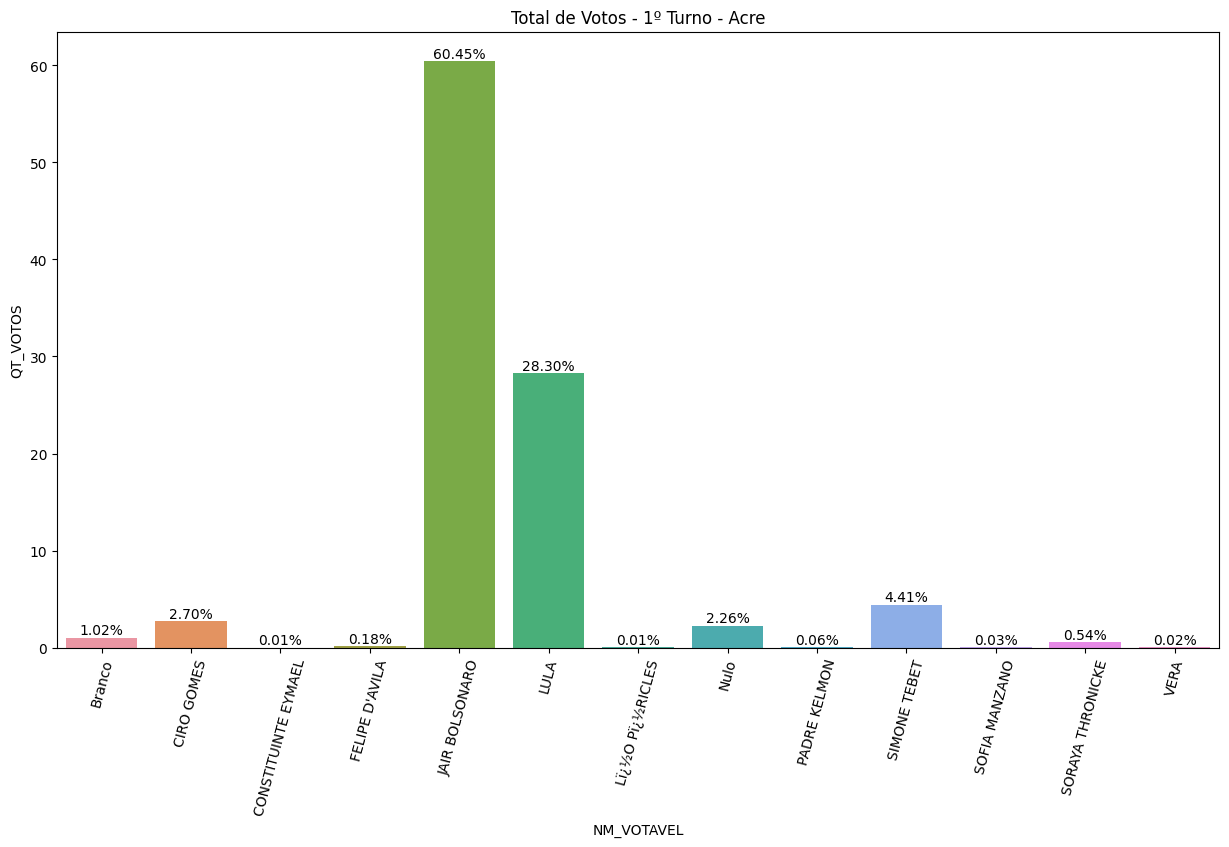

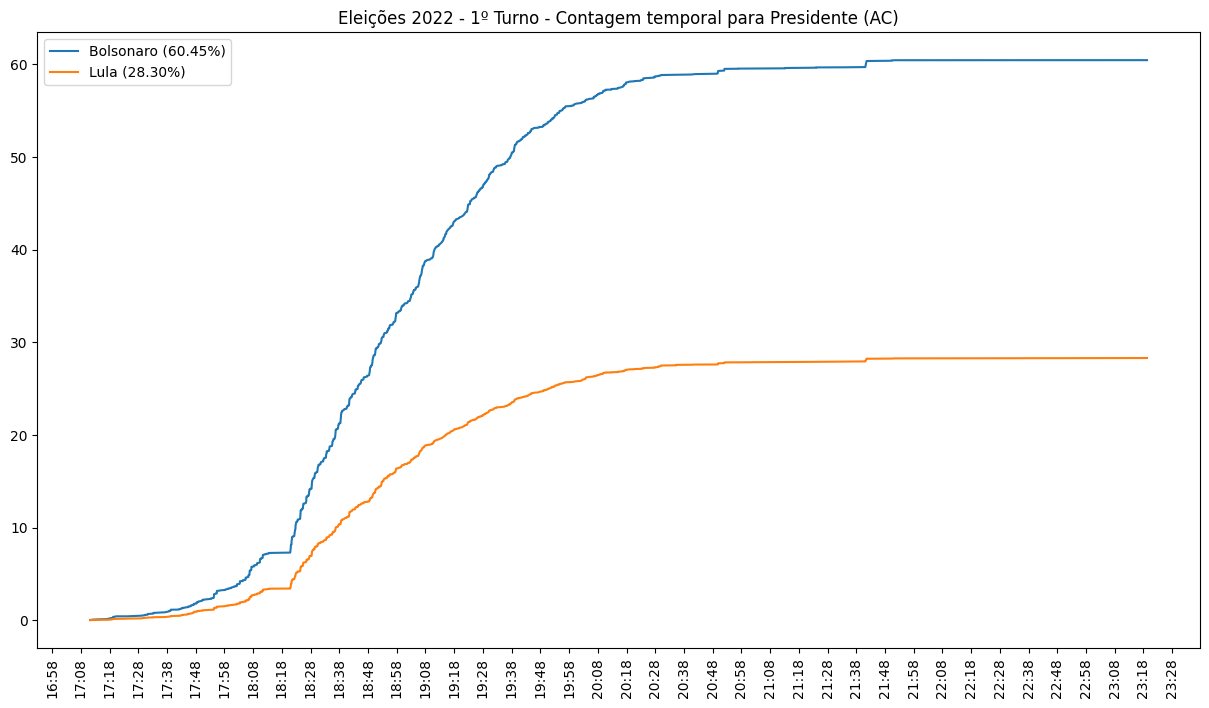

In [ ]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1ac, 'Total de Votos - 1º Turno', 'Acre')# Total de votos acumulados
gerar_grafico_temporal(df1ac, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'AC')


Quantidade de urnas com 1 voto - Primeiro Turno


In [ ]:
df1ac_urnas = df1ac[df1ac['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ac_urnas[df1ac_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ac_urnas[df1ac_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 2



Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?


In [ ]:
df1ac_urnas_22 = df1ac_urnas[df1ac_urnas['NR_VOTAVEL'] == 22]
df1ac_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]


NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
139838  MARECHAL THAUMATURGO        4       326              1163
187781               FEIJï¿½        7        69              1341

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?


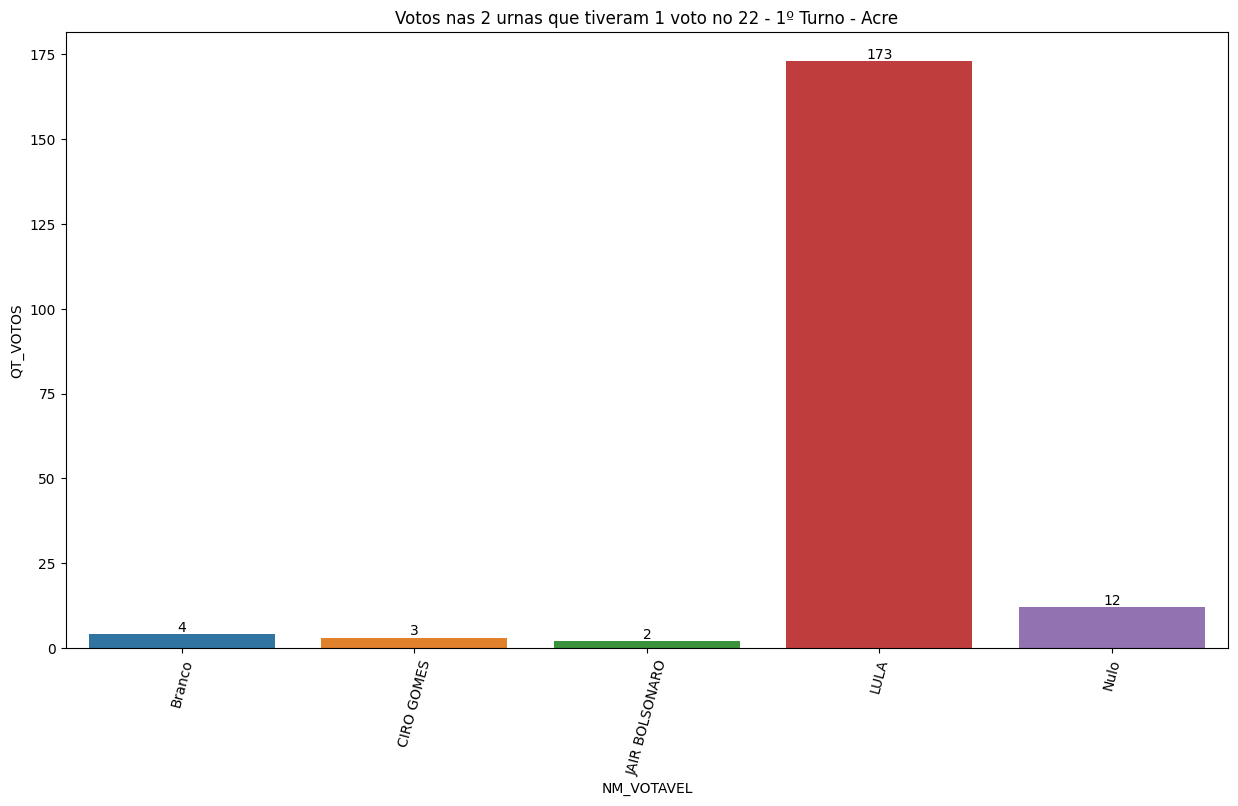

In [ ]:
df_soma = df_diff_group(df1ac, df1ac_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1ac_urnas_22, 'Acre')


Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


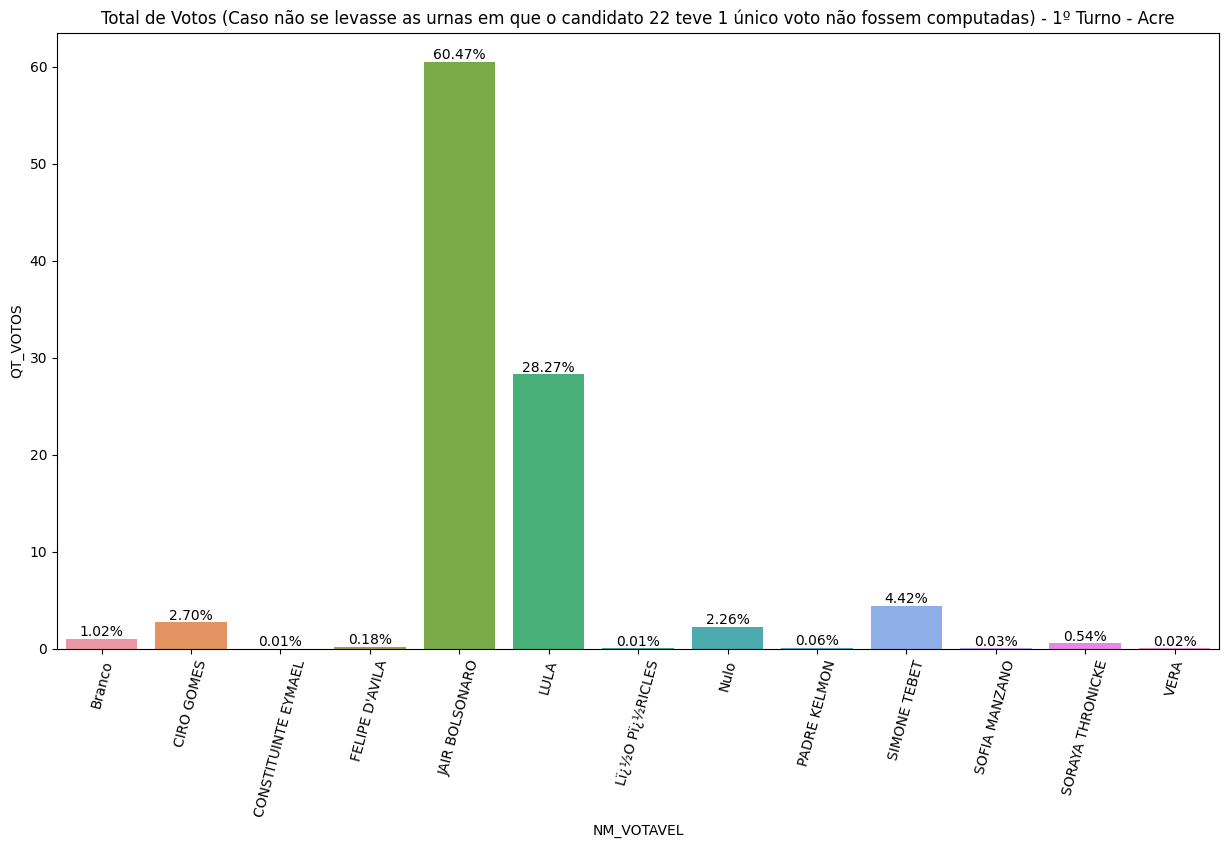

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1ac_sub = df1ac[~((df1ac['CD_MUNICIPIO'].isin(df1ac_urnas_22['CD_MUNICIPIO'])) & 
            (df1ac['NR_ZONA'].isin(df1ac_urnas_22['NR_ZONA'])) & 
            (df1ac['NR_SECAO'].isin(df1ac_urnas_22['NR_SECAO'])) & 
            (df1ac['NR_LOCAL_VOTACAO'].isin(df1ac_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1ac_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Acre')


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?


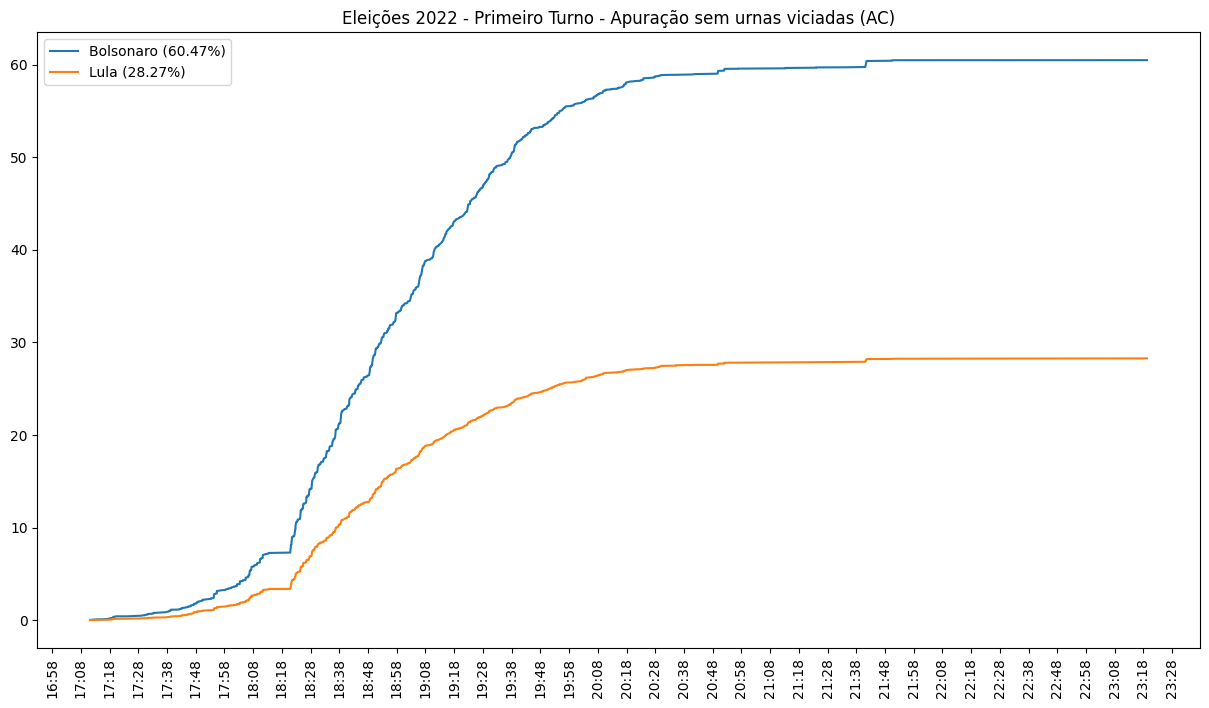

In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1ac_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'AC')

##### 1.2.1.4. RONDÔNIA


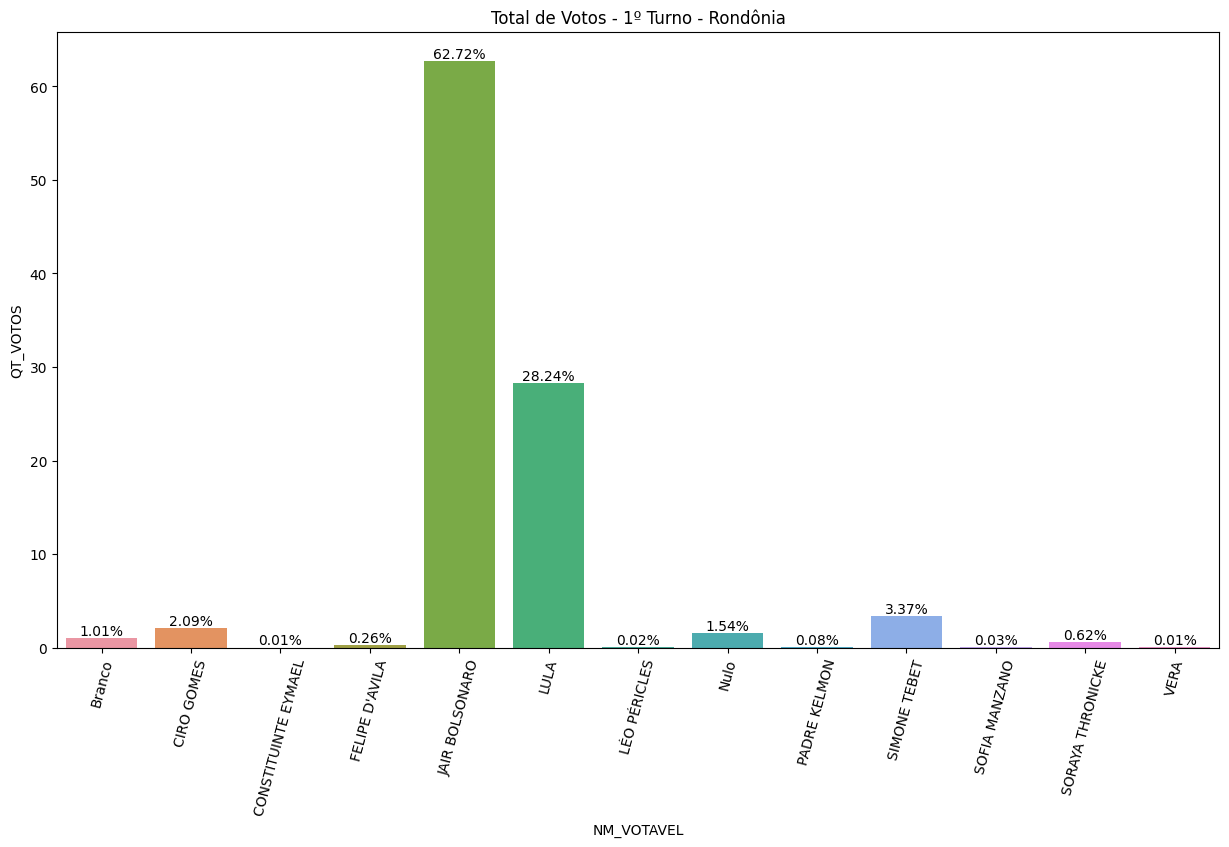

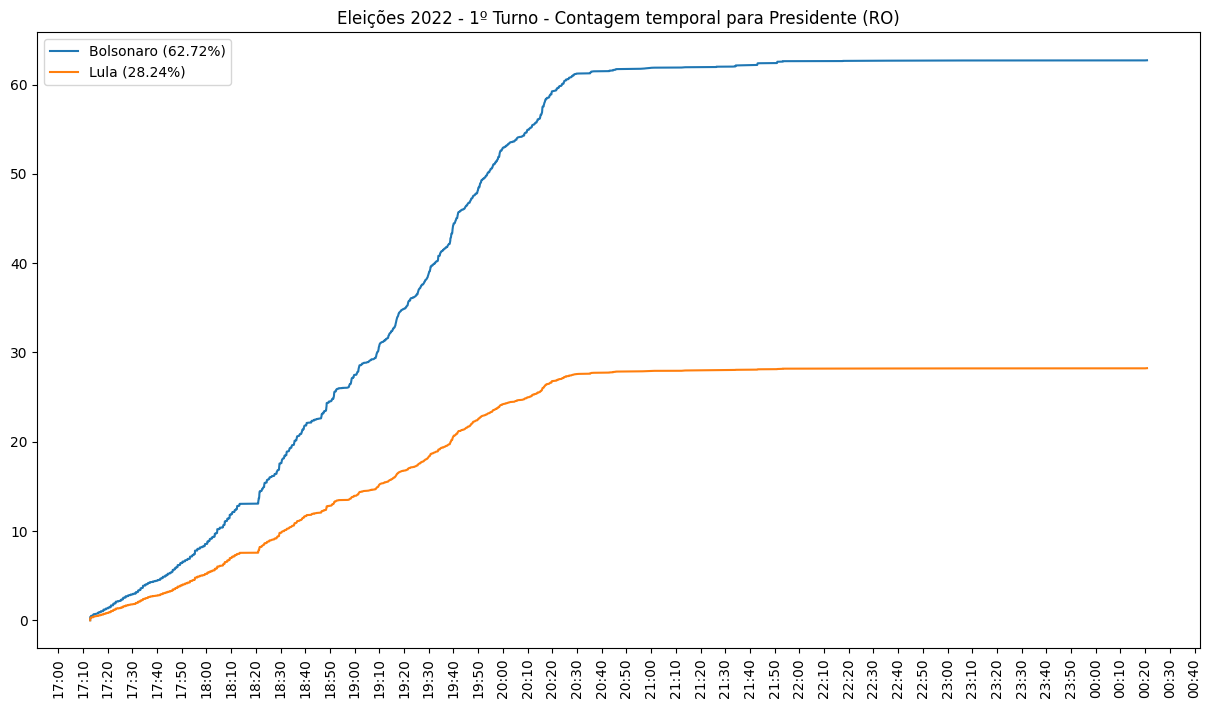

In [57]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1ro, 'Total de Votos - 1º Turno', 'Rondônia')# Total de votos acumulados
gerar_grafico_temporal(df1ro, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'RO')


Quantidade de urnas com 1 voto - Primeiro Turno


In [53]:
df1ro_urnas = df1ro[df1ro['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ro_urnas[df1ro_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ro_urnas[df1ro_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 1



Quais as seções eleitorais que apresentaram urnas com 1 voto no 22?


In [54]:
df1ro_urnas_22 = df1ro_urnas[df1ro_urnas['NR_VOTAVEL'] == 22]
df1ro_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]


NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
222765  PIMENTA BUENO        9       999              1309

Das urnas em que o 22 recebeu 1 voto, qual a quantidade de votos totais?


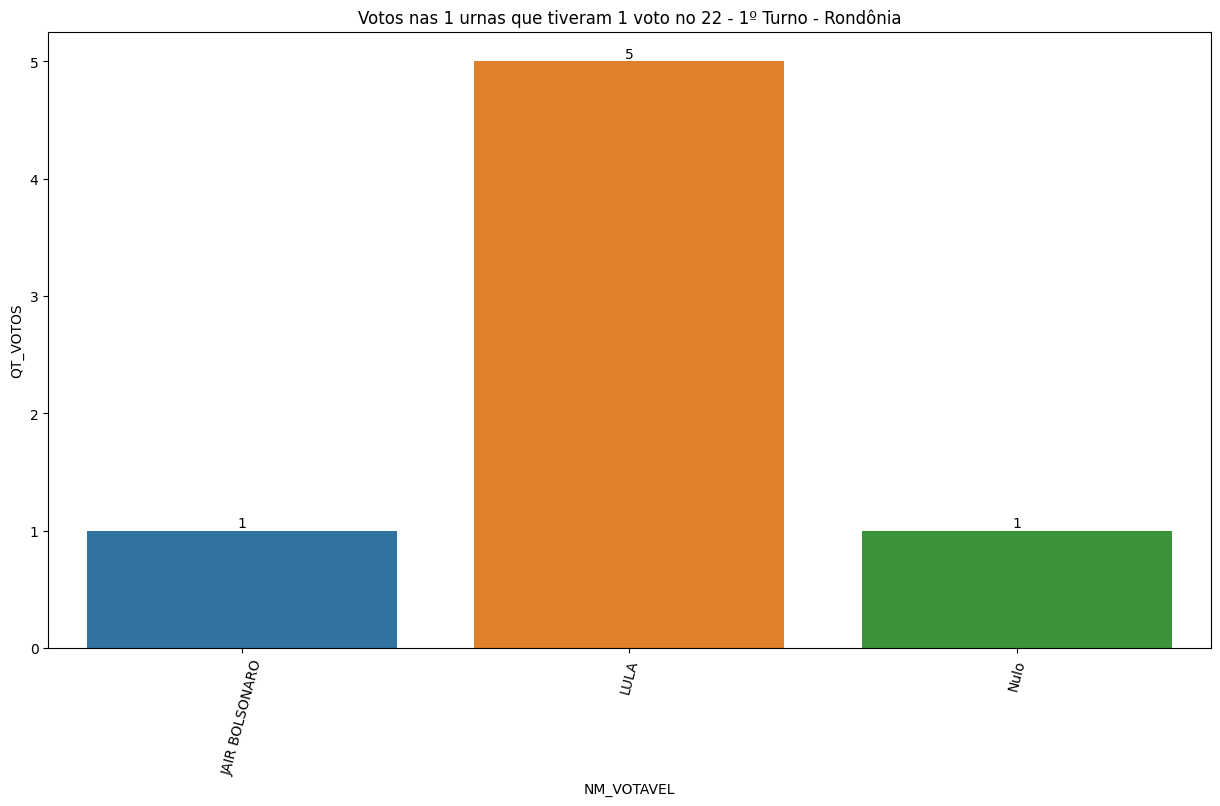

In [55]:
df_soma = df_diff_group(df1ro, df1ro_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1ro_urnas_22, 'Rondônia')


Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1ro_sub = df1ro[~((df1ro['CD_MUNICIPIO'].isin(df1ro_urnas_22['CD_MUNICIPIO'])) & 
            (df1ro['NR_ZONA'].isin(df1ro_urnas_22['NR_ZONA'])) & 
            (df1ro['NR_SECAO'].isin(df1ro_urnas_22['NR_SECAO'])) & 
            (df1ro['NR_LOCAL_VOTACAO'].isin(df1ro_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1ro_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Rondônia')


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?


In [ ]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1ro_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'RO')

##### 1.2.1.5. RORAIMA


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 3
       NM_MUNICIPIO  NR_ZONA  NR_SECAO  NR_LOCAL_VOTACAO
173045    NORMANDIA        5       627              1147
193380     UIRAMUTÃ        7        62              1139
193417     UIRAMUTÃ        7        63              1147


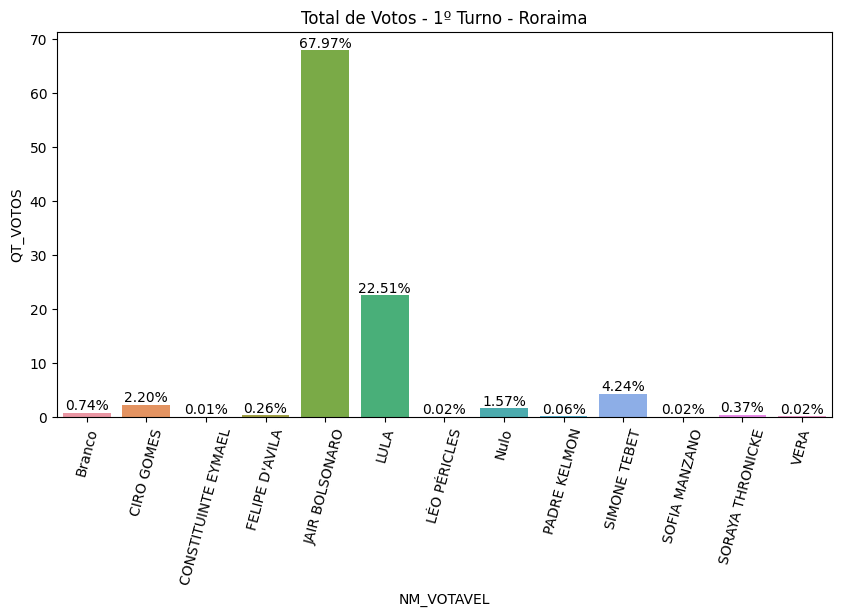

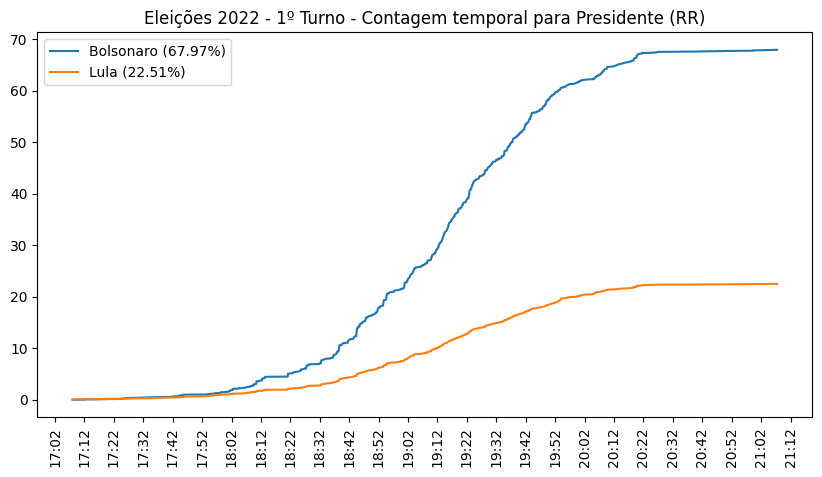

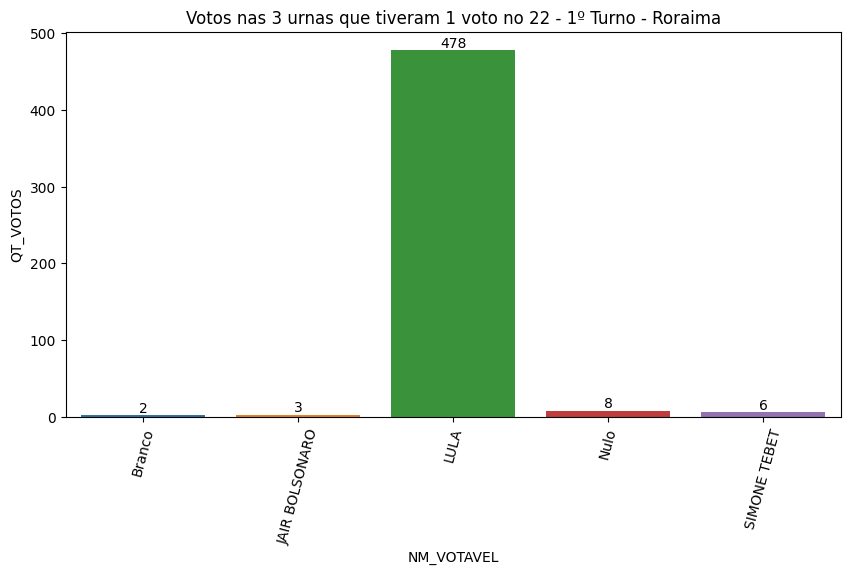

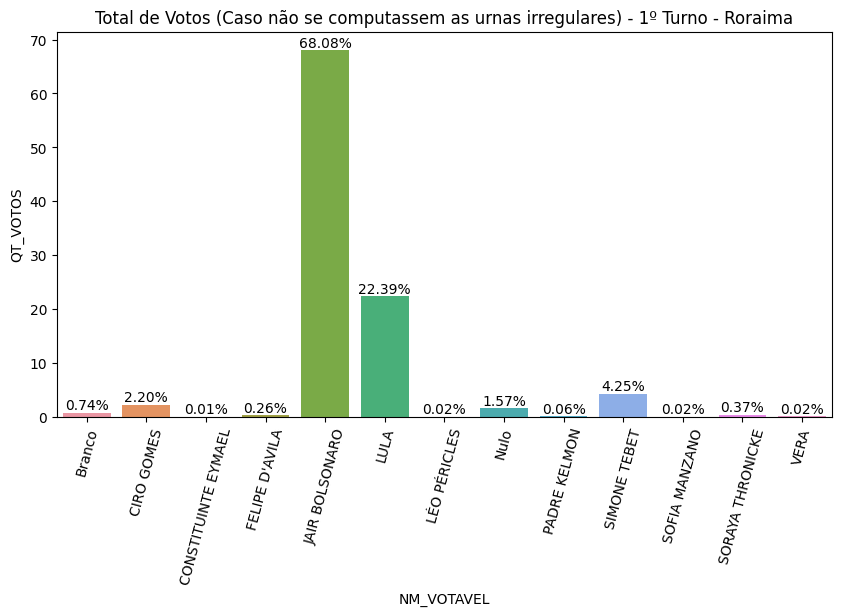

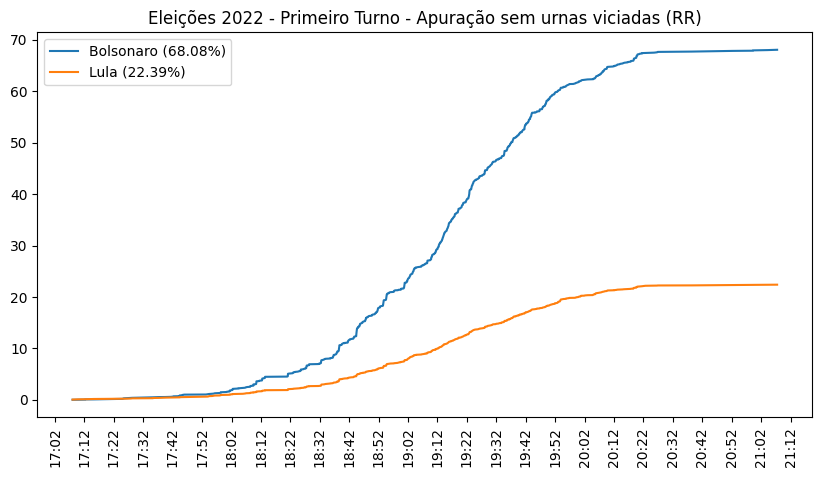

In [73]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1rr, 'Total de Votos - 1º Turno', 'Roraima')# Total de votos acumulados
gerar_grafico_temporal(df1rr, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'RR')

df1rr_urnas = df1rr[df1rr['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1rr_urnas[df1rr_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1rr_urnas[df1rr_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")

df1rr_urnas_22 = df1rr_urnas[df1rr_urnas['NR_VOTAVEL'] == 22]
print(df1rr_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']])

df_soma = df_diff_group(df1rr, df1rr_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1rr_urnas_22, 'Roraima')

df1rr_sub = df1rr[~((df1rr['CD_MUNICIPIO'].isin(df1rr_urnas_22['CD_MUNICIPIO'])) & 
            (df1rr['NR_ZONA'].isin(df1rr_urnas_22['NR_ZONA'])) & 
            (df1rr['NR_SECAO'].isin(df1rr_urnas_22['NR_SECAO'])) & 
            (df1rr['NR_LOCAL_VOTACAO'].isin(df1rr_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1rr_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Roraima')

# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1rr_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'RR')



Total de votos, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


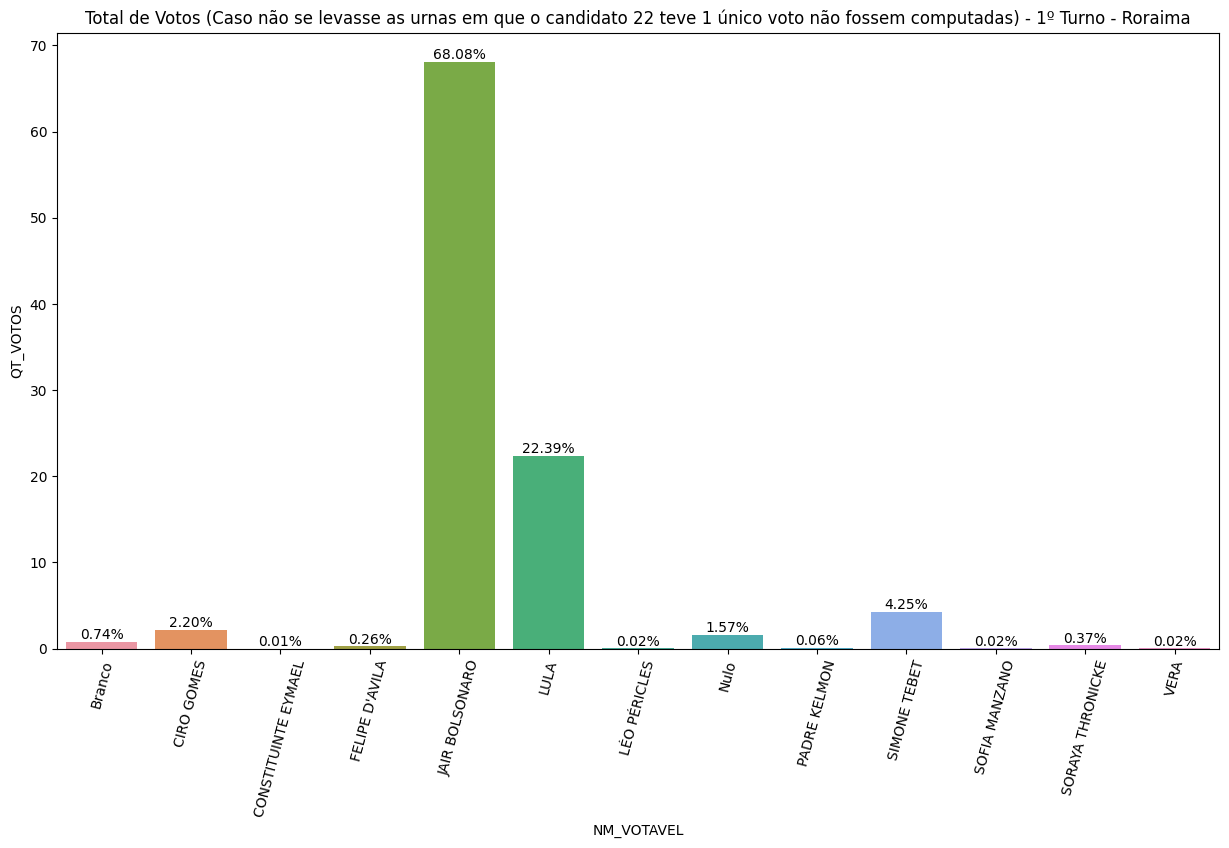

In [45]:
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas


Caso não se computasse as urnas em que o candidato 22 teve 1 único voto, qual seria o resultado?


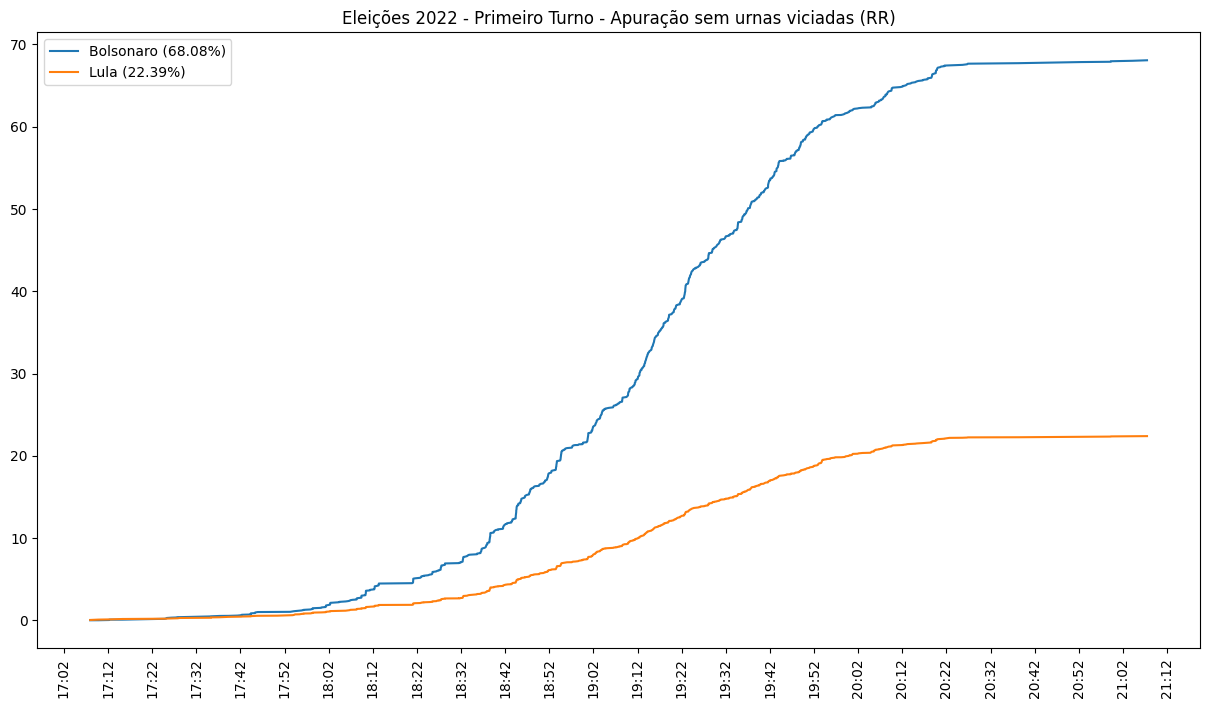

##### 1.2.1.6. AMAPÁ


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 1


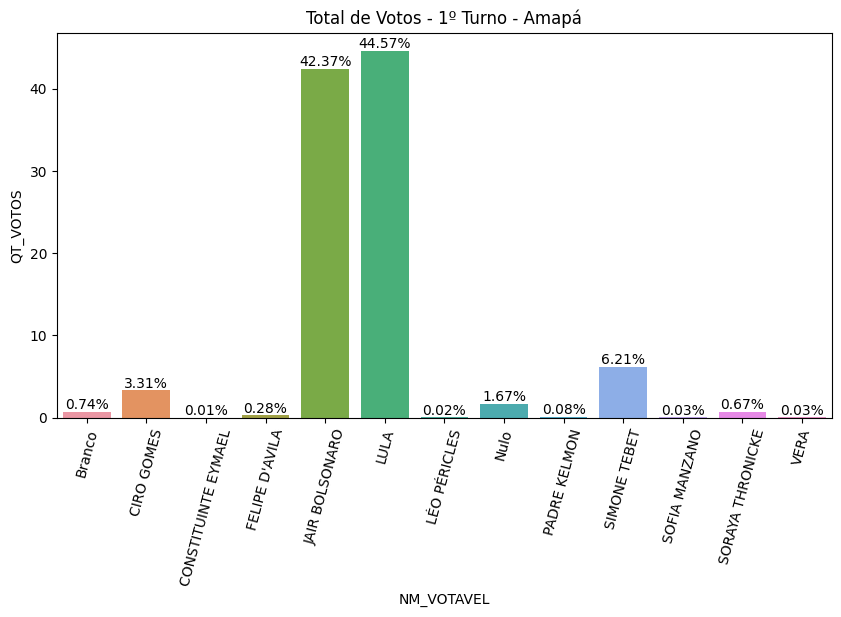

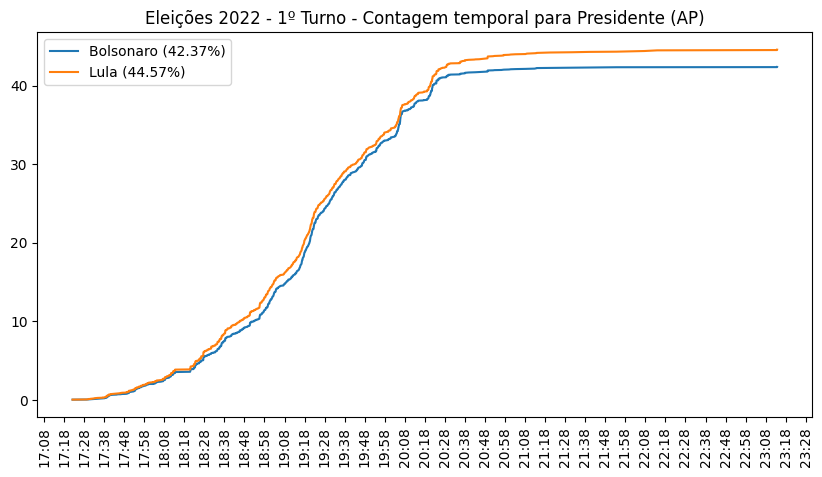

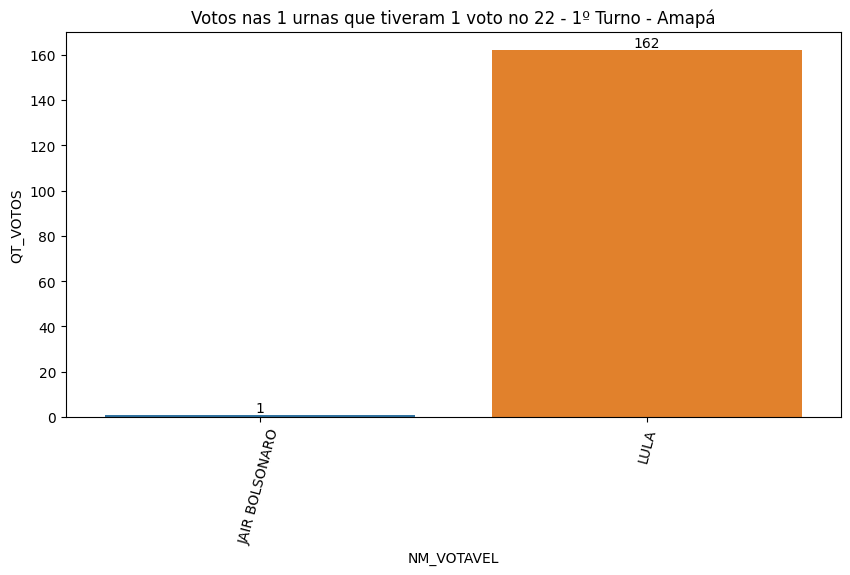

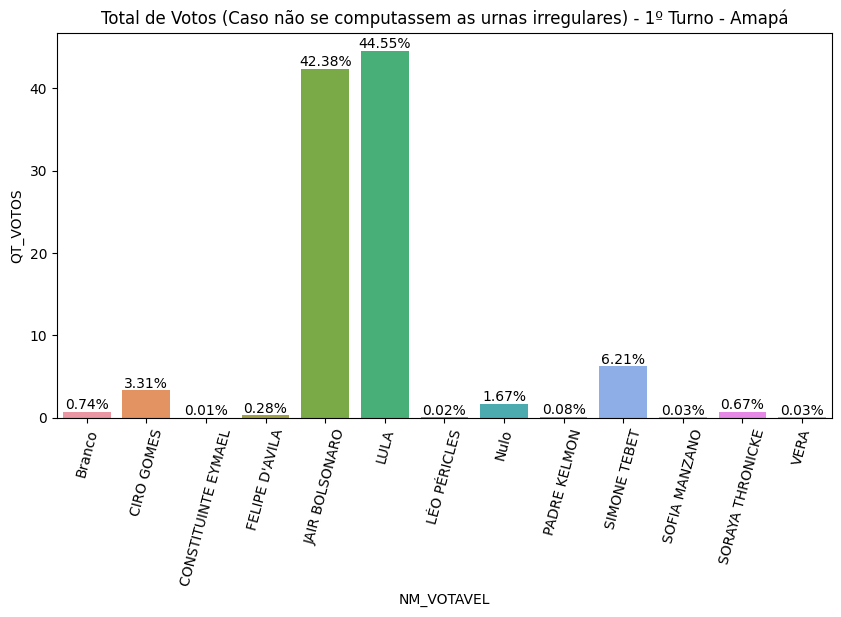

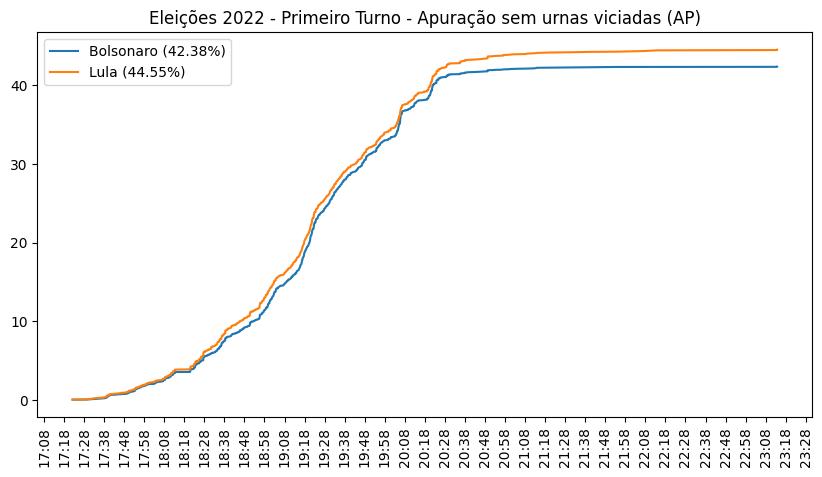

In [74]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1ap, 'Total de Votos - 1º Turno', 'Amapá')
# Total de votos acumulados
gerar_grafico_temporal(df1ap, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'AP')
df1ap_urnas = df1ap[df1ap['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1ap_urnas[df1ap_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1ap_urnas[df1ap_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")
df1ap_urnas_22 = df1ap_urnas[df1ap_urnas['NR_VOTAVEL'] == 22]
df1ap_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]
df_soma = df_diff_group(df1ap, df1ap_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1ap_urnas_22, 'Amapá')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1ap_sub = df1ap[~((df1ap['CD_MUNICIPIO'].isin(df1ap_urnas_22['CD_MUNICIPIO'])) & 
            (df1ap['NR_ZONA'].isin(df1ap_urnas_22['NR_ZONA'])) & 
            (df1ap['NR_SECAO'].isin(df1ap_urnas_22['NR_SECAO'])) & 
            (df1ap['NR_LOCAL_VOTACAO'].isin(df1ap_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1ap_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Amapá')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1ap_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'AP')

##### 1.2.1.7. TOCANTINS


Urnas com 1 voto no candidato 13: 0
Urnas com 1 voto no candidato 22: 5


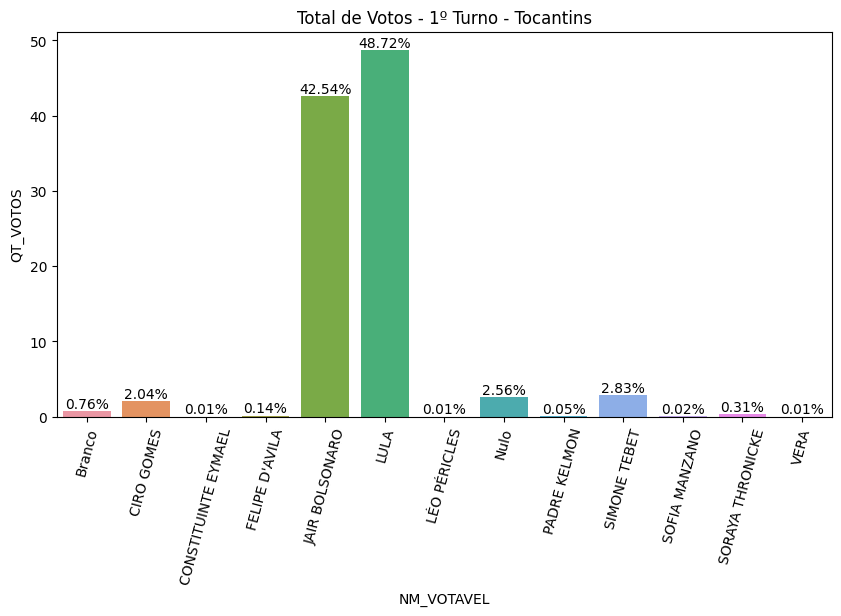

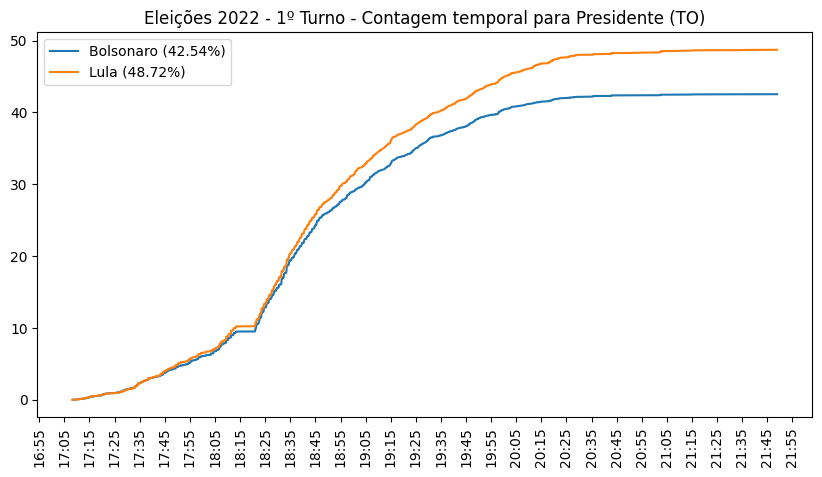

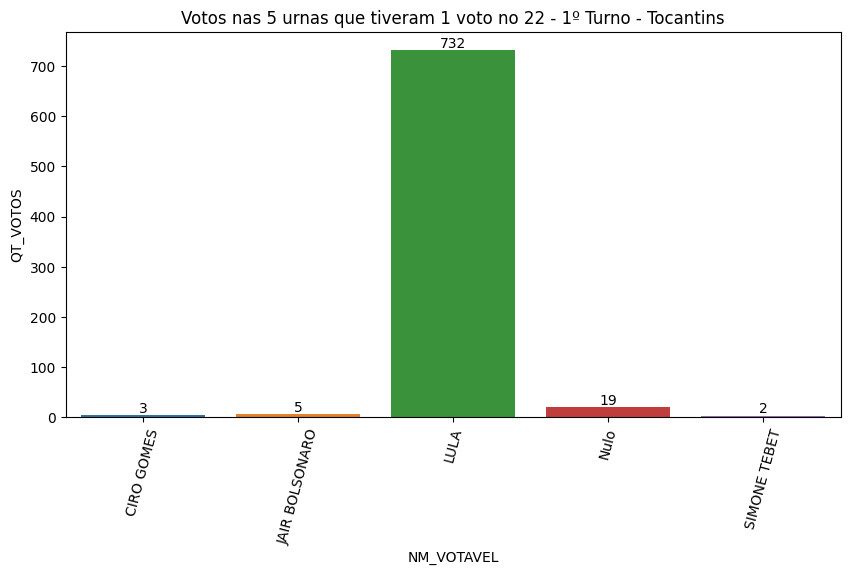

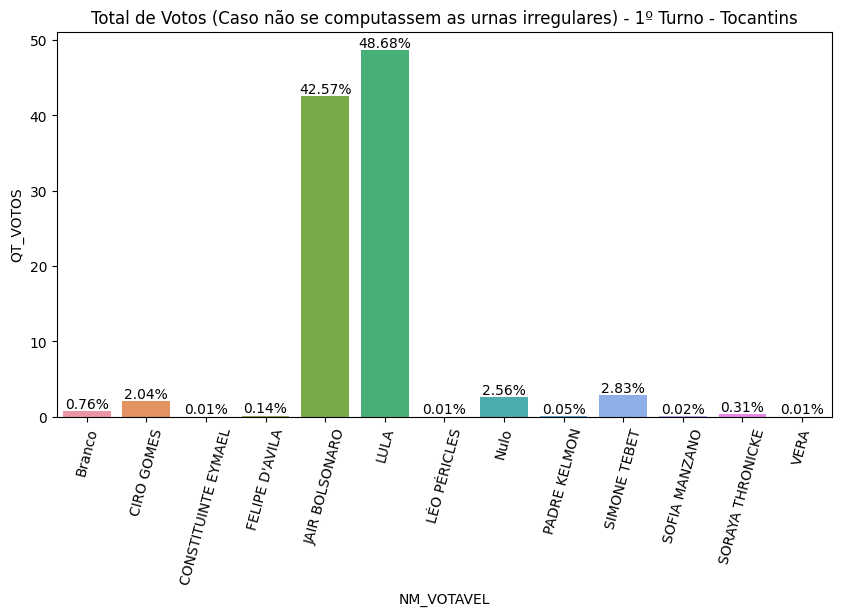

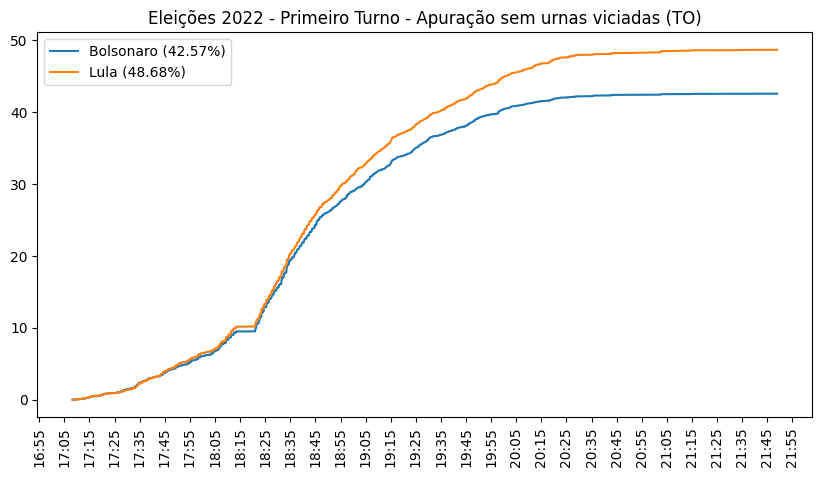

In [76]:
# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1to, 'Total de Votos - 1º Turno', 'Tocantins')
# Total de votos acumulados
gerar_grafico_temporal(df1to, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'TO')
df1to_urnas = df1to[df1to['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1to_urnas[df1to_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1to_urnas[df1to_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")
df1to_urnas_22 = df1to_urnas[df1to_urnas['NR_VOTAVEL'] == 22]
df1to_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]
df_soma = df_diff_group(df1to, df1to_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1to_urnas_22, 'Tocantins')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1to_sub = df1to[~((df1to['CD_MUNICIPIO'].isin(df1to_urnas_22['CD_MUNICIPIO'])) & 
            (df1to['NR_ZONA'].isin(df1to_urnas_22['NR_ZONA'])) & 
            (df1to['NR_SECAO'].isin(df1to_urnas_22['NR_SECAO'])) & 
            (df1to['NR_LOCAL_VOTACAO'].isin(df1to_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1to_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Tocantins')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1to_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'TO')

#### 1.2.2. Resultado da Região

Urnas com 1 voto no candidato 13: 1
Urnas com 1 voto no candidato 22: 62


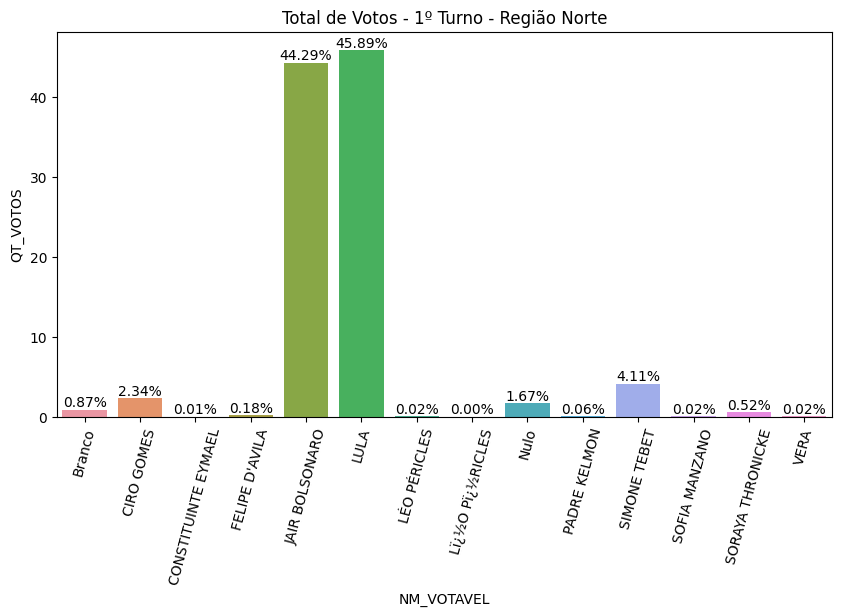

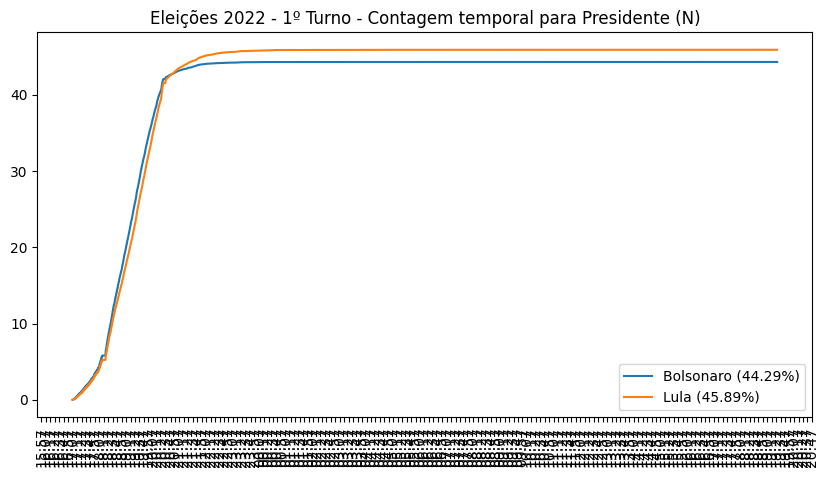

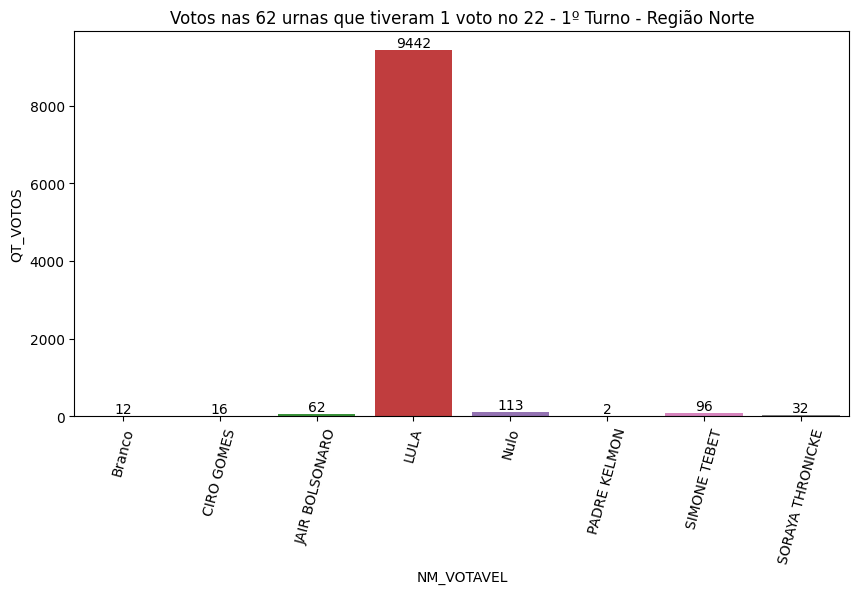

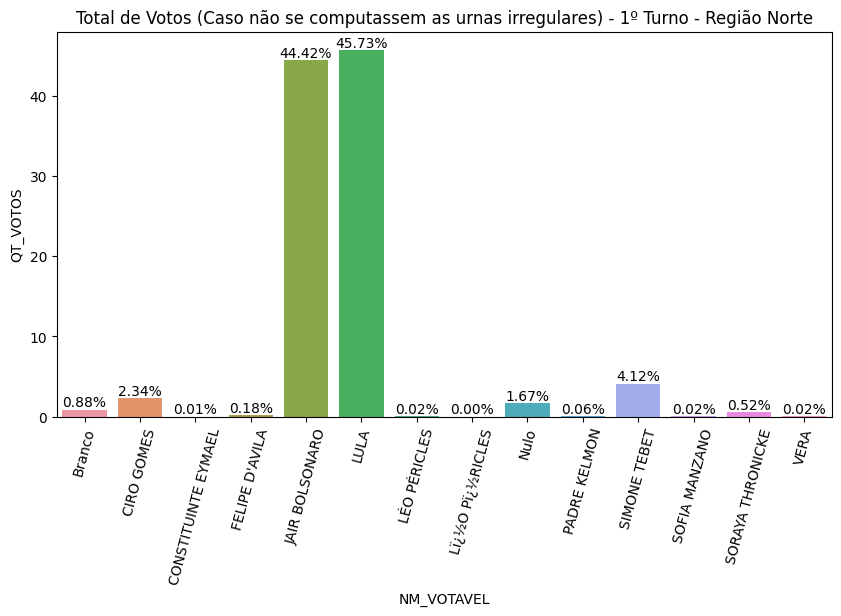

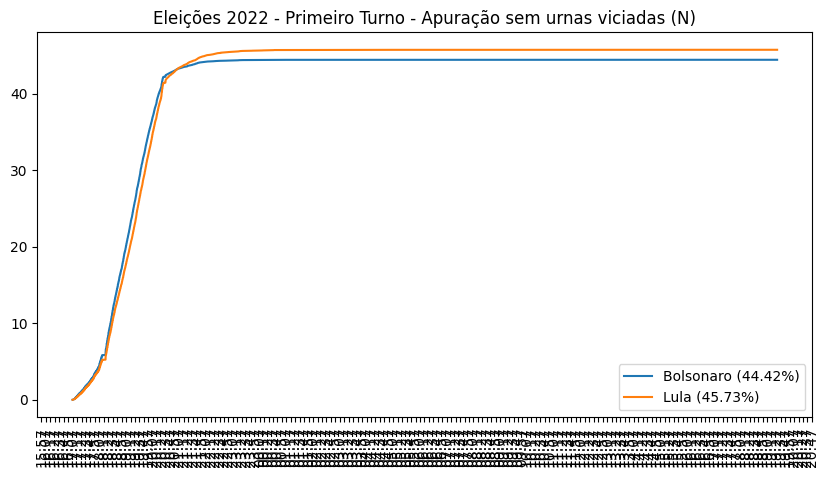

In [77]:
df1n = pd.concat([df1am, df1pa, df1ac, df1ro, df1rr, df1ap, df1to], ignore_index=True)

# Graficos - Total no 1º turno
gerar_grafico_porcentagem(df1n, 'Total de Votos - 1º Turno', 'Região Norte')
# Total de votos acumulados
gerar_grafico_temporal(df1n, 'Eleições 2022 - 1º Turno - Contagem temporal para Presidente', 'N')
df1n_urnas = df1n[df1n['QT_VOTOS'] == 1]
print(f"Urnas com 1 voto no candidato 13: {df1n_urnas[df1n_urnas['NR_VOTAVEL'] == 13]['NR_VOTAVEL'].count()}")
print(f"Urnas com 1 voto no candidato 22: {df1n_urnas[df1n_urnas['NR_VOTAVEL'] == 22]['NR_VOTAVEL'].count()}")
df1n_urnas_22 = df1n_urnas[df1n_urnas['NR_VOTAVEL'] == 22]
df1n_urnas_22[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']]
df_soma = df_diff_group(df1n, df1n_urnas_22)
gerar_grafico_urnas_suspeitas(df_soma, df1n_urnas_22, 'Região Norte')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
df1n_sub = df1n[~((df1n['CD_MUNICIPIO'].isin(df1n_urnas_22['CD_MUNICIPIO'])) & 
            (df1n['NR_ZONA'].isin(df1n_urnas_22['NR_ZONA'])) & 
            (df1n['NR_SECAO'].isin(df1n_urnas_22['NR_SECAO'])) & 
            (df1n['NR_LOCAL_VOTACAO'].isin(df1n_urnas_22['NR_LOCAL_VOTACAO'])))]
gerar_grafico_porcentagem(df1n_sub, 'Total de Votos (Caso não se computassem as urnas irregulares) - 1º Turno', 'Região Norte')
# Total de votos acumulados, caso as urnas em que o candidato 22 recebeu 1 voto não fossem computadas
gerar_grafico_temporal(df1n_sub, 'Eleições 2022 - Primeiro Turno - Apuração sem urnas viciadas', 'N')